# Analyse de données : Notebook projet foot


## Nom, Prénom : DELAHAYE Tom, GUILLEMOT Kentin
## TD : B


### Plan du notebook :

    1) Importation des fichiers csv
    2) Fonctions utiles
    3) Analyse exploratoire & nettoyage des données
    4) Ajout de nouvelles features interressantes (avec test d'accuracy via pycarret à chaque colonne ajouté)
    5) Création des modèles
    6) Modification de match_2023 pour faire apparaitre les bonnes features necessaires à la prédiction
    7) Prédiction des resultats de match_2023
    
    
### Introduction :

Le notebook suivant retrace le developpement de plusieurs modèles de prédiction servant à prédire, à l'aide de caractéristique précise dans un tableau, l'issue d'un match.
Nous avons intentionnellement laissé certains essais d'ajouts de colonnes, test de correlation, test d'accuracy... Qui n'apportais pas d'amélioration à la précision des modèles, pour ainsi vous montrez que parfois l'idée de départ semble bonne mais que finalement n'apporte aucune amélioration de précision, voir même la baisse.


Bonne lecture.


















## 1) Importation des fichiers csv

In [7452]:
#Importation de pandas et numpy
import pandas as pd
import numpy as np

match_2023 = pd.read_csv("match_2023.csv")
match_2013_2022 = pd.read_csv("matchs_2013_2022.csv")

club_fr = pd.read_csv("clubs_fr.csv")
player_valuation_before_season = pd.read_csv("player_valuation_before_season.csv")
player_appearance = pd.read_csv("player_appearance.csv")
game_event = pd.read_csv("game_events.csv")
game_lineups = pd.read_csv("game_lineups.csv")

prediction_example = pd.read_csv("prediction_example.csv")


player_valuation_before_season_V2 = pd.read_csv("player_valuation_before_season_V2.csv") #manque les 18 dernières ligne
player_appearance_V2 = pd.read_csv("player_appearance_V2.csv") #il a juste pris les lignes avec FR1 et inférieur ou egal à 2023-06-03



Description des fichiers :

- match_2013_2022.csv : La liste de tous les matchs avant 2023, avec le résultat associé
- match_2023.csv : La liste des matchs à prédire, vous n’avez pas le résultat, il sera dévoilé après la fin du projet.
- prediction_example.csv : un exemple de fichier de prédiction que j’attends pour tester votre modèle. 
À chaque id de match est associé un résultat (-1 0 ou 1)

- clubs_fr.csv : Une liste des clubs français avec quelques stats sur la constitution (récente) de l’équipe
- player_valuation_before_season.csv : Pour chaque joueur, sa valeur sur le marché, à une certaine date, à vous de transformer 
et d’utiliser cette information à bonne escient.
- player_appearance.csv : Un ensemble d’info simple sur chaque joueur pendant chaque match (nombre de buts, nombre de cartons)
- game_lineups.csv : La constitution des équipes pour chaque match, vous n’avez pas la constitution pour les matchs récents.
- game_events.csv :  Un ensemble d’actions pour chaque joueur pendant chaque match, peut compléter les informations sur un joueur, 
vous allez sûrement devoir aggreger des informations ce jeu (par exemple comptez le nombre de passe décisive, d’arrêt etc...)


Il s'avère que j'avais commencé le projet avant la modification des datasets player_valuation_before_season et player_appearance, cependant cela n'a pas changer grand chose à mon code, mes modification sur player_valuation_before_season me donnés player_valuation_before_season_V2 et idem pour player_appearance_V2

- player_valuation_before_season_V2 : même chose que player_valuation_before_season
- player_appearance_V2 : même chose que player_appearance



## 2) Fonctions utiles par la suite

Elles ont été faites au fur et à mesure mais placé ici pour visualiser toutes les fonctions utilisé

Elles ont aussi été laissé la où elle était lorsqu'on les a créé.

Cette zone n'est donc utile que pour bien observer toutes les fonctions créé au cours du notebook (elle aurait très bien pu etre mise à la fin en guise de résumé mais nous avons préféré les mettres ici).




In [7453]:
def nbr_element_null(df):
    a = df.columns
    x = 0
    for i in range(0,len(a)):
        k = a[i]
        x = x + df[k].isnull().sum()
    return x

In [7454]:
#fonction qui renvoie le club d'un joueur à une date donnée (utilise club_date)

def recherche_id_club(player_id, date):
    ligne = club_date[(club_date['date'].str[:4] == date[:4]) & (club_date['player_id'] == player_id)]
    if not ligne.empty:
        return ligne.iloc[0]['player_club_id']
    else:
        return None


In [7455]:
#renvoie la moyenne de la valeur d'un club à une certaine season
#(moyenne des valeurs des joueurs de ce club à cette season la ou à la season précédente si pas de valeur à la 1ere l'année) 

def recherche_valeur_annee(id_club, date):
    
    season_date = retourn_season_date(date)
    
    ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date)
                                           & (player_valuation_before_season['date'] < date)
                                           & (player_valuation_before_season['id_club'] == id_club)]
    if not ligne.empty:
        return ligne.market_value_in_eur.mean()
    else:
        ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date -1)
                                           & (player_valuation_before_season['id_club'] == id_club)]
        if not ligne.empty:
            return ligne.market_value_in_eur.mean()
        else :
            return None

In [7456]:
#retourne la saison d'un match en fonction de la date mise en parametre

def retourn_season_date(date):
    
    annee = date[:4]
    annee = int(annee)
    
    season_n = season[season["season"]==annee]

    seasonn_n_moins_1 = season[season["season"]==annee-1]
    
    if not season_n.empty and str(date) >= str(season_n.iloc[0,1]):
        return season_n.iloc[0,0]
    
    elif not seasonn_n_moins_1.empty and str(date) <= str(seasonn_n_moins_1.iloc[-1,1]):
        return seasonn_n_moins_1.iloc[-1,0]
    else:
        return int(date[:4])

In [7457]:
#La fonction suivante est utilisé lors de la création des modèle, celle ci est notament la pour ressortir les meilleurs
#hyperparametre du modele ridge classifier lorsqu'on lui met en données de train les données sans les colonnes positions
#(vous comprendrez mieux au cours du notebook)

def meilleur_paramettres_ridge_sans_position(X_train, y_train):
    best_score = 0
    best_params = 1
    for i in range(1,3001):
        
        ridgeclassifier = RidgeClassifier(alpha=i)  
        ridgeclassifier.fit(X_train, y_train)
        y_pred = ridgeclassifier.predict(X_test_norm)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy > best_score:
            best_score = accuracy
            best_params = i

    return best_params, best_score



In [7458]:
#La fonction suivante est utilisé lors de la création des modèle, celle ci est notament la pour ressortir les meilleurs
#hyperparametre du modele ridge classifier lorsqu'on lui met en données de train les données avec les colonnes positions
#(vous comprendrez mieux au cours du notebook)

def meilleur_paramettres_ridge_avec_position(X_train, y_train):
    best_score = 0
    best_params = 1
    for i in range(1,3001):
        
        ridgeclassifier = RidgeClassifier(alpha=i)  
        ridgeclassifier.fit(X_train, y_train)
        y_pred = ridgeclassifier.predict(X_test_norm_posi)
        
        accuracy = accuracy_score(y_test_posi, y_pred)
        
        if accuracy > best_score:
            best_score = accuracy
            best_params = i

    return best_params, best_score



In [7459]:
#renvoie la moyenne de la valeur d'un club à une certaine season
#(moyenne des valeurs des joueurs de ce club à cette season la ou à la season précédente si pas de valeur à la 1ere l'année) 

def recherche_valeur_annee_2023(id_club, date):
    
    season_date = retourn_season_date(date)
    
    ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date)
                                           & (player_valuation_before_season['id_club'] == id_club)]
    if not ligne.empty:
        return ligne.market_value_in_eur.mean()
    else:
        ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date -1)
                                           & (player_valuation_before_season['id_club'] == id_club)]
        if not ligne.empty:
            return ligne.market_value_in_eur.mean()
        else :
            ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date -2)
                                           & (player_valuation_before_season['id_club'] == id_club)]
            if not ligne.empty:
                return ligne.market_value_in_eur.mean()
            else :
                return None





## 3) Analyse exploratoire & Nettoyage des données




### match_2013_2022 

In [7460]:
match_2013_2022

Unnamed: 0  game_id  season         round        date  home_club_id  \
0             12  2330874    2013   8. Matchday  2013-09-28           618   
1             13  2330880    2013  10. Matchday  2013-10-19         14171   
2             14  2330916    2013  15. Matchday  2013-11-30          1423   
3             15  2331018    2013  21. Matchday  2014-01-18           273   
4             16  2331034    2013  24. Matchday  2014-02-08          1147   
...          ...      ...     ...           ...         ...           ...   
4073       66083  3199491    2019  14. Matchday  2019-11-24            40   
4074       67000  3394982    2020  36. Matchday  2021-05-09           667   
4075       67467  3047720    2018  20. Matchday  2019-01-13           415   
4076       67720  3199559    2019  21. Matchday  2020-01-25           162   
4077       67721  3394685    2020  13. Matchday  2020-12-06            40   

      away_club_id  home_club_goals  away_club_goals  home_club_position  ...  \
0              595                2                2                 6.0  ...   
1              855                1                2                16.0  ...   
2             1082                0                1                18.0  ...   
3            14171                0                0                15.0  ...   
4              273                3                1                20.0  ...   
...            ...              ...              ...                 ...  ...   
4073           162                2                1                 4.0  ...   
4074           969                2                3                16.0  ...   
4075           667                1                2                14.0  ...   
4076           667                1                3                13.0  ...   
4077          3911                1                0                10.0  ...   

                       stadium attendance             referee  \
0      Stade Geoffroy-Guichard    31952.0      Antony Gautier   
1     Parc des Sports d’Annecy     8620.0       Philippe Kalt   
2             Stade du Hainaut    14874.0   Bartolomeu Varela   
3                 Roazhon Park    13391.0       Benoît Millot   
4          Stade François-Coty     5981.0      Benoît Bastien   
...                        ...        ...                 ...   
4073         Matmut Atlantique    34554.0       Benoît Millot   
4074        Stade de la Meinau        NaN  Jérôme Miguelgorry   
4075         Stadium Municipal    15465.0   Hakim Ben El Hadj   
4076            Stade Louis-II     4800.0     Eric Wattellier   
4077         Matmut Atlantique        NaN     Frank Schneider   

     home_club_formation  away_club_formation  \
0        4-3-3 Attacking              4-2-3-1   
1         4-4-2 double 6       4-4-2 double 6   
2         4-4-2 double 6              4-3-1-2   
3        4-3-3 Attacking              4-2-3-1   
4                4-1-4-1      4-3-3 Defending   
...                  ...                  ...   
4073               3-4-3           3-5-2 flat   
4074       4-4-2 Diamond      4-3-3 Attacking   
4075               5-4-1                5-3-2   
4076     4-3-3 Attacking                5-3-2   
4077      4-4-2 double 6       4-4-2 double 6   

                                    home_club_name  \
0                                 AS Saint-Étienne   
1                     Thonon Évian Grand Genève FC   
2                                  Valenciennes FC   
3                      Stade Rennais Football Club   
4                                       AC Ajaccio   
...                                            ...   
4073                         FC Girondins Bordeaux   
4074              Racing Club de Strasbourg Alsace   
4075                        Toulouse Football Club   
4076  Association sportive de Monaco Football Club   
4077                         FC Girondins Bordeaux   

                                     away_club_name aggregate  \
0                       

In [7461]:
match_2013_2022.columns

Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results'],
      dtype='object')

In [7462]:
match_2013_2022.corr()

Unnamed: 0   game_id    season  home_club_id  \
Unnamed: 0            1.000000  0.069607  0.068005     -0.007849   
game_id               0.069607  1.000000  0.994613     -0.073932   
season                0.068005  0.994613  1.000000     -0.083840   
home_club_id         -0.007849 -0.073932 -0.083840      1.000000   
away_club_id          0.007258 -0.074094 -0.084085     -0.029921   
home_club_goals       0.006680  0.017540  0.017994     -0.050096   
away_club_goals       0.000745  0.075746  0.072514      0.044893   
home_club_position   -0.010793  0.005728  0.004980      0.234411   
away_club_position    0.016952 -0.005589 -0.004718     -0.024855   
attendance           -0.000534  0.039172  0.038473     -0.203569   
results               0.011645 -0.038518 -0.037163     -0.063275   

                    away_club_id  home_club_goals  away_club_goals  \
Unnamed: 0              0.007258         0.006680         0.000745   
game_id                -0.074094         0.017540         0.075746   
season                 -0.084085         0.017994         0.072514   
home_club_id           -0.029921        -0.050096         0.044893   
away_club_id            1.000000         0.044721        -0.061780   
home_club_goals         0.044721         1.000000        -0.086822   
away_club_goals        -0.061780        -0.086822         1.000000   
home_club_position     -0.030703        -0.334554         0.257990   
away_club_position      0.238255         0.281564        -0.295657   
attendance             -0.036681         0.167848        -0.059865   
results                 0.080797         0.631402        -0.632213   

                    home_club_position  away_club_position  attendance  \
Unnamed: 0                   -0.010793            0.016952   -0.000534   
game_id                       0.005728           -0.005589    0.039172   
season                        0.004980           -0.004718    0.038473   
home_club_id                  0.234411           -0.024855   -0.203569   
away_club_id                 -0.030703            0.238255   -0.036681   
home_club_goals              -0.334554            0.281564    0.167848   
away_club_goals               0.257990           -0.295657   -0.059865   
home_club_position            1.000000           -0.140522   -0.486814   
away_club_position           -0.140522            1.000000   -0.066704   
attendance                   -0.486814           -0.066704    1.000000   
results                      -0.395606            0.392833    0.122904   

                     results  
Unnamed: 0          0.011645  
game_id            -0.038518  
season             -0.037163  
home_club_id       -0.063275  
away_club_id        0.080797  
home_club_goals     0.631402  
away_club_goals    -0.632213  
home_club_position -0.395606  
away_club_position  0.392833  
attendance          0.122904  
results             1.000000

In [7463]:
match_2013_2022.competition_type.unique()

array(['domestic_league'], dtype=object)

In [7464]:
match_2013_2022.drop('Unnamed: 0',axis = 1, inplace = True) #inutile
match_2013_2022.drop('competition_type',axis = 1, inplace = True) #inutile
match_2013_2022.drop('home_club_name',axis = 1, inplace = True) #on passe par l'id donc le nom sert a rien
match_2013_2022.drop('away_club_name',axis = 1, inplace = True) #on passe par l'id donc le nom sert a rien

In [7465]:
#ne pas se fier à la ligne suivante qui est un drop à tord de ma part
#je m'en suis rendu compte plus tard (trop tard donc peux pas juste enlever la cell car sinon cela mon contraindrais à modifier tout le programme)
#et donc j'y ferai appel plus tard

match_2013_2022.drop('attendance',axis = 1, inplace = True)

In [7466]:
match_2013_2022.drop('aggregate',axis = 1, inplace = True) # c'est le score donc de la triche

In [7467]:
match_2013_2022

game_id  season         round        date  home_club_id  away_club_id  \
0     2330874    2013   8. Matchday  2013-09-28           618           595   
1     2330880    2013  10. Matchday  2013-10-19         14171           855   
2     2330916    2013  15. Matchday  2013-11-30          1423          1082   
3     2331018    2013  21. Matchday  2014-01-18           273         14171   
4     2331034    2013  24. Matchday  2014-02-08          1147           273   
...       ...     ...           ...         ...           ...           ...   
4073  3199491    2019  14. Matchday  2019-11-24            40           162   
4074  3394982    2020  36. Matchday  2021-05-09           667           969   
4075  3047720    2018  20. Matchday  2019-01-13           415           667   
4076  3199559    2019  21. Matchday  2020-01-25           162           667   
4077  3394685    2020  13. Matchday  2020-12-06            40          3911   

      home_club_goals  away_club_goals  home_club_position  \
0                   2                2                 6.0   
1                   1                2                16.0   
2                   0                1                18.0   
3                   0                0                15.0   
4                   3                1                20.0   
...               ...              ...                 ...   
4073                2                1                 4.0   
4074                2                3                16.0   
4075                1                2                14.0   
4076                1                3                13.0   
4077                1                0                10.0   

      away_club_position home_club_manager_name away_club_manager_name  \
0                    8.0     Christophe Galtier         Frédéric Hantz   
1                   10.0          Pascal Dupraz     Jocelyn Gourvennec   
2                    2.0           Ariel Jacobs            René Girard   
3                   17.0     Philippe Montanier          Pascal Dupraz   
4                   15.0     Christian Bracconi     Philippe Montanier   
...                  ...                    ...                    ...   
4073                14.0            Paulo Sousa        Leonardo Jardim   
4074                 8.0         Thierry Laurey    Michel Der Zakarian   
4075                 8.0         Alain Casanova         Thierry Laurey   
4076                 8.0          Robert Moreno         Thierry Laurey   
4077                12.0      Jean-Louis Gasset     Olivier Dall'Oglio   

                       stadium             referee home_club_formation  \
0      Stade Geoffroy-Guichard      Antony Gautier     4-3-3 Attacking   
1     Parc des Sports d’Annecy       Philippe Kalt      4-4-2 double 6   
2             Stade du Hainaut   Bartolomeu Varela      4-4-2 double 6   
3                 Roazhon Park       Benoît Millot     4-3-3 Attacking   
4          Stade François-Coty      Benoît Bastien             4-1-4-1   
...                        ...                 ...                 ...   
4073         Matmut Atlantique       Benoît Millot               3-4-3   
4074        Stade de la Meinau  Jérôme Miguelgorry       4-4-2 Diamond   
4075         Stadium Municipal   Hakim Ben El Hadj               5-4-1   
4076            Stade Louis-II     Eric Wattellier     4-3-3 Attacking   
4077         Matmut Atlantique     Frank Schneider      4-4-2 double 6   

     away_club_formation  results  
0                4-2-3-1        0  
1         4-4-2 double 6       -1  
2                4-3-1-2       -1  
3                4-2-3-1        0  
4        4-3-3 Defending        1  
...                  ...      ...  
4073          3-5-2 flat        1  
4074     4-3-3 Attacking       -1  
4075               5-3-2       -1  
4076               5-3-2       -1  
4077      4-4-2 double 6        1  

[4078 rows x 17 columns]

In [7468]:
match_2013_2022.columns

Index(['game_id', 'season', 'round', 'date', 'home_club_id', 'away_club_id',
       'home_club_goals', 'away_club_goals', 'home_club_position',
       'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'referee', 'home_club_formation',
       'away_club_formation', 'results'],
      dtype='object')

In [7469]:
#renvoie le nombre d'element null dans la dataframe match_2013_2022
print(nbr_element_null(match_2013_2022))

#renvoie les lignes avec une/des NAN values
test = match_2013_2022[match_2013_2022.isna().any(axis=1)]
test

764


game_id  season         round        date  home_club_id  away_club_id  \
83    2223859    2012   8. Matchday  2012-10-06          1082          1147   
84    2223876    2012   5. Matchday  2012-09-16          1159           244   
85    2223890    2012   4. Matchday  2012-09-02          1082           583   
86    2223894    2012  18. Matchday  2012-12-16           583          1041   
87    2223902    2012   9. Matchday  2012-10-20           273           969   
...       ...     ...           ...         ...           ...           ...   
3976  2223976    2012  16. Matchday  2012-12-07           415           595   
3977  2224094    2012  27. Matchday  2013-03-03          3911          1041   
3978  2224182    2012  38. Matchday  2013-05-26           415           969   
4058  3839781    2022   2. Matchday  2022-08-14          3911           244   
4066  3839821    2022   3. Matchday  2022-08-19          1041          1095   

      home_club_goals  away_club_goals  home_club_position  \
83                  2                0                10.0   
84                  0                1                17.0   
85                  1                2                11.0   
86                  1                0                 1.0   
87                  2                1                 9.0   
...               ...              ...                 ...   
3976                0                0                 9.0   
3977                1                1                15.0   
3978                2                0                10.0   
4058                1                1                14.0   
4066                4                1                 5.0   

      away_club_position home_club_manager_name away_club_manager_name  \
83                  14.0            Rudi Garcia            Alex Dupont   
84                   1.0         Jean Fernandez              Élie Baup   
85                   8.0            Rudi Garcia        Carlo Ancelotti   
86                   2.0        Carlo Ancelotti             Rémi Garde   
87                  16.0     Frédéric Antonetti            René Girard   
...                  ...                    ...                    ...   
3976                13.0         Alain Casanova         Frédéric Hantz   
3977                 2.0         Landry Chauvin             Rémi Garde   
3978                 9.0         Alain Casanova            René Girard   
4058                 4.0    Michel Der Zakarian             Igor Tudor   
4066                20.0             Peter Bosz            Bruno Irles   

                                  stadium          referee  \
83    Decathlon Arena-Stade Pierre-Mauroy  Lionel Jaffredo   
84                     Stade Marcel-Picot    Philippe Kalt   
85    Decathlon Arena-Stade Pierre-Mauroy     Ruddy Buquet   
86                       Parc des Princes   Antony Gautier   
87                           Roazhon Park   Antony Gautier   
...                                   ...              ...   
3976                    Stadium Municipal     Ruddy Buquet   
3977                 Stade Francis-Le Blé     Said Ennjimi   
3978                    Stadium Municipal    Mikael Lesage   
4058                 Stade Francis-Le Blé    Jérémy Stinat   
4066                     Groupama Stadium  Eric Wattellier   

     home_club_formation away_club_formation  results  
83                   NaN                 NaN        1  
84                   NaN                 NaN       -1  
85                   NaN                 NaN       -1  
86                   NaN                 NaN        1  
87                   NaN                 NaN        1  
...                  ...                 ...      ...  
3976                 NaN                 NaN        0  
3977                 NaN                 NaN        0  
3978                 NaN                 NaN        1  
4058                 NaN                 NaN        0  
4066                 NaN                 NaN        1  

[382 

In [7470]:
match_2013_2022.drop("home_club_formation",axis = 1, inplace = True) #car pas accessible avant match
match_2013_2022.drop("away_club_formation",axis = 1, inplace = True) #car pas accesible avant match



#Dans la même idée que la colonne attendance drop à tord, les position ci-dessous que je drop seront enfaite 
#finalement utile pour la suite. Cependantà l'instar de attendance au moment où je m'en suis rendu compte j'avais deja codé
#une grosse partie du projet, je ne peux donc pas juste retirer les lignes suivante.

#Ce n'est pas grave ! J'y ferai juste appel plus tard.


match_2013_2022.drop("home_club_position",axis = 1, inplace = True) 
match_2013_2022.drop("away_club_position",axis = 1, inplace = True) 
            
match_2013_2022.drop("home_club_goals",axis = 1, inplace = True) # c'est le score donc de la triche
match_2013_2022.drop("away_club_goals",axis = 1, inplace = True) # c'est le score donc de la triche

In [7471]:
print(nbr_element_null(match_2013_2022))

0


In [7472]:
#match_2013_2022.drop("season",axis = 1, inplace = True) #on va se baser sur la colonne date directement

match_2013_2022.drop("round",axis = 1, inplace = True) #inutile

In [7473]:
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
4073  3199491    2019  2019-11-24            40           162   
4074  3394982    2020  2021-05-09           667           969   
4075  3047720    2018  2019-01-13           415           667   
4076  3199559    2019  2020-01-25           162           667   
4077  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
4073            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
4074         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
4075         Alain Casanova         Thierry Laurey         Stadium Municipal   
4076          Robert Moreno         Thierry Laurey            Stade Louis-II   
4077      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  results  
0         Antony Gautier        0  
1          Philippe Kalt       -1  
2      Bartolomeu Varela       -1  
3          Benoît Millot        0  
4         Benoît Bastien        1  
...                  ...      ...  
4073       Benoît Millot        1  
4074  Jérôme Miguelgorry       -1  
4075   Hakim Ben El Hadj       -1  
4076     Eric Wattellier       -1  
4077     Frank Schneider        1  

[4078 rows x 10 columns]

In [7474]:
match_2013_2022.describe()


game_id       season  home_club_id  away_club_id      results
count  4.078000e+03  4078.000000   4078.000000   4078.000000  4078.000000
mean   2.935466e+06  2016.950466   1095.466160   1094.685140     0.146886
std    5.068788e+05     3.186078   1730.980074   1731.133943     0.845861
min    2.223841e+06  2012.000000     40.000000     40.000000    -1.000000
25%    2.482368e+06  2014.000000    415.000000    415.000000    -1.000000
50%    2.942690e+06  2017.000000    855.000000    855.000000     0.000000
75%    3.394684e+06  2020.000000   1158.000000   1158.000000     1.000000
max    3.840454e+06  2022.000000  14171.000000  14171.000000     1.000000

In [7475]:
match_2013_2022.dtypes

game_id                    int64
season                     int64
date                      object
home_club_id               int64
away_club_id               int64
home_club_manager_name    object
away_club_manager_name    object
stadium                   object
referee                   object
results                    int64
dtype: object

### match_2023 

In [7476]:
match_2023.columns

Index(['game_id', 'date', 'home_club_id', 'away_club_id',
       'home_club_manager_name', 'away_club_manager_name', 'stadium',
       'attendance', 'referee', 'home_club_name', 'away_club_name',
       'competition_type'],
      dtype='object')

In [7477]:
match_2023.drop('competition_type',axis = 1, inplace = True) #inutile

match_2023.drop('referee',axis = 1, inplace = True) #inutile (pas encore drop de match_2013_2022 mais ce sera fait plus tard)

match_2023.drop('away_club_name',axis = 1, inplace = True) #on se base sur l'id
match_2023.drop('home_club_name',axis = 1, inplace = True) #on se base sur l'id

In [7478]:
match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  
0             Franck Haise        Parc des Princes     47000.0  
1            László Bölöni  Stade Bollaert-Delelis     37988.0  
2            Bruno Génésio      Stade de la Mosson     15430.0  
3        Francesco Farioli  Stade Saint-Symphorien     23160.0  
4           Julien Stéphan        Orange Vélodrome     54162.0  
..                     ...                     ...         ...  
265    Michel Der Zakarian            Stade Océane     20556.0  
266      Jean-Louis Gasset       Stadium Municipal     29809.0  
267         Julien Stéphan        Parc des Princes     47874.0  
268      Francesco Farioli       Stadium Municipal     25507.0  
269               Éric Roy      Stade de la Meinau     25140.0  

[270 rows x 8 columns]

In [7479]:
print(nbr_element_null(match_2023))

4


In [7480]:
#visualisiation des lignes avec des NAN values

test = match_2023[match_2023.isna().any(axis=1)]
test

game_id        date  home_club_id  away_club_id home_club_manager_name  \
16   4094648  2023-11-29           969          3524    Michel Der Zakarian   
131  4094827  2024-04-07           995          1041      Antoine Kombouaré   
243  4094660  2023-12-06           244          1041        Gennaro Gattuso   
254  4094789  2024-03-02          3524           244         Pascal Gastien   

    away_club_manager_name                 stadium  attendance  
16          Pascal Gastien      Stade de la Mosson         NaN  
131            Pierre Sage   Stade de la Beaujoire         NaN  
243            Pierre Sage        Orange Vélodrome         NaN  
254      Jean-Louis Gasset  Stade Gabriel-Montpied         NaN

In [7481]:
test["attendance"] = test["attendance"].fillna(0)
test

game_id        date  home_club_id  away_club_id home_club_manager_name  \
16   4094648  2023-11-29           969          3524    Michel Der Zakarian   
131  4094827  2024-04-07           995          1041      Antoine Kombouaré   
243  4094660  2023-12-06           244          1041        Gennaro Gattuso   
254  4094789  2024-03-02          3524           244         Pascal Gastien   

    away_club_manager_name                 stadium  attendance  
16          Pascal Gastien      Stade de la Mosson         0.0  
131            Pierre Sage   Stade de la Beaujoire         0.0  
243            Pierre Sage        Orange Vélodrome         0.0  
254      Jean-Louis Gasset  Stade Gabriel-Montpied         0.0

In [7482]:
match_2023["attendance"] = match_2023["attendance"].fillna(0)
print(nbr_element_null(match_2023))
match_2023

0


game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  
0             Franck Haise        Parc des Princes     47000.0  
1            László Bölöni  Stade Bollaert-Delelis     37988.0  
2            Bruno Génésio      Stade de la Mosson     15430.0  
3        Francesco Farioli  Stade Saint-Symphorien     23160.0  
4           Julien Stéphan        Orange Vélodrome     54162.0  
..                     ...                     ...         ...  
265    Michel Der Zakarian            Stade Océane     20556.0  
266      Jean-Louis Gasset       Stadium Municipal     29809.0  
267         Julien Stéphan        Parc des Princes     47874.0  
268      Francesco Farioli       Stadium Municipal     25507.0  
269               Éric Roy      Stade de la Meinau     25140.0  

[270 rows x 8 columns]

In [7483]:
match_2023.describe()

game_id  home_club_id  away_club_id    attendance
count  2.700000e+02    270.000000    270.000000    270.000000
mean   4.094712e+06   1045.344444   1040.544444  26476.844444
std    7.808649e+01   1009.762402   1011.535490  14212.477851
min    4.094578e+06    162.000000    162.000000      0.000000
25%    4.094645e+06    415.000000    415.000000  15097.250000
50%    4.094712e+06    826.000000    738.000000  24779.000000
75%    4.094780e+06   1082.000000   1082.000000  35454.750000
max    4.094847e+06   3911.000000   3911.000000  66046.000000

In [7484]:
match_2023.dtypes

game_id                     int64
date                       object
home_club_id                int64
away_club_id                int64
home_club_manager_name     object
away_club_manager_name     object
stadium                    object
attendance                float64
dtype: object


### club_fr 

In [7485]:
club_fr.head()

club_id        club_code                                           name  \
0      969  montpellier-hsc                 Montpellier Hérault Sport Club   
1     1082       losc-lille  Lille Olympique Sporting Club Lille Métropole   
2     1160  nimes-olympique                                Nîmes Olympique   
3     3911   stade-brest-29                              Stade brestois 29   
4      595        sc-bastia                                      SC Bastia   

  domestic_competition_id  squad_size  average_age  foreigners_number  \
0                     FR1          25         25.7                 12   
1                     FR1          25         25.4                 18   
2                     FR1          26         25.4                 12   
3                     FR1          24         26.0                  6   
4                     FR1          25         27.6                  8   

   foreigners_percentage  national_team_players  \
0                   48.0                      8   
1                   72.0                      7   
2                   46.2                      3   
3                   25.0                      3   
4                   32.0                      6   

                          stadium_name  stadium_seats net_transfer_record  \
0                   Stade de la Mosson          32939            +€28.60m   
1  Decathlon Arena-Stade Pierre-Mauroy          50186             +€3.65m   
2                   Stade des Antonins           8033             +€2.50m   
3                 Stade Francis-Le Blé          15220             +€5.10m   
4                  Stade Armand-Cesari          16480              +€480k   

   coach_name  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [7486]:
club_fr.domestic_competition_id.unique()

array(['FR1'], dtype=object)

In [7487]:
club_fr.drop('coach_name',axis = 1, inplace = True) #car pas d'infos
club_fr.drop('club_code',axis = 1, inplace = True) #car inutile on a deja le club_id
club_fr.drop('name',axis = 1, inplace = True) #car inutile on a club_id
club_fr.drop('domestic_competition_id',axis = 1, inplace = True) #inutile car que FR1
club_fr.drop('stadium_seats',axis = 1, inplace = True) 
club_fr.drop('stadium_name',axis = 1, inplace = True) 

In [7488]:
club_fr.head()

club_id  squad_size  average_age  foreigners_number  foreigners_percentage  \
0      969          25         25.7                 12                   48.0   
1     1082          25         25.4                 18                   72.0   
2     1160          26         25.4                 12                   46.2   
3     3911          24         26.0                  6                   25.0   
4      595          25         27.6                  8                   32.0   

   national_team_players net_transfer_record  
0                      8            +€28.60m  
1                      7             +€3.65m  
2                      3             +€2.50m  
3                      3             +€5.10m  
4                      6              +€480k

In [7489]:
print(nbr_element_null(club_fr))

0


In [7490]:
club_fr.describe()

club_id  squad_size  average_age  foreigners_number  \
count     35.000000   35.000000    35.000000          35.000000   
mean    1502.885714   25.800000    25.208571          13.028571   
std     2400.062594    4.085844     1.260572           5.043841   
min       40.000000    5.000000    22.700000           1.000000   
25%      589.000000   24.500000    24.300000          10.500000   
50%      995.000000   26.000000    25.400000          13.000000   
75%     1289.000000   28.000000    26.000000          16.000000   
max    14171.000000   30.000000    27.600000          24.000000   

       foreigners_percentage  national_team_players  
count              35.000000              35.000000  
mean               49.968571               6.742857  
std                18.514696               4.320559  
min                18.500000               0.000000  
25%                42.300000               4.000000  
50%                50.000000               6.000000  
75%                57.100000               9.000000  
max               100.000000              19.000000

In [7491]:
club_fr.dtypes

club_id                    int64
squad_size                 int64
average_age              float64
foreigners_number          int64
foreigners_percentage    float64
national_team_players      int64
net_transfer_record       object
dtype: object


### player_valuation_before_season 


In [7492]:
player_valuation_before_season

player_id        date  market_value_in_eur  current_club_id  \
0            773  2004-10-04              3500000            14171   
1           1327  2004-10-04              4000000             1159   
2           1423  2004-10-04              1000000              855   
3           1572  2004-10-04              1000000              162   
4           1613  2004-10-04               200000              855   
...          ...         ...                  ...              ...   
30228     395676  2023-08-22              1000000             1041   
30229     410059  2023-08-22               400000             1416   
30230     506009  2023-08-22              2500000              347   
30231     704156  2023-08-22              2000000              969   
30232     847772  2023-08-22              2000000             1160   

      player_club_domestic_competition_id  
0                                     FR1  
1                                     FR1  
2                                     FR1  
3                                     FR1  
4                                     FR1  
...                                   ...  
30228                                 FR1  
30229                                 FR1  
30230                                 FR1  
30231                                 FR1  
30232                                 FR1  

[30233 rows x 5 columns]

In [7493]:
#Juste pour verifier si il y a plusieurs info sur chaque joueurs
player_valuation_before_season.player_id.value_counts()

27306     49
23934     46
45121     45
43907     44
27470     44
          ..
290577     1
371926     1
745201     1
412828     1
633398     1
Name: player_id, Length: 2011, dtype: int64

In [7494]:
player_valuation_before_season.drop('player_club_domestic_competition_id',axis = 1, inplace = True) #inutile car que FR1

In [7495]:
player_valuation_before_season.head()

player_id        date  market_value_in_eur  current_club_id
0        773  2004-10-04              3500000            14171
1       1327  2004-10-04              4000000             1159
2       1423  2004-10-04              1000000              855
3       1572  2004-10-04              1000000              162
4       1613  2004-10-04               200000              855

In [7496]:
print(nbr_element_null(player_valuation_before_season))

0


In [7497]:
#on prend les valeurs de player_valuation_before_season entre 2013-2023 car sinon pas interressant

player_valuation_before_season = player_valuation_before_season[player_valuation_before_season["date"]>="2012-08-10"]
player_valuation_before_season


player_id        date  market_value_in_eur  current_club_id
6087      119085  2012-08-10               600000               40
6088       79422  2012-08-12               800000              583
6089      114340  2012-08-12              1000000              618
6090       33847  2012-08-13               300000              347
6091       39918  2012-08-13               300000             1416
...          ...         ...                  ...              ...
30228     395676  2023-08-22              1000000             1041
30229     410059  2023-08-22               400000             1416
30230     506009  2023-08-22              2500000              347
30231     704156  2023-08-22              2000000              969
30232     847772  2023-08-22              2000000             1160

[24146 rows x 4 columns]

In [7498]:
season = pd.read_csv("matchs_2013_2022.csv").loc[:,["season","date"]]
season = season.sort_values("date")
season

season        date
2717    2012  2012-08-10
1865    2012  2012-08-11
1394    2012  2012-08-11
358     2012  2012-08-11
3882    2012  2012-08-11
...      ...         ...
1711    2022  2023-06-03
4010    2022  2023-06-03
484     2022  2023-06-03
1013    2022  2023-06-03
4009    2022  2023-06-03

[4078 rows x 2 columns]

In [7499]:
a = season[season["season"]==2012]
a

season        date
2717    2012  2012-08-10
1865    2012  2012-08-11
1394    2012  2012-08-11
358     2012  2012-08-11
3882    2012  2012-08-11
...      ...         ...
2363    2012  2013-05-26
878     2012  2013-05-26
3978    2012  2013-05-26
619     2012  2013-05-26
356     2012  2013-05-26

[380 rows x 2 columns]

In [7500]:
a = season[season["season"]==2013]
a

season        date
4070    2013  2013-08-09
1348    2013  2013-08-10
2779    2013  2013-08-10
3763    2013  2013-08-10
58      2013  2013-08-10
...      ...         ...
1347    2013  2014-05-17
634     2013  2014-05-17
3099    2013  2014-05-17
2777    2013  2014-05-17
266     2013  2014-05-17

[380 rows x 2 columns]

In [7501]:

def retourn_season_date(date):
    
    annee = date[:4]
    annee = int(annee)
    
    season_n = season[season["season"]==annee]

    seasonn_n_moins_1 = season[season["season"]==annee-1]
    
    if not season_n.empty and str(date) >= str(season_n.iloc[0,1]):
        return season_n.iloc[0,0]
    
    elif not seasonn_n_moins_1.empty and str(date) <= str(seasonn_n_moins_1.iloc[-1,1]):
        return seasonn_n_moins_1.iloc[-1,0]
    else:
        return int(date[:4])
    

In [7502]:
#test de la fontion :

In [7503]:
print(retourn_season_date("2014-04-17"))

2013


In [7504]:
print(retourn_season_date("2014-09-17"))

2014


In [7505]:
print(retourn_season_date("2014-06-17"))

2014


In [7506]:
#application de la fonction à player_valuation_before_season

player_valuation_before_season["season"] = player_valuation_before_season.apply(lambda row :retourn_season_date(row["date"]),axis = 1)
player_valuation_before_season

player_id        date  market_value_in_eur  current_club_id  season
6087      119085  2012-08-10               600000               40    2012
6088       79422  2012-08-12               800000              583    2012
6089      114340  2012-08-12              1000000              618    2012
6090       33847  2012-08-13               300000              347    2012
6091       39918  2012-08-13               300000             1416    2012
...          ...         ...                  ...              ...     ...
30228     395676  2023-08-22              1000000             1041    2023
30229     410059  2023-08-22               400000             1416    2023
30230     506009  2023-08-22              2500000              347    2023
30231     704156  2023-08-22              2000000              969    2023
30232     847772  2023-08-22              2000000             1160    2023

[24146 rows x 5 columns]

In [7507]:
print(nbr_element_null(player_valuation_before_season))

0


In [7508]:
player_valuation_before_season.describe()

player_id  market_value_in_eur  current_club_id        season
count  2.414600e+04         2.414600e+04     24146.000000  24146.000000
mean   2.573962e+05         3.377149e+06      1234.088710   2018.172948
std    2.148498e+05         9.613751e+06      1795.745116      3.143913
min    7.730000e+02         1.000000e+04        40.000000   2012.000000
25%    8.300200e+04         3.500000e+05       417.000000   2016.000000
50%    2.033450e+05         8.000000e+05       969.000000   2019.000000
75%    3.642390e+05         2.500000e+06      1160.000000   2021.000000
max    1.111912e+06         2.000000e+08     14171.000000   2023.000000

In [7509]:
player_valuation_before_season.dtypes

player_id               int64
date                   object
market_value_in_eur     int64
current_club_id         int64
season                  int64
dtype: object

### player_appearance 

In [7510]:
player_appearance = player_appearance_V2.copy()
player_appearance

appearance_id  game_id  player_id  player_club_id  \
0       2229837_108830  2229837     108830             415   
1       2229837_113707  2229837     113707             969   
2       2229837_126767  2229837     126767             415   
3       2229837_126796  2229837     126796             415   
4       2229837_127032  2229837     127032             415   
...                ...      ...        ...             ...   
115177  3840454_709482  3840454     709482            1095   
115178   3840454_84301  3840454      84301            1082   
115179  3840454_917104  3840454     917104            1095   
115180  3840454_917120  3840454     917120            1095   
115181  3840454_973085  3840454     973085            1082   

        player_current_club_id        date        player_name competition_id  \
0                         3205  2012-08-10    Aymen Abdennour            FR1   
1                         1082  2012-08-10       Rémy Cabella            FR1   
2                         3205  2012-08-10        Ali Ahamada            FR1   
3                        60949  2012-08-10    Adrien Regattin            FR1   
4                          141  2012-08-10       Serge Aurier            FR1   
...                        ...         ...                ...            ...   
115177                    1095  2023-06-03      Thierno Baldé            FR1   
115178                    1082  2023-06-03     Benjamin André            FR1   
115179                    1095  2023-06-03  Derek Mazou-Sacko            FR1   
115180                    1095  2023-06-03     Tanguy Zoukrou            FR1   
115181                    1237  2023-06-03      Carlos Baleba            FR1   

        yellow_cards  red_cards  goals  assists  minutes_played  
0                  1          0      0        0              90  
1                  1          0      0        0              42  
2                  0          0      0        0              90  
3                  0          1      0        0              11  
4                  0          1      0        1              84  
...              ...        ...    ...      ...             ...  
115177             0          0      0        1              84  
115178             1          0      0        0              90  
115179             0          0      0        0              15  
115180             0          0      0        0              90  
115181             0          0      0        0               9  

[115182 rows x 13 columns]

In [7511]:
player_appearance.drop('player_name',axis = 1, inplace = True) #inutile car on traite avec player_id

In [7512]:
player_appearance.drop("competition_id", axis = 1, inplace = True) #car n'est plus utile
player_appearance.drop("appearance_id", axis = 1, inplace = True) #car n'est plus utile

In [7513]:
player_appearance

game_id  player_id  player_club_id  player_current_club_id  \
0       2229837     108830             415                    3205   
1       2229837     113707             969                    1082   
2       2229837     126767             415                    3205   
3       2229837     126796             415                   60949   
4       2229837     127032             415                     141   
...         ...        ...             ...                     ...   
115177  3840454     709482            1095                    1095   
115178  3840454      84301            1082                    1082   
115179  3840454     917104            1095                    1095   
115180  3840454     917120            1095                    1095   
115181  3840454     973085            1082                    1237   

              date  yellow_cards  red_cards  goals  assists  minutes_played  
0       2012-08-10             1          0      0        0              90  
1       2012-08-10             1          0      0        0              42  
2       2012-08-10             0          0      0        0              90  
3       2012-08-10             0          1      0        0              11  
4       2012-08-10             0          1      0        1              84  
...            ...           ...        ...    ...      ...             ...  
115177  2023-06-03             0          0      0        1              84  
115178  2023-06-03             1          0      0        0              90  
115179  2023-06-03             0          0      0        0              15  
115180  2023-06-03             0          0      0        0              90  
115181  2023-06-03             0          0      0        0               9  

[115182 rows x 10 columns]

In [7514]:
print(nbr_element_null(player_appearance))

0


In [7515]:
player_appearance.describe()

game_id     player_id  player_club_id  player_current_club_id  \
count  1.151820e+05  1.151820e+05   115182.000000           115182.000000   
mean   2.952633e+06  1.967233e+05     1093.133241             1866.226841   
std    5.119037e+05  1.759542e+05     1708.715521             5025.418754   
min    2.223841e+06  6.500000e+01       40.000000                3.000000   
25%    2.482400e+06  5.734200e+04      415.000000              398.000000   
50%    2.942744e+06  1.470430e+05      855.000000              903.000000   
75%    3.394741e+06  2.905320e+05     1158.000000             1162.000000   
max    3.840454e+06  1.108145e+06    14171.000000            68608.000000   

        yellow_cards      red_cards          goals        assists  \
count  115182.000000  115182.000000  115182.000000  115182.000000   
mean        0.128857       0.005860       0.089571       0.067676   
std         0.344296       0.076328       0.317745       0.268173   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         2.000000       1.000000       5.000000       4.000000   

       minutes_played  
count   115182.000000  
mean        69.538053  
std         29.745996  
min          1.000000  
25%         55.000000  
50%         90.000000  
75%         90.000000  
max         90.000000

In [7516]:
player_appearance.dtypes

game_id                    int64
player_id                  int64
player_club_id             int64
player_current_club_id     int64
date                      object
yellow_cards               int64
red_cards                  int64
goals                      int64
assists                    int64
minutes_played             int64
dtype: object


### game_event 


In [7517]:
game_event

Unnamed: 0                     game_event_id        date  game_id  \
0            6816  5d2b67957aaae6cf2a41e70cb5d4024f  2012-09-22  2223841   
1            6817  cd511880b945623db06ace57349e45b2  2012-09-22  2223841   
2            6818  8ca118538b45a24643ab1c9f76e50f6d  2012-09-22  2223841   
3            6819  aca68dc250aa9a3758fb2243ee679d9d  2012-09-22  2223841   
4            6820  a133e4d7cdccb930f2dc7b4935754a30  2012-09-22  2223841   
...           ...                               ...         ...      ...   
40990      595179  3207a9364b650453d83b09bdfbca7209  2023-06-03  3840454   
40991      595180  33e97c3325f710fcd0f8aa7e04cf55fd  2023-06-03  3840454   
40992      595181  245770e377b0e06e3d87cf3c3147ce33  2023-06-03  3840454   
40993      595182  d2a2bfb139a9512db3283904b59b3f8c  2023-06-03  3840454   
40994      595183  6f0004f185acd75d8267cd8ea6d4ace6  2023-06-03  3840454   

       minute           type  club_id  player_id  \
0          73  Substitutions     3911       5399   
1          76          Goals     3911      24459   
2          56  Substitutions     3911      25113   
3          88          Cards     1423      27490   
4           4          Cards     1423      43960   
...       ...            ...      ...        ...   
40990      81  Substitutions     1082     392770   
40991      73  Substitutions     1082     400485   
40992      52          Goals     1082     463605   
40993      75  Substitutions     1095     554251   
40994      84  Substitutions     1095     709482   

                                             description  player_in_id  \
0                                         , Not reported       37516.0   
1      , Penalty, 2. Goal of the Season Assist: , Fou...           NaN   
2                                         , Not reported       22053.0   
3                                         1. Yellow card           NaN   
4                                         1. Yellow card           NaN   
...                                                  ...           ...   
40990                                                NaN      973085.0   
40991                                                NaN      496857.0   
40992          , Left-footed shot, 3. Goal of the Season           NaN   
40993                                                NaN      568702.0   
40994                                                NaN      345748.0   

       player_assist_id  
0                   NaN  
1               24459.0  
2                   NaN  
3                   NaN  
4                   NaN  
...                 ...  
40990               NaN  
40991               NaN  
40992               NaN  
40993               NaN  
40994               NaN  

[40995 rows x 11 columns]

In [7518]:
game_event.drop("Unnamed: 0",axis = 1, inplace = True) #pas utile
game_event.drop("game_event_id",axis = 1, inplace = True) #pas utile

In [7519]:
game_event.drop("player_assist_id",axis = 1, inplace = True)  #trop de NAN values

In [7520]:
game_event

date  game_id  minute           type  club_id  player_id  \
0      2012-09-22  2223841      73  Substitutions     3911       5399   
1      2012-09-22  2223841      76          Goals     3911      24459   
2      2012-09-22  2223841      56  Substitutions     3911      25113   
3      2012-09-22  2223841      88          Cards     1423      27490   
4      2012-09-22  2223841       4          Cards     1423      43960   
...           ...      ...     ...            ...      ...        ...   
40990  2023-06-03  3840454      81  Substitutions     1082     392770   
40991  2023-06-03  3840454      73  Substitutions     1082     400485   
40992  2023-06-03  3840454      52          Goals     1082     463605   
40993  2023-06-03  3840454      75  Substitutions     1095     554251   
40994  2023-06-03  3840454      84  Substitutions     1095     709482   

                                             description  player_in_id  
0                                         , Not reported       37516.0  
1      , Penalty, 2. Goal of the Season Assist: , Fou...           NaN  
2                                         , Not reported       22053.0  
3                                         1. Yellow card           NaN  
4                                         1. Yellow card           NaN  
...                                                  ...           ...  
40990                                                NaN      973085.0  
40991                                                NaN      496857.0  
40992          , Left-footed shot, 3. Goal of the Season           NaN  
40993                                                NaN      568702.0  
40994                                                NaN      345748.0  

[40995 rows x 8 columns]

In [7521]:
print(nbr_element_null(game_event))

36231


In [7522]:
game_event.describe()

game_id        minute       club_id     player_id  player_in_id
count  4.099500e+04  40995.000000  40995.000000  4.099500e+04  2.609200e+04
mean   2.952782e+06     63.881620   1099.791267  2.000446e+05  2.502363e+05
std    5.265202e+05     21.248884   1783.839110  1.738279e+05  2.064070e+05
min    2.223841e+06     -1.000000     40.000000  6.500000e+01  6.500000e+01
25%    2.482282e+06     53.000000    415.000000  5.886400e+04  8.020500e+04
50%    2.942827e+06     69.000000    855.000000  1.541710e+05  1.987280e+05
75%    3.394779e+06     80.000000   1147.000000  2.911100e+05  3.548868e+05
max    3.840454e+06     90.000000  14171.000000  1.108145e+06  1.108145e+06

In [7523]:
game_event.dtypes

date             object
game_id           int64
minute            int64
type             object
club_id           int64
player_id         int64
description      object
player_in_id    float64
dtype: object


### game_lineups 


In [7524]:
game_lineups

Unnamed: 0                   game_lineups_id        date  game_id  \
0            34475  be6532aeff4c40b06e6e0da142da7dd8  2013-08-24  2330825   
1            34476  4b10516c5bf9b2dfac0435c7c2bbf872  2013-08-24  2330825   
2            34477  46552e9ff9777efa2e2d0df3a8147d87  2013-08-24  2330825   
3            34478  9c10d07e15ca9a537576aa4c04511562  2013-08-24  2330825   
4            34479  d6592bfd4c2c2f06a388086f8b0b714e  2013-08-24  2330825   
...            ...                               ...         ...      ...   
137127     1963687  ade757c794df293894dadc9718772432  2023-06-03  3840454   
137128     1963688  bc1f8607d3240a8ae1caad1c0bc77b55  2023-06-03  3840454   
137129     1963689  f8ec3e99f6b92d3a9c5fd58f226d4fb6  2023-06-03  3840454   
137130     1963690  6e0c6c598b740b452e02e026c136fac6  2023-06-03  3840454   
137131     1963691  34bbcbdfe31e55c0d250cac9f235cc61  2023-06-03  3840454   

        player_id  club_id        player_name             type  \
0            4811      969             Hilton  starting_lineup   
1            5303      969  Souleymane Camara  starting_lineup   
2            5614      750       Cédric Kanté  starting_lineup   
3            5686      969   Laurent Pionnier  starting_lineup   
4           17693      750   Sébastien Roudet  starting_lineup   
...           ...      ...                ...              ...   
137127     917104     1095  Derek Mazou-Sacko      substitutes   
137128     917120     1095     Tanguy Zoukrou  starting_lineup   
137129     923831     1082          Leny Yoro      substitutes   
137130     973085     1082      Carlos Baleba      substitutes   
137131     982863     1095       Kyliane Dong      substitutes   

                  position number  team_captain  
0              Centre-Back      4             1  
1              Left Winger     19             0  
2              Centre-Back      6             1  
3               Goalkeeper      1             0  
4              Left Winger     18             0  
...                    ...    ...           ...  
137127    Central Midfield     28             0  
137128         Centre-Back     22             0  
137129         Centre-Back     15             0  
137130  Defensive Midfield     35             0  
137131        Right Winger     27             0  

[137132 rows x 11 columns]

In [7525]:
game_lineups.drop("Unnamed: 0",axis = 1, inplace = True) #pas utile
game_lineups.drop("game_lineups_id",axis = 1, inplace = True) #pas utile
game_lineups.drop("player_name",axis = 1, inplace = True) #on traite avec player_id
game_lineups.drop("type",axis = 1, inplace = True) #pas utiles

In [7526]:
game_lineups.drop("number",axis = 1, inplace = True) #pas utile

In [7527]:
game_lineups

date  game_id  player_id  club_id            position  \
0       2013-08-24  2330825       4811      969         Centre-Back   
1       2013-08-24  2330825       5303      969         Left Winger   
2       2013-08-24  2330825       5614      750         Centre-Back   
3       2013-08-24  2330825       5686      969          Goalkeeper   
4       2013-08-24  2330825      17693      750         Left Winger   
...            ...      ...        ...      ...                 ...   
137127  2023-06-03  3840454     917104     1095    Central Midfield   
137128  2023-06-03  3840454     917120     1095         Centre-Back   
137129  2023-06-03  3840454     923831     1082         Centre-Back   
137130  2023-06-03  3840454     973085     1082  Defensive Midfield   
137131  2023-06-03  3840454     982863     1095        Right Winger   

        team_captain  
0                  1  
1                  0  
2                  1  
3                  0  
4                  0  
...              ...  
137127             0  
137128             0  
137129             0  
137130             0  
137131             0  

[137132 rows x 6 columns]

In [7528]:
print(nbr_element_null(game_lineups))

0


In [7529]:
game_lineups.describe()

game_id     player_id        club_id   team_captain
count  1.371320e+05  1.371320e+05  137132.000000  137132.000000
mean   3.026945e+06  2.234200e+05    1040.203322       0.052198
std    4.800401e+05  1.926629e+05    1521.617063       0.222427
min    2.330825e+06  6.500000e+01      40.000000       0.000000
25%    2.609664e+06  6.326500e+04     415.000000       0.000000
50%    3.047440e+06  1.783130e+05     855.000000       0.000000
75%    3.394862e+06  3.278630e+05    1147.000000       0.000000
max    3.840454e+06  1.108145e+06   14171.000000       1.000000

In [7530]:
game_lineups.dtypes

date            object
game_id          int64
player_id        int64
club_id          int64
position        object
team_captain     int64
dtype: object


##  4) Ajout de nouvelles features interressantes (avec test d'accuracy via pycarret à chaque colonnes ajouté)


 
 ### a) Nous allons créer une dataframe permettant d'obtenir le club d'un joueur à une date donnée (utile pour la suite)
 
 

In [7531]:
df = player_appearance.iloc[:,[1,2,4]]
df

player_id  player_club_id        date
0          108830             415  2012-08-10
1          113707             969  2012-08-10
2          126767             415  2012-08-10
3          126796             415  2012-08-10
4          127032             415  2012-08-10
...           ...             ...         ...
115177     709482            1095  2023-06-03
115178      84301            1082  2023-06-03
115179     917104            1095  2023-06-03
115180     917120            1095  2023-06-03
115181     973085            1082  2023-06-03

[115182 rows x 3 columns]

In [7532]:
#on prend dans cette daframe seulement les joueurs apparaissant dans player_valuation_before_season

club_date = df[df.iloc[:,0].isin(player_valuation_before_season.iloc[:,0])]
club_date

player_id  player_club_id        date
1          113707             969  2012-08-10
5          127160             969  2012-08-10
6          139955             969  2012-08-10
7          146854             415  2012-08-10
8           22386             969  2012-08-10
...           ...             ...         ...
115176     648020            1082  2023-06-03
115177     709482            1095  2023-06-03
115178      84301            1082  2023-06-03
115179     917104            1095  2023-06-03
115180     917120            1095  2023-06-03

[72008 rows x 3 columns]

In [7533]:
#fonction qui renvoie le club d'un joueur à une date donnée (utilise club_date)

def recherche_id_club(player_id, date):
    ligne = club_date[(club_date['date'].str[:4] == date[:4]) & (club_date['player_id'] == player_id)]
    if not ligne.empty:
        return ligne.iloc[0]['player_club_id']
    else:
        return None


In [7534]:
#test de la fonction
print(recherche_id_club(127160,'2012-08-10'))

969


### b) Maintenant on va vouloir, à l'aide de club_date, faire en sorte d'associé, à chaque market_value_in_eur de chaque joueur à une date précise, le club du joueur en question à cette date la

Cela nous permettra d'ajouter deux colonnes à notre train/test (match_2013_2022) correspond à la moyenne des valeurs
de chaque joueurs des equipes home et away au moment du match

In [7535]:
player_valuation_before_season

player_id        date  market_value_in_eur  current_club_id  season
6087      119085  2012-08-10               600000               40    2012
6088       79422  2012-08-12               800000              583    2012
6089      114340  2012-08-12              1000000              618    2012
6090       33847  2012-08-13               300000              347    2012
6091       39918  2012-08-13               300000             1416    2012
...          ...         ...                  ...              ...     ...
30228     395676  2023-08-22              1000000             1041    2023
30229     410059  2023-08-22               400000             1416    2023
30230     506009  2023-08-22              2500000              347    2023
30231     704156  2023-08-22              2000000              969    2023
30232     847772  2023-08-22              2000000             1160    2023

[24146 rows x 5 columns]

In [7536]:
dico = {}

for index, ligne in club_date.iterrows():
    a = (ligne['player_id'], ligne['date'][:4])
    dico[a] = ligne['player_club_id']

player_valuation_before_season['id_club'] = player_valuation_before_season.apply(lambda ligne: dico.get((ligne['player_id'], ligne['date'][:4]), None), axis=1)


In [7537]:
player_valuation_before_season

player_id        date  market_value_in_eur  current_club_id  season  \
6087      119085  2012-08-10               600000               40    2012   
6088       79422  2012-08-12               800000              583    2012   
6089      114340  2012-08-12              1000000              618    2012   
6090       33847  2012-08-13               300000              347    2012   
6091       39918  2012-08-13               300000             1416    2012   
...          ...         ...                  ...              ...     ...   
30228     395676  2023-08-22              1000000             1041    2023   
30229     410059  2023-08-22               400000             1416    2023   
30230     506009  2023-08-22              2500000              347    2023   
30231     704156  2023-08-22              2000000              969    2023   
30232     847772  2023-08-22              2000000             1160    2023   

       id_club  
6087       NaN  
6088       NaN  
6089       NaN  
6090       NaN  
6091       NaN  
...        ...  
30228      NaN  
30229      NaN  
30230      NaN  
30231      NaN  
30232      NaN  

[24146 rows x 6 columns]

In [7538]:
player_valuation_before_season = player_valuation_before_season.dropna(subset = "id_club")
player_valuation_before_season

player_id        date  market_value_in_eur  current_club_id  season  \
6097      156618  2012-08-13               500000              347    2012   
6101        5477  2012-08-20              3500000              244    2012   
6102        5645  2012-08-20              5000000              244    2012   
6103       12503  2012-08-20              1750000              417    2012   
6109        3525  2012-08-23              2000000              273    2012   
...          ...         ...                  ...              ...     ...   
30128    1108145  2023-06-27              1000000             3524    2023   
30183     392770  2023-07-12             18000000             1082    2023   
30216      28003  2023-08-22             35000000              583    2023   
30218     111058  2023-08-22              1500000              969    2023   
30220     159098  2023-08-22              1200000              415    2023   

       id_club  
6097    1095.0  
6101     244.0  
6102     244.0  
6103     244.0  
6109     583.0  
...        ...  
30128   3524.0  
30183   1082.0  
30216    583.0  
30218    969.0  
30220    415.0  

[9925 rows x 6 columns]

In [7539]:
#regroupement des données selon les clubs

grouped = player_valuation_before_season.groupby("id_club")

for groupe,data in grouped:
    print(f"Groupe {groupe} : ")
    print(data)

Groupe 40.0 : 
       player_id        date  market_value_in_eur  current_club_id  season  \
6285       68283  2013-01-04               800000               40    2012   
6399        3115  2013-01-07              1000000               40    2012   
6415        5339  2013-01-07               600000             3558    2012   
6435        5635  2013-01-07               750000               40    2012   
6450        8885  2013-01-07              6000000               40    2012   
...          ...         ...                  ...              ...     ...   
27567     281319  2022-10-28              4000000             3911    2022   
27589     344591  2022-10-28              1200000               40    2022   
27644     540664  2022-10-28              1800000              667    2022   
27693     740674  2022-10-28               800000               40    2022   
28030     538998  2022-11-02              5000000              583    2022   

       id_club  
6285      40.0  
6399      40.0

In [7540]:
#renvoie la moyenne de la valeur d'un club à une certaine season
#(moyenne des valeurs des joueurs de ce club à cette season la ou à la season précédente si pas de valeur à la 1ere l'année) 

def recherche_valeur_annee(id_club, date):
    
    season_date = retourn_season_date(date)
    
    ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date)
                                           & (player_valuation_before_season['date'] < date)
                                           & (player_valuation_before_season['id_club'] == id_club)]
    if not ligne.empty:
        return ligne.market_value_in_eur.mean()
    else:
        ligne = player_valuation_before_season[(player_valuation_before_season['season'] == season_date -1)
                                           & (player_valuation_before_season['id_club'] == id_club)]
        if not ligne.empty:
            return ligne.market_value_in_eur.mean()
        else :
            return None

In [7541]:
#test de la fonction
print(recherche_valeur_annee(855.0, '2013-05-29'))

678125.0


In [7542]:
#test pour voir si ca marche bien (verification à la main)

test = player_valuation_before_season[player_valuation_before_season["id_club"]==855.0] 
test = test[test["date"]<'2013-05-29']                                 
test.head(50)


player_id        date  market_value_in_eur  current_club_id  season  \
6227       5430  2013-01-04               400000              855    2012   
6234       6274  2013-01-04               600000              855    2012   
6236       6986  2013-01-04               400000              855    2012   
6243      22635  2013-01-04               750000              855    2012   
6246      23952  2013-01-04               500000             1159    2012   
6253      30698  2013-01-04               600000              855    2012   
6263      41063  2013-01-04               500000             1160    2012   
6272      56820  2013-01-04              1500000              855    2012   
6276      58818  2013-01-04              1000000             1162    2012   
6298      84878  2013-01-04               500000              855    2012   
6338     138049  2013-01-04               400000              855    2012   
6355     171557  2013-01-04               300000             1162    2012   
6366     193130  2013-01-04               300000             1420    2012   
6591      53306  2013-01-07              2000000             1159    2012   
6823       1613  2013-01-23               600000              855    2012   
6857       1613  2013-02-07               500000              855    2012   

      id_club  
6227    855.0  
6234    855.0  
6236    855.0  
6243    855.0  
6246    855.0  
6253    855.0  
6263    855.0  
6272    855.0  
6276    855.0  
6298    855.0  
6338    855.0  
6355    855.0  
6366    855.0  
6591    855.0  
6823    855.0  
6857    855.0

In [7543]:
print(test.market_value_in_eur.mean())

678125.0


Rajout des colonnes à match_2013_2022 en appliquant la fonction recherche_valeur_annee avec .apply() :

In [7544]:
match_2013_2022['Valeur_home_club'] = match_2013_2022.apply(lambda row: recherche_valeur_annee(row['home_club_id'], row['date']), axis=1)

In [7545]:
match_2013_2022['Valeur_away_club'] = match_2013_2022.apply(lambda row: recherche_valeur_annee(row['away_club_id'], row['date']), axis=1)

In [7546]:
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
4073  3199491    2019  2019-11-24            40           162   
4074  3394982    2020  2021-05-09           667           969   
4075  3047720    2018  2019-01-13           415           667   
4076  3199559    2019  2020-01-25           162           667   
4077  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
4073            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
4074         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
4075         Alain Casanova         Thierry Laurey         Stadium Municipal   
4076          Robert Moreno         Thierry Laurey            Stade Louis-II   
4077      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  results  Valeur_home_club  Valeur_away_club  
0         Antony Gautier        0      4.259375e+06      1.034615e+06  
1          Philippe Kalt       -1      7.741935e+05      6.323529e+05  
2      Bartolomeu Varela       -1      1.202273e+06      3.790625e+06  
3          Benoît Millot        0      1.981034e+06      7.964286e+05  
4         Benoît Bastien        1      8.163043e+05      2.015000e+06  
...                  ...      ...               ...               ...  
4073       Benoît Millot        1      3.453125e+06      1.338235e+07  
4074  Jérôme Miguelgorry       -1      3.523256e+06      3.571552e+06  
4075   Hakim Ben El Hadj       -1      3.568750e+06      2.725000e+06  
4076     Eric Wattellier       -1      1.260938e+07      3.619643e+06  
4077     Frank Schneider        1      3.226087e+06      2.094149e+06  

[4078 rows x 12 columns]

In [7547]:
#On replace la colonne results à la fin

colonne_results = match_2013_2022.pop("results")

match_2013_2022.insert(len(match_2013_2022.columns), colonne_results.name, colonne_results)

match_2013_2022


game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
4073  3199491    2019  2019-11-24            40           162   
4074  3394982    2020  2021-05-09           667           969   
4075  3047720    2018  2019-01-13           415           667   
4076  3199559    2019  2020-01-25           162           667   
4077  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
4073            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
4074         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
4075         Alain Casanova         Thierry Laurey         Stadium Municipal   
4076          Robert Moreno         Thierry Laurey            Stade Louis-II   
4077      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  results  
0         Antony Gautier      4.259375e+06      1.034615e+06        0  
1          Philippe Kalt      7.741935e+05      6.323529e+05       -1  
2      Bartolomeu Varela      1.202273e+06      3.790625e+06       -1  
3          Benoît Millot      1.981034e+06      7.964286e+05        0  
4         Benoît Bastien      8.163043e+05      2.015000e+06        1  
...                  ...               ...               ...      ...  
4073       Benoît Millot      3.453125e+06      1.338235e+07        1  
4074  Jérôme Miguelgorry      3.523256e+06      3.571552e+06       -1  
4075   Hakim Ben El Hadj      3.568750e+06      2.725000e+06       -1  
4076     Eric Wattellier      1.260938e+07      3.619643e+06       -1  
4077     Frank Schneider      3.226087e+06      2.094149e+06        1  

[4078 rows x 12 columns]

In [7548]:
#Visualisation des Nan values

test= match_2013_2022[match_2013_2022.isna().any(axis =1)]
test

game_id  season        date  home_club_id  away_club_id  \
87    2223902    2012  2012-10-20           273           969   
88    2223905    2012  2012-10-19            40          1082   
89    2223921    2012  2012-10-28           595            40   
91    2223924    2012  2012-10-27           969           417   
93    2223981    2012  2012-12-12          1158           750   
...       ...     ...         ...           ...           ...   
3709  2223959    2012  2012-11-24          1421          3911   
3863  2223852    2012  2012-09-15          1423            40   
3866  2223900    2012  2012-10-26           618           273   
3868  2223942    2012  2012-11-18            40           244   
3882  2229839    2012  2012-08-11           583          1158   

     home_club_manager_name away_club_manager_name                  stadium  \
87       Frédéric Antonetti            René Girard             Roazhon Park   
88           Francis Gillot            Rudi Garcia        Matmut Atlantique   
89           Frédéric Hantz         Francis Gillot      Stade Armand-Cesari   
91              René Girard            Claude Puel       Stade de la Mosson   
93       Christian Gourcuff              Eric Hély        Stade du Moustoir   
...                     ...                    ...                      ...   
3709        Hubert Fournier         Landry Chauvin    Stade Auguste-Delaune   
3863         Daniel Sanchez         Francis Gillot         Stade du Hainaut   
3866     Christophe Galtier     Frédéric Antonetti  Stade Geoffroy-Guichard   
3868         Francis Gillot              Élie Baup        Matmut Atlantique   
3882        Carlo Ancelotti     Christian Gourcuff         Parc des Princes   

                referee  Valeur_home_club  Valeur_away_club  results  
87       Antony Gautier               NaN               NaN        1  
88         Ruddy Buquet               NaN      8.000000e+06        0  
89    Sébastien Moreira          750000.0               NaN        1  
91       Benoît Bastien               NaN      1.750000e+06        1  
93        Mikael Lesage               NaN      1.250000e+06        1  
...                 ...               ...               ...      ...  
3709      Mikael Lesage         1500000.0               NaN        0  
3863    Lionel Jaffredo         2000000.0               NaN        0  
3866      Philippe Kalt         3000000.0               NaN        1  
3868    Lionel Jaffredo               NaN      4.291667e+06        1  
3882       Tony Chapron               NaN               NaN        0  

[101 rows x 12 columns]

In [7549]:
match_2013_2022 = match_2013_2022.dropna(subset = "Valeur_home_club")
match_2013_2022 = match_2013_2022.dropna(subset = "Valeur_away_club")
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
4073  3199491    2019  2019-11-24            40           162   
4074  3394982    2020  2021-05-09           667           969   
4075  3047720    2018  2019-01-13           415           667   
4076  3199559    2019  2020-01-25           162           667   
4077  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
4073            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
4074         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
4075         Alain Casanova         Thierry Laurey         Stadium Municipal   
4076          Robert Moreno         Thierry Laurey            Stade Louis-II   
4077      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  results  
0         Antony Gautier      4.259375e+06      1.034615e+06        0  
1          Philippe Kalt      7.741935e+05      6.323529e+05       -1  
2      Bartolomeu Varela      1.202273e+06      3.790625e+06       -1  
3          Benoît Millot      1.981034e+06      7.964286e+05        0  
4         Benoît Bastien      8.163043e+05      2.015000e+06        1  
...                  ...               ...               ...      ...  
4073       Benoît Millot      3.453125e+06      1.338235e+07        1  
4074  Jérôme Miguelgorry      3.523256e+06      3.571552e+06       -1  
4075   Hakim Ben El Hadj      3.568750e+06      2.725000e+06       -1  
4076     Eric Wattellier      1.260938e+07      3.619643e+06       -1  
4077     Frank Schneider      3.226087e+06      2.094149e+06        1  

[3977 rows x 12 columns]

In [7550]:
print(nbr_element_null(match_2013_2022))

0


In [7551]:
#Visualisation de la correlation des nouvelles colonnes avec results

match_2013_2022.corr()

game_id    season  home_club_id  away_club_id  \
game_id           1.000000  0.994631     -0.069981     -0.070555   
season            0.994631  1.000000     -0.080017     -0.080748   
home_club_id     -0.069981 -0.080017      1.000000     -0.031816   
away_club_id     -0.070555 -0.080748     -0.031816      1.000000   
Valeur_home_club  0.228979  0.231642     -0.129437     -0.010081   
Valeur_away_club  0.229608  0.231585     -0.011786     -0.129246   
results          -0.039467 -0.038248     -0.062249      0.083948   

                  Valeur_home_club  Valeur_away_club   results  
game_id                   0.228979          0.229608 -0.039467  
season                    0.231642          0.231585 -0.038248  
home_club_id             -0.129437         -0.011786 -0.062249  
away_club_id             -0.010081         -0.129246  0.083948  
Valeur_home_club          1.000000          0.017985  0.166663  
Valeur_away_club          0.017985          1.000000 -0.199571  
results                   0.166663         -0.199571  1.000000

### c) Maintenant nous allons rajouter 2 colonnes correspondants à la moyenne des resultat precedent pour le club home et away

In [7552]:
#df correspond aux colonnes qui nous interresse de match_2013_2022

df = match_2013_2022.loc[:,["game_id","date","home_club_id","away_club_id","results"]]
df

game_id        date  home_club_id  away_club_id  results
0     2330874  2013-09-28           618           595        0
1     2330880  2013-10-19         14171           855       -1
2     2330916  2013-11-30          1423          1082       -1
3     2331018  2014-01-18           273         14171        0
4     2331034  2014-02-08          1147           273        1
...       ...         ...           ...           ...      ...
4073  3199491  2019-11-24            40           162        1
4074  3394982  2021-05-09           667           969       -1
4075  3047720  2019-01-13           415           667       -1
4076  3199559  2020-01-25           162           667       -1
4077  3394685  2020-12-06            40          3911        1

[3977 rows x 5 columns]

In [7553]:
df = df.sort_values("date")
df

game_id        date  home_club_id  away_club_id  results
3125  2229856  2012-08-25          1423          1147        1
3975  2223877  2012-09-01           415          1421        0
603   2223889  2012-09-01          1041          1423        1
862   2223878  2012-09-01           595           618       -1
1853  2223887  2012-09-01          1147         14171        1
...       ...         ...           ...           ...      ...
4010  3840454  2023-06-03          1095          1082        0
4009  3840445  2023-06-03          1147           244        1
1013  3840447  2023-06-03           162           415       -1
3468  3840453  2023-06-03          1421           969       -1
1711  3840452  2023-06-03          3911           273       -1

[3977 rows x 5 columns]

In [7554]:
#le groupby suivant me sert à visualiser comment se présente les données pour ainsi adapter le code d'après

grouped = df.groupby('home_club_id')

for groupe, donnees_groupe in grouped:
    print(f"Groupe {groupe}:")
    print(donnees_groupe)

Groupe 40:
      game_id        date  home_club_id  away_club_id  results
350   2224012  2013-01-20            40           583       -1
1134  2224037  2013-02-02            40          1423        1
2610  2224051  2013-02-17            40          1041       -1
123   2224111  2013-02-24            40          3911       -1
2114  2224084  2013-03-10            40           595        1
...       ...         ...           ...           ...      ...
2756  3589457  2022-03-20            40           969       -1
2447  3589498  2022-04-10            40           347        1
953   3589535  2022-04-20            40           618        0
1730  3589561  2022-05-01            40           417       -1
735   3589581  2022-05-14            40          1158        0

[175 rows x 5 columns]
Groupe 162:
      game_id        date  home_club_id  away_club_id  results
2256  2353765  2013-08-18           162           969        1
2336  2330834  2013-08-23           162           415        0
1339  23

In [7555]:
for _,group_data in df.groupby('home_club_id'):
    mean_win = []
    for i in range(len(group_data)):

        mean = group_data.iloc[0:i]['results'].mean()
        mean_win.append(mean)
    
    df.loc[group_data.index, 'moyenne_result_home'] = mean_win

In [7556]:
for _,group_data in df.groupby('away_club_id'):
    mean_win = []
    for i in range(len(group_data)):

        mean = group_data.iloc[0:i]['results'].mean()
        mean_win.append(mean)
    
    df.loc[group_data.index, 'moyenne_result_away'] = mean_win

In [7557]:
df.head(40)

game_id        date  home_club_id  away_club_id  results  \
3125  2229856  2012-08-25          1423          1147        1   
3975  2223877  2012-09-01           415          1421        0   
603   2223889  2012-09-01          1041          1423        1   
862   2223878  2012-09-01           595           618       -1   
1853  2223887  2012-09-01          1147         14171        1   
85    2223890  2012-09-02          1082           583       -1   
3708  2223853  2012-09-14           583           415        1   
1376  2223880  2012-09-15           618           750       -1   
1851  2223882  2012-09-15         14171           595        1   
2597  2223883  2012-09-15          1095          1082        0   
343   2223854  2012-09-16          1041          1147        1   
84    2223876  2012-09-16          1159           244       -1   
2348  2223847  2012-09-22           595           583       -1   
1112  2223850  2012-09-22           750          1095        1   
2101  2223843  2012-09-22          1421          1159        1   
2854  2223845  2012-09-23          1082          1041        0   
1596  2223849  2012-09-23           244         14171        1   
888   2223871  2012-09-29          1095           415       -1   
3864  2223869  2012-09-29           583           750        1   
601   2223865  2012-09-29           417           595        0   
3865  2223870  2012-09-30           618          1421        0   
860   2223861  2012-09-30          1423           244        1   
1375  2223862  2012-10-05           618          1159        1   
83    2223859  2012-10-06          1082          1147        1   
3613  2223863  2012-10-06           595          1095        1   
1598  2223874  2012-10-06          1421           417        1   
3445  2223873  2012-10-06           415          1423        0   
2855  2223858  2012-10-07           244           583        0   
1115  2223903  2012-10-20           583          1421        1   
627   2223906  2012-10-20         14171           415       -1   
2105  2223904  2012-10-20           417           618        0   
3867  2223910  2012-10-20          1159           750        0   
3337  2223909  2012-10-21          1147           595        0   
604   2223908  2012-10-21          1095           244        1   
90    2223922  2012-10-27          1421          1095        0   
345   2223926  2012-10-27          1082          1423        1   
2856  2223899  2012-10-27          1159           583       -1   
3110  2223918  2012-11-03         14171          1082       -1   
3616  2223927  2012-11-03          1423           750        1   
1377  2223916  2012-11-03           583           618       -1   

      moyenne_result_home  moyenne_result_away  
3125                  NaN                  NaN  
3975                  NaN                  NaN  
603                   NaN                  NaN  
862                   NaN                  NaN  
1853                  NaN                  NaN  
85                    NaN                  NaN  
3708                  NaN                  NaN  
1376                  NaN                  NaN  
1851                  NaN                  NaN  
2597                  NaN                  NaN  
343                   1.0             1.000000  
84                    NaN                  NaN  
2348                 -1.0            -1.000000  
1112                  NaN                  NaN  
2101                  NaN                  NaN  
2854                 -1.0                  NaN  
1596                  NaN             1.000000  
888                   0.0             1.000000  
3864                  1.0            -1.000000  
601                   NaN             1.000000  
3865                 -1.0             0.000000  
860                   1.0            -1.000000  
1375                 -0.5             1.000000  
83                   -0.5             1.000000  
3613                 -1.0             1.000000  
1598                  1.0

In [7558]:
df = df.sort_index()

In [7559]:
df

game_id        date  home_club_id  away_club_id  results  \
0     2330874  2013-09-28           618           595        0   
1     2330880  2013-10-19         14171           855       -1   
2     2330916  2013-11-30          1423          1082       -1   
3     2331018  2014-01-18           273         14171        0   
4     2331034  2014-02-08          1147           273        1   
...       ...         ...           ...           ...      ...   
4073  3199491  2019-11-24            40           162        1   
4074  3394982  2021-05-09           667           969       -1   
4075  3047720  2019-01-13           415           667       -1   
4076  3199559  2020-01-25           162           667       -1   
4077  3394685  2020-12-06            40          3911        1   

      moyenne_result_home  moyenne_result_away  
0                0.444444             0.315789  
1                0.047619             0.750000  
2                0.045455            -0.238095  
3               -0.150000             0.520000  
4               -0.214286             0.400000  
...                   ...                  ...  
4073             0.230769            -0.216667  
4074             0.014706             0.194805  
4075             0.042017             0.392857  
4076             0.419355             0.333333  
4077             0.216783             0.448276  

[3977 rows x 7 columns]

In [7560]:
#test pour vérifier la valeur de la moyenne_result_home

test = df[df["home_club_id"]==618]
test = test.sort_values("date")
test

game_id        date  home_club_id  away_club_id  results  \
1376  2223880  2012-09-15           618           750       -1   
3865  2223870  2012-09-30           618          1421        0   
1375  2223862  2012-10-05           618          1159        1   
3111  2223929  2012-11-10           618          1095        1   
2352  2223948  2012-11-23           618          1423        1   
...       ...         ...           ...           ...      ...   
951   3589465  2022-03-18           618          1095        0   
1448  3589478  2022-04-03           618           244       -1   
1691  3589532  2022-04-16           618          3911        1   
2689  3589560  2022-04-23           618           162       -1   
184   3589588  2022-05-14           618          1421       -1   

      moyenne_result_home  moyenne_result_away  
1376                  NaN                  NaN  
3865            -1.000000             0.000000  
1375            -0.500000             1.000000  
3111             0.000000             0.666667  
2352             0.250000             0.250000  
...                   ...                  ...  
951              0.251429             0.558824  
1448             0.250000            -0.113636  
1691             0.242938             0.362069  
2689             0.247191            -0.190184  
184              0.240223             0.195804  

[180 rows x 7 columns]

In [7561]:
df = df.iloc[:,[0,5,6]]
df

game_id  moyenne_result_home  moyenne_result_away
0     2330874             0.444444             0.315789
1     2330880             0.047619             0.750000
2     2330916             0.045455            -0.238095
3     2331018            -0.150000             0.520000
4     2331034            -0.214286             0.400000
...       ...                  ...                  ...
4073  3199491             0.230769            -0.216667
4074  3394982             0.014706             0.194805
4075  3047720             0.042017             0.392857
4076  3199559             0.419355             0.333333
4077  3394685             0.216783             0.448276

[3977 rows x 3 columns]

In [7562]:
# Fusionner match_2013_2022 avec les colonnes sélectionnées de df en utilisant la colonne 'game_id' comme clé de fusion

match_2013_2022 = match_2013_2022.merge(df, on='game_id', how='left')

match_2013_2022


game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
3972            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
3973         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
3974         Alain Casanova         Thierry Laurey         Stadium Municipal   
3975          Robert Moreno         Thierry Laurey            Stade Louis-II   
3976      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  results  \
0         Antony Gautier      4.259375e+06      1.034615e+06        0   
1          Philippe Kalt      7.741935e+05      6.323529e+05       -1   
2      Bartolomeu Varela      1.202273e+06      3.790625e+06       -1   
3          Benoît Millot      1.981034e+06      7.964286e+05        0   
4         Benoît Bastien      8.163043e+05      2.015000e+06        1   
...                  ...               ...               ...      ...   
3972       Benoît Millot      3.453125e+06      1.338235e+07        1   
3973  Jérôme Miguelgorry      3.523256e+06      3.571552e+06       -1   
3974   Hakim Ben El Hadj      3.568750e+06      2.725000e+06       -1   
3975     Eric Wattellier      1.260938e+07      3.619643e+06       -1   
3976     Frank Schneider      3.226087e+06      2.094149e+06        1   

      moyenne_result_home  moyenne_result_away  
0                0.444444             0.315789  
1                0.047619             0.750000  
2                0.045455            -0.238095  
3               -0.150000             0.520000  
4               -0.214286             0.400000  
...                   ...                  ...  
3972             0.230769            -0.216667  
3973             0.014706             0.194805  
3974             0.042017             0.392857  
3975             0.419355             0.333333  
3976             0.216783             0.448276  

[3977 rows x 14 columns]

In [7563]:
#remettre la colonne results à la fin

colonne_results = match_2013_2022.pop("results")

match_2013_2022.insert(len(match_2013_2022.columns), colonne_results.name, colonne_results)

match_2013_2022


game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
3972            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
3973         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
3974         Alain Casanova         Thierry Laurey         Stadium Municipal   
3975          Robert Moreno         Thierry Laurey            Stade Louis-II   
3976      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  \
0         Antony Gautier      4.259375e+06      1.034615e+06   
1          Philippe Kalt      7.741935e+05      6.323529e+05   
2      Bartolomeu Varela      1.202273e+06      3.790625e+06   
3          Benoît Millot      1.981034e+06      7.964286e+05   
4         Benoît Bastien      8.163043e+05      2.015000e+06   
...                  ...               ...               ...   
3972       Benoît Millot      3.453125e+06      1.338235e+07   
3973  Jérôme Miguelgorry      3.523256e+06      3.571552e+06   
3974   Hakim Ben El Hadj      3.568750e+06      2.725000e+06   
3975     Eric Wattellier      1.260938e+07      3.619643e+06   
3976     Frank Schneider      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  results  
0                0.444444             0.315789        0  
1                0.047619             0.750000       -1  
2                0.045455            -0.238095       -1  
3               -0.150000             0.520000        0  
4               -0.214286             0.400000        1  
...                   ...                  ...      ...  
3972             0.230769            -0.216667        1  
3973             0.014706             0.194805       -1  
3974             0.042017             0.392857       -1  
3975             0.419355             0.333333       -1  
3976             0.216783             0.448276        1  

[3977 rows x 14 columns]

In [7564]:
test= match_2013_2022[match_2013_2022.isna().any(axis =1)]
test

game_id  season        date  home_club_id  away_club_id  \
46    2890515    2017  2017-08-05           583          1416   
59    2482117    2014  2014-08-16           826           855   
70    2586768    2015  2015-08-08          1095          3558   
84    2223876    2012  2012-09-16          1159           244   
85    2223890    2012  2012-09-02          1082           583   
116   2224001    2012  2013-01-12         14171          3911   
260   2482116    2014  2014-08-15          1162          1082   
331   2353771    2013  2013-08-11           855           244   
341   2224012    2012  2013-01-20            40           583   
377   3047446    2018  2018-08-19          1160           244   
587   2223865    2012  2012-09-29           417           595   
588   2223889    2012  2012-09-01          1041          1423   
594   2224015    2012  2013-01-12           273            40   
820   2586772    2015  2015-08-08           969          1420   
840   2223878    2012  2012-09-01           595           618   
845   2224008    2012  2013-01-19          1158          1095   
932   3839730    2022  2022-08-07          1082           290   
957   3588783    2021  2021-08-15          3524          1095   
1088  2223850    2012  2012-09-22           750          1095   
1158  3588764    2021  2021-08-08            40          3524   
1315  2353759    2013  2013-08-10           995           595   
1328  2890516    2017  2017-08-05          1041           667   
1342  2223880    2012  2012-09-15           618           750   
1347  2224002    2012  2013-01-12           969          1158   
1366  3047431    2018  2018-08-11          1420          1160   
1496  2586785    2015  2015-08-22          3558          1420   
1526  2900824    2017  2017-08-12          1416          1420   
1554  2223849    2012  2012-09-23           244         14171   
1555  2223874    2012  2012-10-06          1421           417   
1720  2353755    2013  2013-08-10            40           162   
1721  2482109    2014  2014-08-09          1082           347   
1800  2223882    2012  2012-09-15         14171           595   
1801  2223887    2012  2012-09-01          1147         14171   
1927  2224018    2012  2013-01-19          3911           618   
1969  2482120    2014  2014-08-16           347           995   
2042  2223843    2012  2012-09-22          1421          1159   
2191  2353765    2013  2013-08-18           162           969   
2236  2698555    2016  2016-08-13          2969           995   
2239  2701602    2016  2016-08-20          1082          2969   
2379  3839775    2022  2022-08-14           290          1420   
2528  2223883    2012  2012-09-15          1095          1082   
2533  2224026    2012  2013-01-19           244           969   
2705  2482111    2014  2014-08-09           995           826   
2726  2586776    2015  2015-08-15          1420           995   
2778  2223845    2012  2012-09-23          1082          1041   
2921  2482107    2014  2014-08-09         14171          1162   
3042  2229856    2012  2012-08-25          1423          1147   
3411  2353769    2013  2013-08-17           618           855   
3527  2224024    2012  2013-01-20           595           273   
3612  2223853    2012  2012-09-14           583           415   
3667  2353762    2013  2013-08-18          1158           995   
3872  2899541    2017  2017-08-13           667          1082   
3874  2223877    2012  2012-09-01           415          1421   

     home_club_manager_name away_club_manager_name  \
46               Unai Emery   Christophe Pélissier   
59        Antoine Kombouaré     Jocelyn Gourvennec   
70         Jean-Marc Furlan         Thierry Laurey   
84           Jean Fernandez              Élie Baup   
85              Rudi Garcia        Carlo Ancelotti   
116           Pascal Dupraz         Landry Chauvin   
260         Patrice Garande            René Girard   
331      Jocelyn Gourvennec              Élie Baup   
341      

In [7565]:
match_2013_2022 = match_2013_2022.dropna(subset = "moyenne_result_home")
match_2013_2022 = match_2013_2022.dropna(subset = "moyenne_result_away")
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
3972            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
3973         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
3974         Alain Casanova         Thierry Laurey         Stadium Municipal   
3975          Robert Moreno         Thierry Laurey            Stade Louis-II   
3976      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  \
0         Antony Gautier      4.259375e+06      1.034615e+06   
1          Philippe Kalt      7.741935e+05      6.323529e+05   
2      Bartolomeu Varela      1.202273e+06      3.790625e+06   
3          Benoît Millot      1.981034e+06      7.964286e+05   
4         Benoît Bastien      8.163043e+05      2.015000e+06   
...                  ...               ...               ...   
3972       Benoît Millot      3.453125e+06      1.338235e+07   
3973  Jérôme Miguelgorry      3.523256e+06      3.571552e+06   
3974   Hakim Ben El Hadj      3.568750e+06      2.725000e+06   
3975     Eric Wattellier      1.260938e+07      3.619643e+06   
3976     Frank Schneider      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  results  
0                0.444444             0.315789        0  
1                0.047619             0.750000       -1  
2                0.045455            -0.238095       -1  
3               -0.150000             0.520000        0  
4               -0.214286             0.400000        1  
...                   ...                  ...      ...  
3972             0.230769            -0.216667        1  
3973             0.014706             0.194805       -1  
3974             0.042017             0.392857       -1  
3975             0.419355             0.333333       -1  
3976             0.216783             0.448276        1  

[3924 rows x 14 columns]

In [7566]:
#utile plus tard (à été rajouter après coup)
data_manager = match_2013_2022.loc[:,['game_id', 'date', 'home_club_id', 'away_club_id',
                              'home_club_manager_name',
                   'away_club_manager_name', 'results']]

# ATTENTION le code qui suit n'est finalement pas utiliser car pas de correlation interressante avec results (malheuresement)

## Je vais ajouter à match_2013_2022 6 colonnes (3 pour home club et 3 pour away club) correspondant à :
##       - la moyenne des cartons jaunes du club les 5 derniers match
##       - la moyenne des cartons rouges du club les 5 derniers match
##       - la moyenne des goals du club
## Seul les colonne de la moyenne des goals sera finalement utile
## J'ai décidé de laisser le code pour montrer l'exemple d'un essai rater


### RAJOUTER LA MOYENNE DES PENALITE (carton rouge, jaune) & des goals

In [7567]:
player_appearance

game_id  player_id  player_club_id  player_current_club_id  \
0       2229837     108830             415                    3205   
1       2229837     113707             969                    1082   
2       2229837     126767             415                    3205   
3       2229837     126796             415                   60949   
4       2229837     127032             415                     141   
...         ...        ...             ...                     ...   
115177  3840454     709482            1095                    1095   
115178  3840454      84301            1082                    1082   
115179  3840454     917104            1095                    1095   
115180  3840454     917120            1095                    1095   
115181  3840454     973085            1082                    1237   

              date  yellow_cards  red_cards  goals  assists  minutes_played  
0       2012-08-10             1          0      0        0              90  
1       2012-08-10             1          0      0        0              42  
2       2012-08-10             0          0      0        0              90  
3       2012-08-10             0          1      0        0              11  
4       2012-08-10             0          1      0        1              84  
...            ...           ...        ...    ...      ...             ...  
115177  2023-06-03             0          0      0        1              84  
115178  2023-06-03             1          0      0        0              90  
115179  2023-06-03             0          0      0        0              15  
115180  2023-06-03             0          0      0        0              90  
115181  2023-06-03             0          0      0        0               9  

[115182 rows x 10 columns]

In [7568]:
player_appearance.drop("minutes_played", axis = 1, inplace = True)
player_appearance.drop("assists", axis = 1, inplace = True)
player_appearance.drop("player_id", axis = 1, inplace = True)


In [7569]:

player_appearance

game_id  player_club_id  player_current_club_id        date  \
0       2229837             415                    3205  2012-08-10   
1       2229837             969                    1082  2012-08-10   
2       2229837             415                    3205  2012-08-10   
3       2229837             415                   60949  2012-08-10   
4       2229837             415                     141  2012-08-10   
...         ...             ...                     ...         ...   
115177  3840454            1095                    1095  2023-06-03   
115178  3840454            1082                    1082  2023-06-03   
115179  3840454            1095                    1095  2023-06-03   
115180  3840454            1095                    1095  2023-06-03   
115181  3840454            1082                    1237  2023-06-03   

        yellow_cards  red_cards  goals  
0                  1          0      0  
1                  1          0      0  
2                  0          0      0  
3                  0          1      0  
4                  0          1      0  
...              ...        ...    ...  
115177             0          0      0  
115178             1          0      0  
115179             0          0      0  
115180             0          0      0  
115181             0          0      0  

[115182 rows x 7 columns]

In [7570]:
yellow = player_appearance.iloc[:,[0,1,3,4]]
yellow

game_id  player_club_id        date  yellow_cards
0       2229837             415  2012-08-10             1
1       2229837             969  2012-08-10             1
2       2229837             415  2012-08-10             0
3       2229837             415  2012-08-10             0
4       2229837             415  2012-08-10             0
...         ...             ...         ...           ...
115177  3840454            1095  2023-06-03             0
115178  3840454            1082  2023-06-03             1
115179  3840454            1095  2023-06-03             0
115180  3840454            1095  2023-06-03             0
115181  3840454            1082  2023-06-03             0

[115182 rows x 4 columns]

In [7571]:
red = player_appearance.iloc[:,[0,1,3,5]]
red

game_id  player_club_id        date  red_cards
0       2229837             415  2012-08-10          0
1       2229837             969  2012-08-10          0
2       2229837             415  2012-08-10          0
3       2229837             415  2012-08-10          1
4       2229837             415  2012-08-10          1
...         ...             ...         ...        ...
115177  3840454            1095  2023-06-03          0
115178  3840454            1082  2023-06-03          0
115179  3840454            1095  2023-06-03          0
115180  3840454            1095  2023-06-03          0
115181  3840454            1082  2023-06-03          0

[115182 rows x 4 columns]

In [7572]:
goal = player_appearance.iloc[:,[0,1,3,6]]
goal

game_id  player_club_id        date  goals
0       2229837             415  2012-08-10      0
1       2229837             969  2012-08-10      0
2       2229837             415  2012-08-10      0
3       2229837             415  2012-08-10      0
4       2229837             415  2012-08-10      0
...         ...             ...         ...    ...
115177  3840454            1095  2023-06-03      0
115178  3840454            1082  2023-06-03      0
115179  3840454            1095  2023-06-03      0
115180  3840454            1095  2023-06-03      0
115181  3840454            1082  2023-06-03      0

[115182 rows x 4 columns]

In [7573]:
goal = goal.sort_values("player_club_id")
goal

game_id  player_club_id        date  goals
75599  3199443              40  2019-10-05      0
55285  2942660              40  2017-11-03      0
17462  2331092              40  2014-02-22      0
55287  2942660              40  2017-11-03      0
55288  2942660              40  2017-11-03      0
...        ...             ...         ...    ...
15674  2330974           14171  2014-01-08      0
15669  2330974           14171  2014-01-08      0
15660  2330974           14171  2014-01-08      0
19857  2331153           14171  2014-04-26      0
15670  2330974           14171  2014-01-08      0

[115182 rows x 4 columns]

In [7574]:
grouped = yellow.groupby("player_club_id")

for groupe, donnee in grouped:
    print(f"Groupe {groupe}:")
    print(donnee)

Groupe 40:
        game_id  player_club_id        date  yellow_cards
29      2229834              40  2012-08-11             0
30      2229834              40  2012-08-11             1
31      2229834              40  2012-08-11             0
32      2229834              40  2012-08-11             0
34      2229834              40  2012-08-11             0
...         ...             ...         ...           ...
103396  3589599              40  2022-05-21             0
103399  3589599              40  2022-05-21             0
103400  3589599              40  2022-05-21             0
103401  3589599              40  2022-05-21             0
103404  3589599              40  2022-05-21             0

[5137 rows x 4 columns]
Groupe 162:
        game_id  player_club_id        date  yellow_cards
10492   2353755             162  2013-08-10             0
10493   2353755             162  2013-08-10             0
10495   2353755             162  2013-08-10             0
10497   2353755         

In [7575]:
grouped = red.groupby("player_club_id")

for groupe, donnee in grouped:
    print(f"Groupe {groupe}:")
    print(donnee)

Groupe 40:
        game_id  player_club_id        date  red_cards
29      2229834              40  2012-08-11          0
30      2229834              40  2012-08-11          0
31      2229834              40  2012-08-11          0
32      2229834              40  2012-08-11          0
34      2229834              40  2012-08-11          0
...         ...             ...         ...        ...
103396  3589599              40  2022-05-21          0
103399  3589599              40  2022-05-21          0
103400  3589599              40  2022-05-21          0
103401  3589599              40  2022-05-21          0
103404  3589599              40  2022-05-21          0

[5137 rows x 4 columns]
Groupe 162:
        game_id  player_club_id        date  red_cards
10492   2353755             162  2013-08-10          0
10493   2353755             162  2013-08-10          0
10495   2353755             162  2013-08-10          0
10497   2353755             162  2013-08-10          0
10499   2353755  

In [7576]:
grouped = goal.groupby("player_club_id")

for groupe, donnee in grouped:
    print(f"Groupe {groupe}:")
    print(donnee)

Groupe 40:
       game_id  player_club_id        date  goals
75599  3199443              40  2019-10-05      0
55285  2942660              40  2017-11-03      0
17462  2331092              40  2014-02-22      0
55287  2942660              40  2017-11-03      0
55288  2942660              40  2017-11-03      0
...        ...             ...         ...    ...
21395  2482115              40  2014-08-17      0
93665  3588840              40  2021-09-12      0
94579  3589097              40  2021-09-26      0
35877  2600622              40  2015-12-06      0
35005  2587000              40  2015-11-22      0

[5137 rows x 4 columns]
Groupe 162:
        game_id  player_club_id        date  goals
20392   2331144             162  2014-05-10      0
35782   2600617             162  2015-12-05      0
20348   2331162             162  2014-05-07      0
20346   2331162             162  2014-05-07      0
20393   2331144             162  2014-05-10      0
...         ...             ...         ...   

In [7577]:
for _,group_data in yellow.groupby('player_club_id'):
    somme_jaune = []
    for i in range(len(group_data)):
        debut = max(0,i-5)
        somme = group_data.iloc[debut:i]['yellow_cards'].mean()
        somme_jaune.append(somme)
    
    yellow.loc[group_data.index, 'somme_jaune'] = somme_jaune

In [7578]:
for _,group_data in red.groupby('player_club_id'):
    somme_rouge = []
    for i in range(len(group_data)):
        debut = max(0,i-5)
        somme = group_data.iloc[debut:i]['red_cards'].mean()
        somme_rouge.append(somme)
    
    red.loc[group_data.index, 'somme_rouge'] = somme_rouge

In [7579]:
for _,group_data in goal.groupby('player_club_id'):
    somme_rouge = []
    for i in range(len(group_data)):
        #debut = max(0,i-5)
        somme = group_data.iloc[0:i]['goals'].mean()
        somme_rouge.append(somme)
    
    goal.loc[group_data.index, 'moyenne_goal'] = somme_rouge

In [7580]:
goal

game_id  player_club_id        date  goals  moyenne_goal
75599  3199443              40  2019-10-05      0           NaN
55285  2942660              40  2017-11-03      0      0.000000
17462  2331092              40  2014-02-22      0      0.000000
55287  2942660              40  2017-11-03      0      0.000000
55288  2942660              40  2017-11-03      0      0.000000
...        ...             ...         ...    ...           ...
15674  2330974           14171  2014-01-08      0      0.076824
15669  2330974           14171  2014-01-08      0      0.076774
15660  2330974           14171  2014-01-08      0      0.076725
19857  2331153           14171  2014-04-26      0      0.076675
15670  2330974           14171  2014-01-08      0      0.076626

[115182 rows x 5 columns]

In [7581]:
goal = goal.iloc[:,[0,1,4]]
goal

game_id  player_club_id  moyenne_goal
75599  3199443              40           NaN
55285  2942660              40      0.000000
17462  2331092              40      0.000000
55287  2942660              40      0.000000
55288  2942660              40      0.000000
...        ...             ...           ...
15674  2330974           14171      0.076824
15669  2330974           14171      0.076774
15660  2330974           14171      0.076725
19857  2331153           14171      0.076675
15670  2330974           14171      0.076626

[115182 rows x 3 columns]

In [7582]:
yellow

game_id  player_club_id        date  yellow_cards  somme_jaune
0       2229837             415  2012-08-10             1          NaN
1       2229837             969  2012-08-10             1          NaN
2       2229837             415  2012-08-10             0     1.000000
3       2229837             415  2012-08-10             0     0.500000
4       2229837             415  2012-08-10             0     0.333333
...         ...             ...         ...           ...          ...
115177  3840454            1095  2023-06-03             0     0.000000
115178  3840454            1082  2023-06-03             1     0.000000
115179  3840454            1095  2023-06-03             0     0.000000
115180  3840454            1095  2023-06-03             0     0.000000
115181  3840454            1082  2023-06-03             0     0.200000

[115182 rows x 5 columns]

In [7583]:
red

game_id  player_club_id        date  red_cards  somme_rouge
0       2229837             415  2012-08-10          0          NaN
1       2229837             969  2012-08-10          0          NaN
2       2229837             415  2012-08-10          0     0.000000
3       2229837             415  2012-08-10          1     0.000000
4       2229837             415  2012-08-10          1     0.333333
...         ...             ...         ...        ...          ...
115177  3840454            1095  2023-06-03          0     0.000000
115178  3840454            1082  2023-06-03          0     0.000000
115179  3840454            1095  2023-06-03          0     0.000000
115180  3840454            1095  2023-06-03          0     0.000000
115181  3840454            1082  2023-06-03          0     0.000000

[115182 rows x 5 columns]

In [7584]:
red = red.iloc[:,[0,4]]
red

game_id  somme_rouge
0       2229837          NaN
1       2229837          NaN
2       2229837     0.000000
3       2229837     0.000000
4       2229837     0.333333
...         ...          ...
115177  3840454     0.000000
115178  3840454     0.000000
115179  3840454     0.000000
115180  3840454     0.000000
115181  3840454     0.000000

[115182 rows x 2 columns]

In [7585]:

data = pd.merge(yellow,red,left_index=True, right_index= True)
data


game_id_x  player_club_id        date  yellow_cards  somme_jaune  \
0         2229837             415  2012-08-10             1          NaN   
1         2229837             969  2012-08-10             1          NaN   
2         2229837             415  2012-08-10             0     1.000000   
3         2229837             415  2012-08-10             0     0.500000   
4         2229837             415  2012-08-10             0     0.333333   
...           ...             ...         ...           ...          ...   
115177    3840454            1095  2023-06-03             0     0.000000   
115178    3840454            1082  2023-06-03             1     0.000000   
115179    3840454            1095  2023-06-03             0     0.000000   
115180    3840454            1095  2023-06-03             0     0.000000   
115181    3840454            1082  2023-06-03             0     0.200000   

        game_id_y  somme_rouge  
0         2229837          NaN  
1         2229837          NaN  
2         2229837     0.000000  
3         2229837     0.000000  
4         2229837     0.333333  
...           ...          ...  
115177    3840454     0.000000  
115178    3840454     0.000000  
115179    3840454     0.000000  
115180    3840454     0.000000  
115181    3840454     0.000000  

[115182 rows x 7 columns]

In [7586]:
data.drop("game_id_y",axis = 1, inplace = True)
data.rename(columns={"game_id_x":"game_id"},inplace = True)
data

game_id  player_club_id        date  yellow_cards  somme_jaune  \
0       2229837             415  2012-08-10             1          NaN   
1       2229837             969  2012-08-10             1          NaN   
2       2229837             415  2012-08-10             0     1.000000   
3       2229837             415  2012-08-10             0     0.500000   
4       2229837             415  2012-08-10             0     0.333333   
...         ...             ...         ...           ...          ...   
115177  3840454            1095  2023-06-03             0     0.000000   
115178  3840454            1082  2023-06-03             1     0.000000   
115179  3840454            1095  2023-06-03             0     0.000000   
115180  3840454            1095  2023-06-03             0     0.000000   
115181  3840454            1082  2023-06-03             0     0.200000   

        somme_rouge  
0               NaN  
1               NaN  
2          0.000000  
3          0.000000  
4          0.333333  
...             ...  
115177     0.000000  
115178     0.000000  
115179     0.000000  
115180     0.000000  
115181     0.000000  

[115182 rows x 6 columns]

In [7587]:
data = pd.merge(data,goal,on=['player_club_id', 'game_id'])
data

game_id  player_club_id        date  yellow_cards  somme_jaune  \
0        2229837             415  2012-08-10             1          NaN   
1        2229837             415  2012-08-10             1          NaN   
2        2229837             415  2012-08-10             1          NaN   
3        2229837             415  2012-08-10             1          NaN   
4        2229837             415  2012-08-10             1          NaN   
...          ...             ...         ...           ...          ...   
1633297  3840454            1095  2023-06-03             0          0.0   
1633298  3840454            1095  2023-06-03             0          0.0   
1633299  3840454            1095  2023-06-03             0          0.0   
1633300  3840454            1095  2023-06-03             0          0.0   
1633301  3840454            1095  2023-06-03             0          0.0   

         somme_rouge  moyenne_goal  
0                NaN      0.069776  
1                NaN      0.073609  
2                NaN      0.073590  
3                NaN      0.073571  
4                NaN      0.073552  
...              ...           ...  
1633297          0.0      0.061510  
1633298          0.0      0.061706  
1633299          0.0      0.062057  
1633300          0.0      0.062574  
1633301          0.0      0.064593  

[1633302 rows x 7 columns]

In [7588]:
data.drop("yellow_cards",axis=1,inplace =True)

In [7589]:
infos_carton_but = data
infos_carton_but

game_id  player_club_id        date  somme_jaune  somme_rouge  \
0        2229837             415  2012-08-10          NaN          NaN   
1        2229837             415  2012-08-10          NaN          NaN   
2        2229837             415  2012-08-10          NaN          NaN   
3        2229837             415  2012-08-10          NaN          NaN   
4        2229837             415  2012-08-10          NaN          NaN   
...          ...             ...         ...          ...          ...   
1633297  3840454            1095  2023-06-03          0.0          0.0   
1633298  3840454            1095  2023-06-03          0.0          0.0   
1633299  3840454            1095  2023-06-03          0.0          0.0   
1633300  3840454            1095  2023-06-03          0.0          0.0   
1633301  3840454            1095  2023-06-03          0.0          0.0   

         moyenne_goal  
0            0.069776  
1            0.073609  
2            0.073590  
3            0.073571  
4            0.073552  
...               ...  
1633297      0.061510  
1633298      0.061706  
1633299      0.062057  
1633300      0.062574  
1633301      0.064593  

[1633302 rows x 6 columns]

In [7590]:
infos_carton_but.player_club_id.nunique()

34

In [7591]:
infos_carton_but = infos_carton_but[infos_carton_but.iloc[:,1].isin(match_2013_2022.loc[:,"home_club_id"])]

In [7592]:
infos_carton_but.player_club_id.nunique()

34

In [7593]:
infos_carton_but

game_id  player_club_id        date  somme_jaune  somme_rouge  \
0        2229837             415  2012-08-10          NaN          NaN   
1        2229837             415  2012-08-10          NaN          NaN   
2        2229837             415  2012-08-10          NaN          NaN   
3        2229837             415  2012-08-10          NaN          NaN   
4        2229837             415  2012-08-10          NaN          NaN   
...          ...             ...         ...          ...          ...   
1633297  3840454            1095  2023-06-03          0.0          0.0   
1633298  3840454            1095  2023-06-03          0.0          0.0   
1633299  3840454            1095  2023-06-03          0.0          0.0   
1633300  3840454            1095  2023-06-03          0.0          0.0   
1633301  3840454            1095  2023-06-03          0.0          0.0   

         moyenne_goal  
0            0.069776  
1            0.073609  
2            0.073590  
3            0.073571  
4            0.073552  
...               ...  
1633297      0.061510  
1633298      0.061706  
1633299      0.062057  
1633300      0.062574  
1633301      0.064593  

[1633302 rows x 6 columns]

In [7594]:
#ajouter infos sur cartons et goal à l'equipe home

carton_jaune =[]
carton_rouge =[]
Goals =[]

for i in range(0,len(match_2013_2022)):
    d = infos_carton_but[infos_carton_but["player_club_id"]==match_2013_2022.iloc[i,3]]
    d = d[d["date"]<match_2013_2022.iloc[i,2]]
    
    carton_jaune.append(d.iloc[-1,3])
    carton_rouge.append(d.iloc[-1,4])
    Goals.append(d.iloc[-1,5])
    
match_2013_2022["moyenne_jaune_home"] = carton_jaune
match_2013_2022["moyenne_rouge_home"] = carton_rouge
match_2013_2022["moyenne_goals_home"] = Goals
    
    

In [7595]:
#ajouter infos sur cartons et goal à l'equipe away

carton_jaune =[]
carton_rouge =[]
Goals =[]

for i in range(0,len(match_2013_2022)):
    d = infos_carton_but[infos_carton_but["player_club_id"]==match_2013_2022.iloc[i,4]]
    d = d[d["date"]<match_2013_2022.iloc[i,2]]
    carton_jaune.append(d.iloc[-1,3])
    carton_rouge.append(d.iloc[-1,4])
    Goals.append(d.iloc[-1,5])
    
match_2013_2022["moyenne_jaune_away"] = carton_jaune
match_2013_2022["moyenne_rouge_away"] = carton_rouge
match_2013_2022["moyenne_goals_away"] = Goals

In [7596]:
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
3972            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
3973         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
3974         Alain Casanova         Thierry Laurey         Stadium Municipal   
3975          Robert Moreno         Thierry Laurey            Stade Louis-II   
3976      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  \
0         Antony Gautier      4.259375e+06      1.034615e+06   
1          Philippe Kalt      7.741935e+05      6.323529e+05   
2      Bartolomeu Varela      1.202273e+06      3.790625e+06   
3          Benoît Millot      1.981034e+06      7.964286e+05   
4         Benoît Bastien      8.163043e+05      2.015000e+06   
...                  ...               ...               ...   
3972       Benoît Millot      3.453125e+06      1.338235e+07   
3973  Jérôme Miguelgorry      3.523256e+06      3.571552e+06   
3974   Hakim Ben El Hadj      3.568750e+06      2.725000e+06   
3975     Eric Wattellier      1.260938e+07      3.619643e+06   
3976     Frank Schneider      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  results  moyenne_jaune_home  \
0                0.444444             0.315789        0                 0.0   
1                0.047619             0.750000       -1                 0.0   
2                0.045455            -0.238095       -1                 0.0   
3               -0.150000             0.520000        0                 0.4   
4               -0.214286             0.400000        1                 0.2   
...                   ...                  ...      ...                 ...   
3972             0.230769            -0.216667        1                 0.0   
3973             0.014706             0.194805       -1                 0.2   
3974             0.042017             0.392857       -1                 0.4   
3975             0.419355             0.333333       -1                 0.2   
3976             0.216783             0.448276        1                 0.0   

      moyenne_rouge_home  moyenne_goals_home  moyenne_jaune_away  \
0                    0.0            0.087428                 0.0   
1                    0.0            0.063356                 0.4   
2                    0.0            0.077039                 0.0   
3                    0.0            0.093668                 0.0   
4                    0.0            0.055468                 0.0   
...                  ...                 ...                 ...   
3972                 0.0            0.086783                 0.0   
39

In [7597]:
colonne_results = match_2013_2022.pop("results")

match_2013_2022.insert(len(match_2013_2022.columns), colonne_results.name, colonne_results)

match_2013_2022


game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

     home_club_manager_name away_club_manager_name                   stadium  \
0        Christophe Galtier         Frédéric Hantz   Stade Geoffroy-Guichard   
1             Pascal Dupraz     Jocelyn Gourvennec  Parc des Sports d’Annecy   
2              Ariel Jacobs            René Girard          Stade du Hainaut   
3        Philippe Montanier          Pascal Dupraz              Roazhon Park   
4        Christian Bracconi     Philippe Montanier       Stade François-Coty   
...                     ...                    ...                       ...   
3972            Paulo Sousa        Leonardo Jardim         Matmut Atlantique   
3973         Thierry Laurey    Michel Der Zakarian        Stade de la Meinau   
3974         Alain Casanova         Thierry Laurey         Stadium Municipal   
3975          Robert Moreno         Thierry Laurey            Stade Louis-II   
3976      Jean-Louis Gasset     Olivier Dall'Oglio         Matmut Atlantique   

                 referee  Valeur_home_club  Valeur_away_club  \
0         Antony Gautier      4.259375e+06      1.034615e+06   
1          Philippe Kalt      7.741935e+05      6.323529e+05   
2      Bartolomeu Varela      1.202273e+06      3.790625e+06   
3          Benoît Millot      1.981034e+06      7.964286e+05   
4         Benoît Bastien      8.163043e+05      2.015000e+06   
...                  ...               ...               ...   
3972       Benoît Millot      3.453125e+06      1.338235e+07   
3973  Jérôme Miguelgorry      3.523256e+06      3.571552e+06   
3974   Hakim Ben El Hadj      3.568750e+06      2.725000e+06   
3975     Eric Wattellier      1.260938e+07      3.619643e+06   
3976     Frank Schneider      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  moyenne_jaune_home  \
0                0.444444             0.315789                 0.0   
1                0.047619             0.750000                 0.0   
2                0.045455            -0.238095                 0.0   
3               -0.150000             0.520000                 0.4   
4               -0.214286             0.400000                 0.2   
...                   ...                  ...                 ...   
3972             0.230769            -0.216667                 0.0   
3973             0.014706             0.194805                 0.2   
3974             0.042017             0.392857                 0.4   
3975             0.419355             0.333333                 0.2   
3976             0.216783             0.448276                 0.0   

      moyenne_rouge_home  moyenne_goals_home  moyenne_jaune_away  \
0                    0.0            0.087428                 0.0   
1                    0.0            0.063356                 0.4   
2                    0.0            0.077039                 0.0   
3                    0.0            0.093668                 0.0   
4                    0.0            0.055468                 0.0   
...                  ...                 ...                 ...   
3972                 0.0            0.086783                 0.0   
3973                 0.0            0.091533                 0.2   
3974                 0.0            0.0748

# FIN de la partis de code qui sert en partis à rien (sauf pour goals)

In [7598]:
#Visualisation des correlations de chaques colonnes avec result (regarder la dernière ligne)

match_2013_2022.corr()

game_id    season  home_club_id  away_club_id  \
game_id              1.000000  0.994639     -0.065669     -0.067981   
season               0.994639  1.000000     -0.075656     -0.078138   
home_club_id        -0.065669 -0.075656      1.000000     -0.035110   
away_club_id        -0.067981 -0.078138     -0.035110      1.000000   
Valeur_home_club     0.227697  0.230361     -0.129405     -0.009030   
Valeur_away_club     0.228048  0.230081     -0.009197     -0.129161   
moyenne_result_home -0.087500 -0.083160     -0.214762      0.037606   
moyenne_result_away -0.021848 -0.024043      0.002308      0.281672   
moyenne_jaune_home  -0.025940 -0.023076      0.010385     -0.025696   
moyenne_rouge_home  -0.028021 -0.028439     -0.021972     -0.028160   
moyenne_goals_home   0.032809  0.036219     -0.208430      0.013297   
moyenne_jaune_away  -0.033530 -0.029293     -0.016754      0.009525   
moyenne_rouge_away   0.020207  0.019063     -0.003878      0.004329   
moyenne_goals_away   0.029059  0.032794      0.006023     -0.208115   
results             -0.042079 -0.040897     -0.060318      0.082213   

                     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
game_id                      0.227697          0.228048            -0.087500   
season                       0.230361          0.230081            -0.083160   
home_club_id                -0.129405         -0.009197            -0.214762   
away_club_id                -0.009030         -0.129161             0.037606   
Valeur_home_club             1.000000          0.017079             0.536548   
Valeur_away_club             0.017079          1.000000            -0.034118   
moyenne_result_home          0.536548         -0.034118             1.000000   
moyenne_result_away          0.015194         -0.586527             0.004778   
moyenne_jaune_home          -0.028724         -0.020652             0.001121   
moyenne_rouge_home          -0.007324         -0.008681            -0.002610   
moyenne_goals_home           0.698564         -0.025372             0.690359   
moyenne_jaune_away           0.018716         -0.031961             0.013943   
moyenne_rouge_away          -0.014505         -0.007060            -0.019176   
moyenne_goals_away          -0.030219          0.700643            -0.017319   
results                      0.166033         -0.200833             0.177368   

                     moyenne_result_away  moyenne_jaune_home  \
game_id                        -0.021848           -0.025940   
season                         -0.024043           -0.023076   
home_club_id                    0.002308            0.010385   
away_club_id                    0.281672           -0.025696   
Valeur_home_club                0.015194           -0.028724   
Valeur_away_club               -0.586527           -0.020652   
moyenne_result_home             0.004778            0.001121   
moyenne_result_away             1.000000            0.006063   
moyenne_jaune_home              0.006063            1.000000   
moyenne_rouge_home              0.015643           -0.004362   
moyenne_goals_home              0.024077           -0.006239   
moyenne_jaune_away              0.024842            0.018697   
moyenne_rouge_away              0.007748            0.027552   
moyenne_goals_away             -0.758142           -0.006528   
results                         0.224722            0.008132   

                     moyenne_rouge_home  moyenne_goals_home  \
game_id                       -0.028021            0.032809   
season                        -0.028439            0.036219   
home_club_id                  -0.021972           -0.208430   
away_club_id                  -0.028160            0.013297   
Valeur_home_club              -0.007324            0.698564   
Valeur_away_club              -0.008681           -0.025372   
moyenne_result_home           -0.002610            0.690359   
moyenne_result_away            0.015643            0.024077   
moyenne_jaun

In [7599]:
match_2013_2022.drop("referee",axis = 1,inplace = True)


In [7600]:
match_2013_2022.drop("away_club_manager_name",axis = 1,inplace = True)
match_2013_2022.drop("home_club_manager_name",axis = 1,inplace = True)


In [7601]:
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3972         Matmut Atlantique      3.453125e+06      1.338235e+07   
3973        Stade de la Meinau      3.523256e+06      3.571552e+06   
3974         Stadium Municipal      3.568750e+06      2.725000e+06   
3975            Stade Louis-II      1.260938e+07      3.619643e+06   
3976         Matmut Atlantique      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  moyenne_jaune_home  \
0                0.444444             0.315789                 0.0   
1                0.047619             0.750000                 0.0   
2                0.045455            -0.238095                 0.0   
3               -0.150000             0.520000                 0.4   
4               -0.214286             0.400000                 0.2   
...                   ...                  ...                 ...   
3972             0.230769            -0.216667                 0.0   
3973             0.014706             0.194805                 0.2   
3974             0.042017             0.392857                 0.4   
3975             0.419355             0.333333                 0.2   
3976             0.216783             0.448276                 0.0   

      moyenne_rouge_home  moyenne_goals_home  moyenne_jaune_away  \
0                    0.0            0.087428                 0.0   
1                    0.0            0.063356                 0.4   
2                    0.0            0.077039                 0.0   
3                    0.0            0.093668                 0.0   
4                    0.0            0.055468                 0.0   
...                  ...                 ...                 ...   
3972                 0.0            0.086783                 0.0   
3973                 0.0            0.091533                 0.2   
3974                 0.0            0.074803                 0.2   
3975                 0.0            0.118576                 0.2   
3976                 0.0            0.087177                 0.0   

      moyenne_rouge_away  moyenne_goals_away  results  
0                    0.0            0.063053        0  
1                    0.0            0.081161       -1  
2                    0.0            0.092597       -1  
3                    0.0            0.056911        0  
4                    0.0            0.093772        1  
...                  ...                 ...      ...  
3972                 0.0            0.119327        1  
3973                 0.0            0.102792       -1  
3974                 0.0            0.091062       -1  
3975                 0.0            0.098830       -1  
3976                 0.0            0.075787        1  

[3924 rows x 17 columns]

In [7602]:
#on visualise que la correlation des colonnes sur les carton jaune et rouge ne semble pas très interressante
#nous allons donc verifier avec pycarret plus bas

match_2013_2022.corr()

game_id    season  home_club_id  away_club_id  \
game_id              1.000000  0.994639     -0.065669     -0.067981   
season               0.994639  1.000000     -0.075656     -0.078138   
home_club_id        -0.065669 -0.075656      1.000000     -0.035110   
away_club_id        -0.067981 -0.078138     -0.035110      1.000000   
Valeur_home_club     0.227697  0.230361     -0.129405     -0.009030   
Valeur_away_club     0.228048  0.230081     -0.009197     -0.129161   
moyenne_result_home -0.087500 -0.083160     -0.214762      0.037606   
moyenne_result_away -0.021848 -0.024043      0.002308      0.281672   
moyenne_jaune_home  -0.025940 -0.023076      0.010385     -0.025696   
moyenne_rouge_home  -0.028021 -0.028439     -0.021972     -0.028160   
moyenne_goals_home   0.032809  0.036219     -0.208430      0.013297   
moyenne_jaune_away  -0.033530 -0.029293     -0.016754      0.009525   
moyenne_rouge_away   0.020207  0.019063     -0.003878      0.004329   
moyenne_goals_away   0.029059  0.032794      0.006023     -0.208115   
results             -0.042079 -0.040897     -0.060318      0.082213   

                     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
game_id                      0.227697          0.228048            -0.087500   
season                       0.230361          0.230081            -0.083160   
home_club_id                -0.129405         -0.009197            -0.214762   
away_club_id                -0.009030         -0.129161             0.037606   
Valeur_home_club             1.000000          0.017079             0.536548   
Valeur_away_club             0.017079          1.000000            -0.034118   
moyenne_result_home          0.536548         -0.034118             1.000000   
moyenne_result_away          0.015194         -0.586527             0.004778   
moyenne_jaune_home          -0.028724         -0.020652             0.001121   
moyenne_rouge_home          -0.007324         -0.008681            -0.002610   
moyenne_goals_home           0.698564         -0.025372             0.690359   
moyenne_jaune_away           0.018716         -0.031961             0.013943   
moyenne_rouge_away          -0.014505         -0.007060            -0.019176   
moyenne_goals_away          -0.030219          0.700643            -0.017319   
results                      0.166033         -0.200833             0.177368   

                     moyenne_result_away  moyenne_jaune_home  \
game_id                        -0.021848           -0.025940   
season                         -0.024043           -0.023076   
home_club_id                    0.002308            0.010385   
away_club_id                    0.281672           -0.025696   
Valeur_home_club                0.015194           -0.028724   
Valeur_away_club               -0.586527           -0.020652   
moyenne_result_home             0.004778            0.001121   
moyenne_result_away             1.000000            0.006063   
moyenne_jaune_home              0.006063            1.000000   
moyenne_rouge_home              0.015643           -0.004362   
moyenne_goals_home              0.024077           -0.006239   
moyenne_jaune_away              0.024842            0.018697   
moyenne_rouge_away              0.007748            0.027552   
moyenne_goals_away             -0.758142           -0.006528   
results                         0.224722            0.008132   

                     moyenne_rouge_home  moyenne_goals_home  \
game_id                       -0.028021            0.032809   
season                        -0.028439            0.036219   
home_club_id                  -0.021972           -0.208430   
away_club_id                  -0.028160            0.013297   
Valeur_home_club              -0.007324            0.698564   
Valeur_away_club              -0.008681           -0.025372   
moyenne_result_home           -0.002610            0.690359   
moyenne_result_away            0.015643            0.024077   
moyenne_jaun

In [7603]:
match_2013_2022.columns

Index(['game_id', 'season', 'date', 'home_club_id', 'away_club_id', 'stadium',
       'Valeur_home_club', 'Valeur_away_club', 'moyenne_result_home',
       'moyenne_result_away', 'moyenne_jaune_home', 'moyenne_rouge_home',
       'moyenne_goals_home', 'moyenne_jaune_away', 'moyenne_rouge_away',
       'moyenne_goals_away', 'results'],
      dtype='object')

In [7604]:
#Via pycarret on a remarqué que match_2013_2022 avec les infos sur les carton à tendance à avoir
#de moins bonnes excatitude, nous avons donc decidé de nous en passer


match_2013_2022 = match_2013_2022.loc[:,['game_id',"season", 'date', 'home_club_id', 'away_club_id', 'stadium',
       'Valeur_home_club', 'Valeur_away_club', 'moyenne_result_home',
       'moyenne_result_away',
       'moyenne_goals_home',
       'moyenne_goals_away', 'results']]
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3972         Matmut Atlantique      3.453125e+06      1.338235e+07   
3973        Stade de la Meinau      3.523256e+06      3.571552e+06   
3974         Stadium Municipal      3.568750e+06      2.725000e+06   
3975            Stade Louis-II      1.260938e+07      3.619643e+06   
3976         Matmut Atlantique      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3972             0.230769            -0.216667            0.086783   
3973             0.014706             0.194805            0.091533   
3974             0.042017             0.392857            0.074803   
3975             0.419355             0.333333            0.118576   
3976             0.216783             0.448276            0.087177   

      moyenne_goals_away  results  
0               0.063053        0  
1               0.081161       -1  
2               0.092597       -1  
3               0.056911        0  
4               0.093772        1  
...                  ...      ...  
3972            0.119327        1  
3973            0.102792       -1  
3974            0.091062       -1  
3975            0.098830       -1  
3976            0.075787        1  

[3924 rows x 13 columns]

On va créer deux nouvelle colonnes correspondant à la moyenne des resultats des matchs precedent des managers

In [7605]:
data_manager

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0     2330874  2013-09-28           618           595     Christophe Galtier   
1     2330880  2013-10-19         14171           855          Pascal Dupraz   
2     2330916  2013-11-30          1423          1082           Ariel Jacobs   
3     2331018  2014-01-18           273         14171     Philippe Montanier   
4     2331034  2014-02-08          1147           273     Christian Bracconi   
...       ...         ...           ...           ...                    ...   
3972  3199491  2019-11-24            40           162            Paulo Sousa   
3973  3394982  2021-05-09           667           969         Thierry Laurey   
3974  3047720  2019-01-13           415           667         Alain Casanova   
3975  3199559  2020-01-25           162           667          Robert Moreno   
3976  3394685  2020-12-06            40          3911      Jean-Louis Gasset   

     away_club_manager_name  results  
0            Frédéric Hantz        0  
1        Jocelyn Gourvennec       -1  
2               René Girard       -1  
3             Pascal Dupraz        0  
4        Philippe Montanier        1  
...                     ...      ...  
3972        Leonardo Jardim        1  
3973    Michel Der Zakarian       -1  
3974         Thierry Laurey       -1  
3975         Thierry Laurey       -1  
3976     Olivier Dall'Oglio        1  

[3924 rows x 7 columns]

In [7606]:
data_manager.drop("home_club_id",axis = 1, inplace = True)
data_manager.drop("away_club_id",axis = 1, inplace = True)
data_manager

game_id        date home_club_manager_name away_club_manager_name  \
0     2330874  2013-09-28     Christophe Galtier         Frédéric Hantz   
1     2330880  2013-10-19          Pascal Dupraz     Jocelyn Gourvennec   
2     2330916  2013-11-30           Ariel Jacobs            René Girard   
3     2331018  2014-01-18     Philippe Montanier          Pascal Dupraz   
4     2331034  2014-02-08     Christian Bracconi     Philippe Montanier   
...       ...         ...                    ...                    ...   
3972  3199491  2019-11-24            Paulo Sousa        Leonardo Jardim   
3973  3394982  2021-05-09         Thierry Laurey    Michel Der Zakarian   
3974  3047720  2019-01-13         Alain Casanova         Thierry Laurey   
3975  3199559  2020-01-25          Robert Moreno         Thierry Laurey   
3976  3394685  2020-12-06      Jean-Louis Gasset     Olivier Dall'Oglio   

      results  
0           0  
1          -1  
2          -1  
3           0  
4           1  
...       ...  
3972        1  
3973       -1  
3974       -1  
3975       -1  
3976        1  

[3924 rows x 5 columns]

In [7607]:
home = data_manager.iloc[:,[0,1,2,4]]
away = data_manager.iloc[:,[0,1,3,4]]

In [7608]:
home = home.sort_values("home_club_manager_name")
home

game_id        date home_club_manager_name  results
2685  3840180  2023-02-12        Abdel Bouhazama        0
970   3840140  2023-01-15        Abdel Bouhazama       -1
2387  3840160  2023-02-01        Abdel Bouhazama       -1
2386  3840120  2023-01-01        Abdel Bouhazama       -1
1625  3840201  2023-02-25        Abdel Bouhazama       -1
...       ...         ...                    ...      ...
1086  2901023  2017-08-19           Óscar García        1
2033  3589405  2022-02-20           Óscar García        0
2605  3589134  2021-10-24           Óscar García       -1
2128  3589607  2022-05-21           Óscar García       -1
1885  3839782  2022-08-14           Óscar García       -1

[3924 rows x 4 columns]

In [7609]:
away = away.sort_values("away_club_manager_name")
away

game_id        date away_club_manager_name  results
3954  3840194  2023-02-18        Abdel Bouhazama        1
1619  3840109  2022-12-28        Abdel Bouhazama        1
3952  3840157  2023-01-29        Abdel Bouhazama        1
2635  3840209  2023-03-05        Abdel Bouhazama        1
203   3840135  2023-01-11        Abdel Bouhazama        1
...       ...         ...                    ...      ...
2663  3840026  2022-09-11           Óscar García        1
2626  3840048  2022-10-02           Óscar García        0
676   3589423  2022-02-27           Óscar García       -1
327   2901323  2017-10-01           Óscar García        1
665   3588769  2021-08-08           Óscar García        0

[3924 rows x 4 columns]

In [7610]:
home.home_club_manager_name.nunique()

126

In [7611]:
away.away_club_manager_name.nunique()

129

In [7612]:
#le groupby suivant va regrouper les données en fonction de chaque manager du club home
#c'est essentiellement la colonne results qui nous interesse

groupe_home_club_manager_name = data_manager.groupby("home_club_manager_name")

for groupe, donnée in groupe_home_club_manager_name:
    print(f"Groupe {groupe} : ")
    print(donnée)

Groupe Abdel Bouhazama : 
      game_id        date home_club_manager_name away_club_manager_name  \
970   3840140  2023-01-15        Abdel Bouhazama         Pascal Gastien   
1625  3840201  2023-02-25        Abdel Bouhazama          Laurent Blanc   
2386  3840120  2023-01-01        Abdel Bouhazama          Régis Le Bris   
2387  3840160  2023-02-01        Abdel Bouhazama      Olivier Pantaloni   
2685  3840180  2023-02-12        Abdel Bouhazama   Christophe Pélissier   

      results  
970        -1  
1625       -1  
2386       -1  
2387       -1  
2685        0  
Groupe Adrian Ursea : 
      game_id        date home_club_manager_name away_club_manager_name  \
402   3394819  2021-02-21           Adrian Ursea     Frédéric Antonetti   
1639  3394976  2021-05-09           Adrian Ursea     Olivier Dall'Oglio   
1640  3394988  2021-05-16           Adrian Ursea         Thierry Laurey   
1861  3394723  2020-12-19           Adrian Ursea            Rudi Garcia   
1909  3394726  2020-12-23    

In [7613]:
#le groupby suivant va regrouper les données en fonction de chaque manager du club away
#c'est essentiellement la colonne results qui nous interesse

groupe_away_club_manager_name = data_manager.groupby("away_club_manager_name")

for groupe, donnée in groupe_away_club_manager_name:
    print(f"Groupe {groupe} : ")
    print(donnée)

Groupe Abdel Bouhazama : 
      game_id        date home_club_manager_name away_club_manager_name  \
203   3840135  2023-01-11     Christophe Galtier        Abdel Bouhazama   
1619  3840109  2022-12-28      Olivier Pantaloni        Abdel Bouhazama   
2635  3840209  2023-03-05    Michel Der Zakarian        Abdel Bouhazama   
3118  3840172  2023-02-05          Régis Le Bris        Abdel Bouhazama   
3952  3840157  2023-01-29               Éric Roy        Abdel Bouhazama   
3954  3840194  2023-02-18     Frédéric Antonetti        Abdel Bouhazama   

      results  
203         1  
1619        1  
2635        1  
3118        0  
3952        1  
3954        1  
Groupe Adrian Ursea : 
      game_id        date home_club_manager_name away_club_manager_name  \
919   3394994  2021-05-23            Rudi Garcia           Adrian Ursea   
1397  3394793  2021-02-03             Niko Kovac           Adrian Ursea   
1593  3394770  2021-01-23           Franck Haise           Adrian Ursea   
1869  3394914

In [7614]:
#le code suivant va créer une nouvelle colonne moyenne_results_manager_home
#qui renvoie la moyenne des resultat des années précedente pour le manager du club home


L = []

for i in range(0,len(home)):
    
    manager_name = home.iloc[i,2]
    
    for name, donnee in groupe_home_club_manager_name:
        
        if str(name) == str(manager_name):
            
            data = donnee[donnee["date"] < home.iloc[i,1]] 
            
            if not data.empty:
                somme = data["results"].mean()
            else:
                somme = None
                
    L.append(somme)
    
home["moyenne_results_manager_home"] = L

home.head(20)

game_id        date home_club_manager_name  results  \
2685  3840180  2023-02-12        Abdel Bouhazama        0   
970   3840140  2023-01-15        Abdel Bouhazama       -1   
2387  3840160  2023-02-01        Abdel Bouhazama       -1   
2386  3840120  2023-01-01        Abdel Bouhazama       -1   
1625  3840201  2023-02-25        Abdel Bouhazama       -1   
3322  3394951  2021-04-25           Adrian Ursea        1   
1640  3394988  2021-05-16           Adrian Ursea       -1   
2426  3394799  2021-02-07           Adrian Ursea        1   
402   3394819  2021-02-21           Adrian Ursea       -1   
1861  3394723  2020-12-19           Adrian Ursea       -1   
2355  3394781  2021-01-31           Adrian Ursea       -1   
1909  3394726  2020-12-23           Adrian Ursea        0   
2102  3394755  2021-01-17           Adrian Ursea       -1   
3317  3394902  2021-03-20           Adrian Ursea        1   
2676  3394930  2021-04-11           Adrian Ursea        0   
1639  3394976  2021-05-09           Adrian Ursea        1   
2843  3394863  2021-03-03           Adrian Ursea        1   
2589  3394700  2020-12-13           Adrian Ursea       -1   
121   2331128  2014-04-05         Alain Casanova       -1   
122   2482214  2014-10-24         Alain Casanova       -1   

      moyenne_results_manager_home  
2685                     -1.000000  
970                      -1.000000  
2387                     -1.000000  
2386                           NaN  
1625                     -0.750000  
3322                     -0.200000  
1640                      0.000000  
2426                     -0.800000  
402                      -0.500000  
1861                     -1.000000  
2355                     -0.750000  
1909                     -1.000000  
2102                     -0.666667  
3317                     -0.375000  
2676                     -0.222222  
1639                     -0.090909  
2843                     -0.571429  
2589                           NaN  
121                       0.000000  
122                       0.052632

In [7615]:
test = home[home["home_club_manager_name"]=="Óscar García"]
test = test.sort_values("date")
test

game_id        date home_club_manager_name  results  \
2258  2890519  2017-08-05           Óscar García        1   
1086  2901023  2017-08-19           Óscar García        1   
2504  2901115  2017-09-10           Óscar García        0   
1553  2901148  2017-09-24           Óscar García        0   
53    2903933  2017-10-14           Óscar García        1   
806   2903943  2017-10-20           Óscar García       -1   
406   3588790  2021-08-15           Óscar García        0   
1873  3588837  2021-08-29           Óscar García       -1   
2365  3588918  2021-09-19           Óscar García        0   
3328  3589103  2021-09-26           Óscar García        1   
2605  3589134  2021-10-24           Óscar García       -1   
3155  3589173  2021-11-07           Óscar García        0   
670   3589230  2021-11-28           Óscar García        1   
413   3589280  2021-12-05           Óscar García       -1   
673   3589293  2021-12-11           Óscar García        1   
1407  3589336  2022-01-16           Óscar García       -1   
1165  3589365  2022-02-06           Óscar García        1   
2033  3589405  2022-02-20           Óscar García        0   
1642  3589435  2022-03-06           Óscar García        0   
3098  3589463  2022-03-20           Óscar García        0   
3337  3589505  2022-04-09           Óscar García       -1   
1173  3589541  2022-04-20           Óscar García        1   
3103  3589558  2022-04-24           Óscar García       -1   
1175  3589580  2022-05-08           Óscar García       -1   
2128  3589607  2022-05-21           Óscar García       -1   
1885  3839782  2022-08-14           Óscar García       -1   
2381  3839848  2022-08-28           Óscar García        0   
1412  3840015  2022-09-04           Óscar García        0   
935   3840036  2022-09-18           Óscar García       -1   
2627  3840058  2022-10-08           Óscar García        0   

      moyenne_results_manager_home  
2258                           NaN  
1086                      1.000000  
2504                      1.000000  
1553                      0.666667  
53                        0.500000  
806                       0.600000  
406                       0.333333  
1873                      0.285714  
2365                      0.125000  
3328                      0.111111  
2605                      0.200000  
3155                      0.090909  
670                       0.083333  
413                       0.153846  
673                       0.071429  
1407                      0.133333  
1165                      0.062500  
2033                      0.117647  
1642                      0.111111  
3098                      0.105263  
3337                      0.100000  
1173                      0.047619  
3103                      0.090909  
1175                      0.043478  
2128                      0.000000  
1885                     -0.040000  
2381                     -0.076923  
1412                     -0.074074  
935                      -0.071429  
2627                     -0.103448

In [7616]:
#le code suivant va créer une nouvelle colonne moyenne_results_manager_away
#qui renvoie la moyenne des resultat des années précedente pour le manager du club away

L = []

for i in range(0,len(away)):
    
    manager_name = away.iloc[i,2]
    
    for name, donnee in groupe_away_club_manager_name:
        
        if str(name) == str(manager_name):
            
            data = donnee[donnee["date"] < away.iloc[i,1]] 
            
            if not data.empty:
                somme = data["results"].mean()
            else:
                somme = None
                
    L.append(somme)
    
away["moyenne_results_manager_away"] = L

away

game_id        date away_club_manager_name  results  \
3954  3840194  2023-02-18        Abdel Bouhazama        1   
1619  3840109  2022-12-28        Abdel Bouhazama        1   
3952  3840157  2023-01-29        Abdel Bouhazama        1   
2635  3840209  2023-03-05        Abdel Bouhazama        1   
203   3840135  2023-01-11        Abdel Bouhazama        1   
...       ...         ...                    ...      ...   
2663  3840026  2022-09-11           Óscar García        1   
2626  3840048  2022-10-02           Óscar García        0   
676   3589423  2022-02-27           Óscar García       -1   
327   2901323  2017-10-01           Óscar García        1   
665   3588769  2021-08-08           Óscar García        0   

      moyenne_results_manager_away  
3954                      0.750000  
1619                           NaN  
3952                      1.000000  
2635                      0.800000  
203                       1.000000  
...                            ...  
2663                      0.000000  
2626                      0.035714  
676                       0.166667  
327                      -0.333333  
665                       0.000000  

[3924 rows x 5 columns]

In [7617]:
test = away[away["away_club_manager_name"]=="Óscar García"]
test = test.sort_values("date")
test

game_id        date away_club_manager_name  results  \
3493  2900826  2017-08-12           Óscar García       -1   
3267  2901098  2017-08-25           Óscar García        1   
3007  2901120  2017-09-16           Óscar García       -1   
327   2901323  2017-10-01           Óscar García        1   
2166  2942658  2017-10-29           Óscar García        0   
665   3588769  2021-08-08           Óscar García        0   
1401  3588817  2021-08-22           Óscar García        0   
3326  3588849  2021-09-12           Óscar García       -1   
1603  3588930  2021-09-22           Óscar García        1   
1211  3589108  2021-10-01           Óscar García        1   
481   3589118  2021-10-17           Óscar García        0   
1878  3589138  2021-10-31           Óscar García        1   
2659  3589208  2021-11-21           Óscar García        0   
1162  3589259  2021-12-01           Óscar García       -1   
1163  3589306  2021-12-22           Óscar García        0   
2372  3589324  2022-01-09           Óscar García        0   
3603  3589359  2022-01-23           Óscar García        1   
3092  3589387  2022-02-13           Óscar García        1   
676   3589423  2022-02-27           Óscar García       -1   
2120  3589439  2022-03-13           Óscar García       -1   
2123  3589480  2022-04-03           Óscar García        1   
1614  3589527  2022-04-17           Óscar García        0   
418   3589564  2022-05-01           Óscar García       -1   
177   3589588  2022-05-14           Óscar García       -1   
3107  3839733  2022-08-07           Óscar García        1   
742   3839823  2022-08-21           Óscar García        0   
3340  3839864  2022-08-31           Óscar García       -1   
2663  3840026  2022-09-11           Óscar García        1   
2626  3840048  2022-10-02           Óscar García        0   

      moyenne_results_manager_away  
3493                           NaN  
3267                     -1.000000  
3007                      0.000000  
327                      -0.333333  
2166                      0.000000  
665                       0.000000  
1401                      0.000000  
3326                      0.000000  
1603                     -0.125000  
1211                      0.000000  
481                       0.100000  
1878                      0.090909  
2659                      0.166667  
1162                      0.153846  
1163                      0.071429  
2372                      0.066667  
3603                      0.062500  
3092                      0.117647  
676                       0.166667  
2120                      0.105263  
2123                      0.050000  
1614                      0.095238  
418                       0.090909  
177                       0.043478  
3107                      0.000000  
742                       0.040000  
3340                      0.038462  
2663                      0.000000  
2626                      0.035714

In [7618]:
away = away.sort_index()
away

game_id        date away_club_manager_name  results  \
0     2330874  2013-09-28         Frédéric Hantz        0   
1     2330880  2013-10-19     Jocelyn Gourvennec       -1   
2     2330916  2013-11-30            René Girard       -1   
3     2331018  2014-01-18          Pascal Dupraz        0   
4     2331034  2014-02-08     Philippe Montanier        1   
...       ...         ...                    ...      ...   
3972  3199491  2019-11-24        Leonardo Jardim        1   
3973  3394982  2021-05-09    Michel Der Zakarian       -1   
3974  3047720  2019-01-13         Thierry Laurey       -1   
3975  3199559  2020-01-25         Thierry Laurey       -1   
3976  3394685  2020-12-06     Olivier Dall'Oglio        1   

      moyenne_results_manager_away  
0                         0.312500  
1                         0.666667  
2                         0.266667  
3                         0.478261  
4                         0.363636  
...                            ...  
3972                     -0.212766  
3973                      0.121951  
3974                      0.377778  
3975                      0.338462  
3976                      0.432836  

[3924 rows x 5 columns]

In [7619]:
m_away = away.iloc[:,4]
m_away

0       0.312500
1       0.666667
2       0.266667
3       0.478261
4       0.363636
          ...   
3972   -0.212766
3973    0.121951
3974    0.377778
3975    0.338462
3976    0.432836
Name: moyenne_results_manager_away, Length: 3924, dtype: float64

In [7620]:
home = home.sort_index()
home

game_id        date home_club_manager_name  results  \
0     2330874  2013-09-28     Christophe Galtier        0   
1     2330880  2013-10-19          Pascal Dupraz       -1   
2     2330916  2013-11-30           Ariel Jacobs       -1   
3     2331018  2014-01-18     Philippe Montanier        0   
4     2331034  2014-02-08     Christian Bracconi        1   
...       ...         ...                    ...      ...   
3972  3199491  2019-11-24            Paulo Sousa        1   
3973  3394982  2021-05-09         Thierry Laurey       -1   
3974  3047720  2019-01-13         Alain Casanova       -1   
3975  3199559  2020-01-25          Robert Moreno       -1   
3976  3394685  2020-12-06      Jean-Louis Gasset        1   

      moyenne_results_manager_home  
0                         0.500000  
1                         0.052632  
2                        -0.500000  
3                         0.100000  
4                        -0.600000  
...                            ...  
3972                     -0.181818  
3973                     -0.011765  
3974                      0.000000  
3975                     -1.000000  
3976                      0.279070  

[3924 rows x 5 columns]

In [7621]:
m_home = home.iloc[:,4]
m_home

0       0.500000
1       0.052632
2      -0.500000
3       0.100000
4      -0.600000
          ...   
3972   -0.181818
3973   -0.011765
3974    0.000000
3975   -1.000000
3976    0.279070
Name: moyenne_results_manager_home, Length: 3924, dtype: float64

In [7622]:
#on ajoute les données trouvé à la dataframe match_2013_2022

match_2013_2022 = match_2013_2022.merge(m_home, left_index = True, right_index=True)
match_2013_2022 = match_2013_2022.merge(m_away, left_index = True, right_index=True)
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3972         Matmut Atlantique      3.453125e+06      1.338235e+07   
3973        Stade de la Meinau      3.523256e+06      3.571552e+06   
3974         Stadium Municipal      3.568750e+06      2.725000e+06   
3975            Stade Louis-II      1.260938e+07      3.619643e+06   
3976         Matmut Atlantique      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3972             0.230769            -0.216667            0.086783   
3973             0.014706             0.194805            0.091533   
3974             0.042017             0.392857            0.074803   
3975             0.419355             0.333333            0.118576   
3976             0.216783             0.448276            0.087177   

      moyenne_goals_away  results  moyenne_results_manager_home  \
0               0.063053        0                      0.500000   
1               0.081161       -1                      0.052632   
2               0.092597       -1                     -0.500000   
3               0.056911        0                      0.100000   
4               0.093772        1                     -0.600000   
...                  ...      ...                           ...   
3972            0.119327        1                     -0.181818   
3973            0.102792       -1                     -0.011765   
3974            0.091062       -1                      0.000000   
3975            0.098830       -1                     -1.000000   
3976            0.075787        1                      0.279070   

      moyenne_results_manager_away  
0                         0.312500  
1                         0.666667  
2                         0.266667  
3                         0.478261  
4                         0.363636  
...                            ...  
3972                     -0.212766  
3973                      0.121951  
3974                      0.377778  
3975                      0.338462  
3976                      0.432836  

[3924 rows x 15 columns]

In [7623]:
#on replace la colonne results à la fin de match_2013_2022

colonne_results = match_2013_2022.pop("results")

match_2013_2022.insert(len(match_2013_2022.columns), colonne_results.name, colonne_results)

match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3972  3199491    2019  2019-11-24            40           162   
3973  3394982    2020  2021-05-09           667           969   
3974  3047720    2018  2019-01-13           415           667   
3975  3199559    2019  2020-01-25           162           667   
3976  3394685    2020  2020-12-06            40          3911   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3972         Matmut Atlantique      3.453125e+06      1.338235e+07   
3973        Stade de la Meinau      3.523256e+06      3.571552e+06   
3974         Stadium Municipal      3.568750e+06      2.725000e+06   
3975            Stade Louis-II      1.260938e+07      3.619643e+06   
3976         Matmut Atlantique      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3972             0.230769            -0.216667            0.086783   
3973             0.014706             0.194805            0.091533   
3974             0.042017             0.392857            0.074803   
3975             0.419355             0.333333            0.118576   
3976             0.216783             0.448276            0.087177   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3972            0.119327                     -0.181818   
3973            0.102792                     -0.011765   
3974            0.091062                      0.000000   
3975            0.098830                     -1.000000   
3976            0.075787                      0.279070   

      moyenne_results_manager_away  results  
0                         0.312500        0  
1                         0.666667       -1  
2                         0.266667       -1  
3                         0.478261        0  
4                         0.363636        1  
...                            ...      ...  
3972                     -0.212766        1  
3973                      0.121951       -1  
3974                      0.377778       -1  
3975                      0.338462       -1  
3976                      0.432836        1  

[3924 rows x 15 columns]

In [7624]:
match_2013_2022 = match_2013_2022.dropna(subset = "moyenne_results_manager_home")
match_2013_2022 = match_2013_2022.dropna(subset = "moyenne_results_manager_away")

In [7625]:
print(nbr_element_null(match_2013_2022))

0


In [7626]:
#on remarque une bonne correlation avec results (relativement au problème)

match_2013_2022.corr()

game_id    season  home_club_id  away_club_id  \
game_id                       1.000000  0.994680     -0.067617     -0.072323   
season                        0.994680  1.000000     -0.077429     -0.082560   
home_club_id                 -0.067617 -0.077429      1.000000     -0.035372   
away_club_id                 -0.072323 -0.082560     -0.035372      1.000000   
Valeur_home_club              0.228589  0.230696     -0.129932     -0.011116   
Valeur_away_club              0.228119  0.229360     -0.009458     -0.129281   
moyenne_result_home          -0.100227 -0.096373     -0.234329      0.035536   
moyenne_result_away          -0.021152 -0.022920      0.005812      0.290639   
moyenne_goals_home            0.034982  0.037992     -0.209309      0.013093   
moyenne_goals_away            0.029486  0.032334      0.007071     -0.208402   
moyenne_results_manager_home -0.059629 -0.056096     -0.185366      0.024508   
moyenne_results_manager_away -0.111708 -0.108735      0.015199      0.228356   
results                      -0.040089 -0.039082     -0.052754      0.081054   

                              Valeur_home_club  Valeur_away_club  \
game_id                               0.228589          0.228119   
season                                0.230696          0.229360   
home_club_id                         -0.129932         -0.009458   
away_club_id                         -0.011116         -0.129281   
Valeur_home_club                      1.000000          0.015618   
Valeur_away_club                      0.015618          1.000000   
moyenne_result_home                   0.565360         -0.045333   
moyenne_result_away                   0.014275         -0.611587   
moyenne_goals_home                    0.702124         -0.026469   
moyenne_goals_away                   -0.030174          0.702461   
moyenne_results_manager_home          0.405460         -0.022758   
moyenne_results_manager_away         -0.020431         -0.466858   
results                               0.168735         -0.197667   

                              moyenne_result_home  moyenne_result_away  \
game_id                                 -0.100227            -0.021152   
season                                  -0.096373            -0.022920   
home_club_id                            -0.234329             0.005812   
away_club_id                             0.035536             0.290639   
Valeur_home_club                         0.565360             0.014275   
Valeur_away_club                        -0.045333            -0.611587   
moyenne_result_home                      1.000000             0.012540   
moyenne_result_away                      0.012540             1.000000   
moyenne_goals_home                       0.721959             0.021120   
moyenne_goals_away                      -0.018354            -0.780408   
moyenne_results_manager_home             0.657378             0.001632   
moyenne_results_manager_away             0.020225             0.687462   
results                                  0.192762             0.230142   

                              moyenne_goals_home  moyenne_goals_away  \
game_id                                 0.034982            0.029486   
season                                  0.037992            0.032334   
home_club_id                           -0.209309            0.007071   
away_club_id                            0.013093           -0.208402   
Valeur_home_club                        0.702124           -0.030174   
Valeur_away_club                       -0.026469            0.702461   
moyenne_result_home                     0.721959           -0.018354   
moyenne_result_away                     0.021120           -0.780408   
moyenne_goals_home                      1.000000           -0.048224   
moyenne_goals_away                     -0.048224            1.000000   
moyenne_results_manager_home            0.504872           -0.014765   
moyenne_results_manager_away           -0.001390        

On va récuperer la colonne attendance et etudier sa pertinence avec pycarret

In [7627]:
attendance = pd.read_csv("matchs_2013_2022.csv")
attendance = attendance.loc[:,["game_id","attendance"]]
attendance

game_id  attendance
0     2330874     31952.0
1     2330880      8620.0
2     2330916     14874.0
3     2331018     13391.0
4     2331034      5981.0
...       ...         ...
4073  3199491     34554.0
4074  3394982         NaN
4075  3047720     15465.0
4076  3199559      4800.0
4077  3394685         NaN

[4078 rows x 2 columns]

In [7628]:
essai_attendance = match_2013_2022.copy()
essai_attendance = essai_attendance.merge(attendance,on="game_id",how="left")

colonne_results = essai_attendance.pop("results")
essai_attendance.insert(len(essai_attendance.columns), colonne_results.name, colonne_results)

essai_attendance

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3685  3199491    2019  2019-11-24            40           162   
3686  3394982    2020  2021-05-09           667           969   
3687  3047720    2018  2019-01-13           415           667   
3688  3199559    2019  2020-01-25           162           667   
3689  3394685    2020  2020-12-06            40          3911   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3685         Matmut Atlantique      3.453125e+06      1.338235e+07   
3686        Stade de la Meinau      3.523256e+06      3.571552e+06   
3687         Stadium Municipal      3.568750e+06      2.725000e+06   
3688            Stade Louis-II      1.260938e+07      3.619643e+06   
3689         Matmut Atlantique      3.226087e+06      2.094149e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3685             0.230769            -0.216667            0.086783   
3686             0.014706             0.194805            0.091533   
3687             0.042017             0.392857            0.074803   
3688             0.419355             0.333333            0.118576   
3689             0.216783             0.448276            0.087177   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3685            0.119327                     -0.181818   
3686            0.102792                     -0.011765   
3687            0.091062                      0.000000   
3688            0.098830                     -1.000000   
3689            0.075787                      0.279070   

      moyenne_results_manager_away  attendance  results  
0                         0.312500     31952.0        0  
1                         0.666667      8620.0       -1  
2                         0.266667     14874.0       -1  
3                         0.478261     13391.0        0  
4                         0.363636      5981.0        1  
...                            ...         ...      ...  
3685                     -0.212766     34554.0        1  
3686                      0.121951         NaN       -1  
3687                      0.377778     15465.0       -1  
3688                      0.338462      4800.0       -1  
3689                      0.432836         NaN        1  

[3690 rows x 16 columns]

In [7629]:
essai_attendance = essai_attendance.dropna(subset='attendance')
essai_attendance

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3683  2482334    2014  2015-02-01          1162           618   
3684  2735509    2016  2017-02-04           855          1162   
3685  3199491    2019  2019-11-24            40           162   
3687  3047720    2018  2019-01-13           415           667   
3688  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3683     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3684        Stade du Roudourou      1.387179e+06      1.334000e+06   
3685         Matmut Atlantique      3.453125e+06      1.338235e+07   
3687         Stadium Municipal      3.568750e+06      2.725000e+06   
3688            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3683            -0.400000            -0.152174            0.065749   
3684             0.089552             0.265306            0.077898   
3685             0.230769            -0.216667            0.086783   
3687             0.042017             0.392857            0.074803   
3688             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3683            0.086698                     -0.333333   
3684            0.071429                      0.035714   
3685            0.119327                     -0.181818   
3687            0.091062                      0.000000   
3688            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  results  
0                         0.312500     31952.0        0  
1                         0.666667      8620.0       -1  
2                         0.266667     14874.0       -1  
3                         0.478261     13391.0        0  
4                         0.363636      5981.0        1  
...                            ...         ...      ...  
3683                     -0.113636     19432.0        1  
3684                      0.291667     14428.0       -1  
3685                     -0.212766     34554.0        1  
3687                      0.377778     15465.0       -1  
3688                      0.338462      4800.0       -1  

[3370 rows x 16 columns]

In [7630]:
#TEST effectué avec pycarret 

#Accuracy de essai_attendance avant dropna : 0.4998
#Accuracy de essai_attendance après dropna : 0.5140
#Accuracy de essai_attendance en remplacant les NAN values par 0 : 0.5002


#Les test suivant ont été effectué après avoir ajouté les colonnes position qu'on avait au départ
#cependant ces colonnes position sont difficiles à mettre en place dans match_2023
#Nous avons pensé à transformer les colonnes en colonnes renvoyant la moyenne des classement finaux de chaque club 
#aux seasons précedante, nous le ferons plus tard.
#En atttendant voici l'accuracy avec les colonnes position qu'on à au départ dans match_2013_2022

#Accuracy de essai_position : 0.5789

#Accuracy de essai_position_attendance avant dropna : 0.5654
#Accuracy de essai_position_attendance après dropna : 0.5787
#Accuracy de essai_position_attendance en remplacant les NAN values par 0 : 0.5634

In [7631]:
#Vue la pertinence de la colonne attendance, nous la rajoutons à match_2013_2022

match_2013_2022 = essai_attendance.copy()
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3683  2482334    2014  2015-02-01          1162           618   
3684  2735509    2016  2017-02-04           855          1162   
3685  3199491    2019  2019-11-24            40           162   
3687  3047720    2018  2019-01-13           415           667   
3688  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3683     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3684        Stade du Roudourou      1.387179e+06      1.334000e+06   
3685         Matmut Atlantique      3.453125e+06      1.338235e+07   
3687         Stadium Municipal      3.568750e+06      2.725000e+06   
3688            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3683            -0.400000            -0.152174            0.065749   
3684             0.089552             0.265306            0.077898   
3685             0.230769            -0.216667            0.086783   
3687             0.042017             0.392857            0.074803   
3688             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3683            0.086698                     -0.333333   
3684            0.071429                      0.035714   
3685            0.119327                     -0.181818   
3687            0.091062                      0.000000   
3688            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  results  
0                         0.312500     31952.0        0  
1                         0.666667      8620.0       -1  
2                         0.266667     14874.0       -1  
3                         0.478261     13391.0        0  
4                         0.363636      5981.0        1  
...                            ...         ...      ...  
3683                     -0.113636     19432.0        1  
3684                      0.291667     14428.0       -1  
3685                     -0.212766     34554.0        1  
3687                      0.377778     15465.0       -1  
3688                      0.338462      4800.0       -1  

[3370 rows x 16 columns]

In [7632]:
print(nbr_element_null(match_2013_2022))

0


In [7633]:
match_2013_2022 = match_2013_2022.dropna()
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3683  2482334    2014  2015-02-01          1162           618   
3684  2735509    2016  2017-02-04           855          1162   
3685  3199491    2019  2019-11-24            40           162   
3687  3047720    2018  2019-01-13           415           667   
3688  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3683     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3684        Stade du Roudourou      1.387179e+06      1.334000e+06   
3685         Matmut Atlantique      3.453125e+06      1.338235e+07   
3687         Stadium Municipal      3.568750e+06      2.725000e+06   
3688            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3683            -0.400000            -0.152174            0.065749   
3684             0.089552             0.265306            0.077898   
3685             0.230769            -0.216667            0.086783   
3687             0.042017             0.392857            0.074803   
3688             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3683            0.086698                     -0.333333   
3684            0.071429                      0.035714   
3685            0.119327                     -0.181818   
3687            0.091062                      0.000000   
3688            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  results  
0                         0.312500     31952.0        0  
1                         0.666667      8620.0       -1  
2                         0.266667     14874.0       -1  
3                         0.478261     13391.0        0  
4                         0.363636      5981.0        1  
...                            ...         ...      ...  
3683                     -0.113636     19432.0        1  
3684                      0.291667     14428.0       -1  
3685                     -0.212766     34554.0        1  
3687                      0.377778     15465.0       -1  
3688                      0.338462      4800.0       -1  

[3370 rows x 16 columns]

In [7634]:
match_2013_2022.corr()

game_id    season  home_club_id  away_club_id  \
game_id                       1.000000  0.994400     -0.066454     -0.073194   
season                        0.994400  1.000000     -0.076934     -0.084189   
home_club_id                 -0.066454 -0.076934      1.000000     -0.035038   
away_club_id                 -0.073194 -0.084189     -0.035038      1.000000   
Valeur_home_club              0.231046  0.233334     -0.126279     -0.010631   
Valeur_away_club              0.232291  0.234269     -0.011014     -0.125321   
moyenne_result_home          -0.106004 -0.102350     -0.230799      0.036034   
moyenne_result_away          -0.022887 -0.025258      0.008902      0.282013   
moyenne_goals_home            0.029625  0.032577     -0.205573      0.013342   
moyenne_goals_away            0.026633  0.029871      0.007347     -0.202832   
moyenne_results_manager_home -0.057291 -0.053053     -0.182815      0.020599   
moyenne_results_manager_away -0.106765 -0.103669      0.018136      0.225989   
attendance                    0.025118  0.022984     -0.201516     -0.032285   
results                      -0.025898 -0.024030     -0.053527      0.077194   

                              Valeur_home_club  Valeur_away_club  \
game_id                               0.231046          0.232291   
season                                0.233334          0.234269   
home_club_id                         -0.126279         -0.011014   
away_club_id                         -0.010631         -0.125321   
Valeur_home_club                      1.000000          0.016887   
Valeur_away_club                      0.016887          1.000000   
moyenne_result_home                   0.548367         -0.045534   
moyenne_result_away                   0.014248         -0.596440   
moyenne_goals_home                    0.690114         -0.023799   
moyenne_goals_away                   -0.032442          0.690274   
moyenne_results_manager_home          0.400415         -0.021030   
moyenne_results_manager_away         -0.022280         -0.460904   
attendance                            0.440155          0.109922   
results                               0.169762         -0.191609   

                              moyenne_result_home  moyenne_result_away  \
game_id                                 -0.106004            -0.022887   
season                                  -0.102350            -0.025258   
home_club_id                            -0.230799             0.008902   
away_club_id                             0.036034             0.282013   
Valeur_home_club                         0.548367             0.014248   
Valeur_away_club                        -0.045534            -0.596440   
moyenne_result_home                      1.000000             0.010664   
moyenne_result_away                      0.010664             1.000000   
moyenne_goals_home                       0.716164             0.018110   
moyenne_goals_away                      -0.018521            -0.776349   
moyenne_results_manager_home             0.668332            -0.005016   
moyenne_results_manager_away             0.015999             0.695221   
attendance                               0.496344            -0.125989   
results                                  0.190023             0.228199   

                              moyenne_goals_home  moyenne_goals_away  \
game_id                                 0.029625            0.026633   
season                                  0.032577            0.029871   
home_club_id                           -0.205573            0.007347   
away_club_id                            0.013342           -0.202832   
Valeur_home_club                        0.690114           -0.032442   
Valeur_away_club                       -0.023799            0.690274   
moyenne_result_home                     0.716164           -0.018521   
moyenne_result_away                     0.018110           -0.776349   
moyenne_goals_home                      1.000000  

Dans ce qui suit nous allons créer une colonne pourcentage attendance qui renvoie la pourcentage des places occupés 
dans le stade salon l'attendance et le nombre de place assises

In [7635]:
match_2013_2022.stadium.unique()

array(['Stade Geoffroy-Guichard', 'Parc des Sports d’Annecy',
       'Stade du Hainaut', 'Roazhon Park', 'Stade François-Coty',
       'Orange Vélodrome', 'Matmut Atlantique', 'Stade Auguste-Bonal',
       'Allianz Riviera', 'Stade Louis-II', 'Stade de la Beaujoire',
       'Stade Armand-Cesari', 'Stade de France', 'Stade de la Mosson',
       'Stade du Moustoir', 'Stade Crédit Agricole la Licorne',
       'Stade du Roudourou', 'Stade Auguste-Delaune', 'Stade de Gerland',
       'Stade Raymond Kopa', "Stade Michel-d'Ornano", 'Parc des Princes',
       'Stade Marcel-Picot', 'Groupama Stadium', 'Stade Saint-Symphorien',
       'Decathlon Arena-Stade Pierre-Mauroy', "Stade de l'Aube",
       'Stade du Ray', 'Stade Gaston-Gérard', 'Stadium Municipal',
       'Stade Francis-Le Blé', 'Stade Bollaert-Delelis',
       'Stade des Costières', 'Stade Gabriel-Montpied',
       'Stade de la Meinau', 'Stade Ange-Casanova', 'GGL Stadium',
       "Stade de l'Abbé-Deschamps", 'Stade Chaban-Delmas', 'St

In [7636]:
match_2013_2022.stadium.nunique()

40

In [7637]:
#soit le dictionnaire suivant representant le nombre de place assise totale de chaques stades de match_2013_2022

stadiums = {
    "Stade Geoffroy-Guichard": 42000,
    "Parc des Sports d’Annecy": 15714,
    "Stade du Hainaut": 25172,
    "Roazhon Park": 29778,
    "Stade François-Coty": 10446,
    "Orange Vélodrome": 67394,
    "Matmut Atlantique": 42115,
    "Stade Auguste-Bonal": 20005,
    "Allianz Riviera": 36178,
    "Stade Louis-II": 16360,
    "Stade de la Beaujoire": 35322,
    "Stade Armand-Cesari": 16048,
    "Stade de France": 81338,
    "Stade de la Mosson": 22000,
    "Stade du Moustoir": 18110,
    "Stade Crédit Agricole la Licorne": 12097,
    "Stade du Roudourou": 19033,
    "Stade Auguste-Delaune": 21684,
    "Stade de Gerland": 35000,
    "Stade Raymond Kopa": 18000,
    "Stade Michel-d'Ornano": 20453,
    "Parc des Princes": 47929,
    "Stade Marcel-Picot": 20087,
    "Groupama Stadium": 59186,
    "Stade Saint-Symphorien": 25636,
    "Decathlon Arena-Stade Pierre-Mauroy": 50186,
    "Stade de l'Aube": 20400,
    "Stade du Ray": 17415,
    "Stade Gaston-Gérard": 15995,
    "Stadium Municipal": 33150,
    "Stade Francis-Le Blé": 15097,
    "Stade Bollaert-Delelis": 38058,
    "Stade des Costières": 18482,
    "Stade Gabriel-Montpied": 11980,
    "Stade de la Meinau": 29320,
    "Stade Ange-Casanova": 6214,
    "GGL Stadium": 15697,
    "Stade de l'Abbé-Deschamps": 18541,
    "Stade Chaban-Delmas": 34694,
    "Stade Océane": 25181
}


In [7638]:
match_2013_2022.reset_index(drop=True, inplace=True)
match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3365  2482334    2014  2015-02-01          1162           618   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  results  
0                         0.312500     31952.0        0  
1                         0.666667      8620.0       -1  
2                         0.266667     14874.0       -1  
3                         0.478261     13391.0        0  
4                         0.363636      5981.0        1  
...                            ...         ...      ...  
3365                     -0.113636     19432.0        1  
3366                      0.291667     14428.0       -1  
3367                     -0.212766     34554.0        1  
3368                      0.377778     15465.0       -1  
3369                      0.338462      4800.0       -1  

[3370 rows x 16 columns]

In [7639]:
#Nous allons créer la colonne représentant le pourcentage de remplissage d'un stade en fonction
#de sa capacité et de l'attendance

L = []

for i in range(len(match_2013_2022)):
    pourcentage = ( (match_2013_2022.loc[i,"attendance"]) / (stadiums[match_2013_2022.loc[i,"stadium"]]) )
    L.append(pourcentage)
    
match_2013_2022["Pourcentage_attendance"] = L

colonne_results = match_2013_2022.pop("results")

match_2013_2022.insert(len(match_2013_2022.columns), colonne_results.name, colonne_results)

match_2013_2022

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3365  2482334    2014  2015-02-01          1162           618   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7640]:
print(nbr_element_null(match_2013_2022))

0


In [7641]:
match_2013_2022.corr()

game_id    season  home_club_id  away_club_id  \
game_id                       1.000000  0.994400     -0.066454     -0.073194   
season                        0.994400  1.000000     -0.076934     -0.084189   
home_club_id                 -0.066454 -0.076934      1.000000     -0.035038   
away_club_id                 -0.073194 -0.084189     -0.035038      1.000000   
Valeur_home_club              0.231046  0.233334     -0.126279     -0.010631   
Valeur_away_club              0.232291  0.234269     -0.011014     -0.125321   
moyenne_result_home          -0.106004 -0.102350     -0.230799      0.036034   
moyenne_result_away          -0.022887 -0.025258      0.008902      0.282013   
moyenne_goals_home            0.029625  0.032577     -0.205573      0.013342   
moyenne_goals_away            0.026633  0.029871      0.007347     -0.202832   
moyenne_results_manager_home -0.057291 -0.053053     -0.182815      0.020599   
moyenne_results_manager_away -0.106765 -0.103669      0.018136      0.225989   
attendance                    0.025118  0.022984     -0.201516     -0.032285   
Pourcentage_attendance       -0.004474 -0.015529      0.062735     -0.078574   
results                      -0.025898 -0.024030     -0.053527      0.077194   

                              Valeur_home_club  Valeur_away_club  \
game_id                               0.231046          0.232291   
season                                0.233334          0.234269   
home_club_id                         -0.126279         -0.011014   
away_club_id                         -0.010631         -0.125321   
Valeur_home_club                      1.000000          0.016887   
Valeur_away_club                      0.016887          1.000000   
moyenne_result_home                   0.548367         -0.045534   
moyenne_result_away                   0.014248         -0.596440   
moyenne_goals_home                    0.690114         -0.023799   
moyenne_goals_away                   -0.032442          0.690274   
moyenne_results_manager_home          0.400415         -0.021030   
moyenne_results_manager_away         -0.022280         -0.460904   
attendance                            0.440155          0.109922   
Pourcentage_attendance                0.185880          0.236055   
results                               0.169762         -0.191609   

                              moyenne_result_home  moyenne_result_away  \
game_id                                 -0.106004            -0.022887   
season                                  -0.102350            -0.025258   
home_club_id                            -0.230799             0.008902   
away_club_id                             0.036034             0.282013   
Valeur_home_club                         0.548367             0.014248   
Valeur_away_club                        -0.045534            -0.596440   
moyenne_result_home                      1.000000             0.010664   
moyenne_result_away                      0.010664             1.000000   
moyenne_goals_home                       0.716164             0.018110   
moyenne_goals_away                      -0.018521            -0.776349   
moyenne_results_manager_home             0.668332            -0.005016   
moyenne_results_manager_away             0.015999             0.695221   
attendance                               0.496344            -0.125989   
Pourcentage_attendance                   0.092099            -0.274458   
results                                  0.190023             0.228199   

                              moyenne_goals_home  moyenne_goals_away  \
game_id                                 0.029625            0.026633   
season                                  0.032577            0.029871   
home_club_id                           -0.205573            0.007347   
away_club_id                            0.013342           -0.202832   
Valeur_home_club                        0.690114           -0.032442   
Valeur_away_club                       -0.02

In [7642]:
#Test d'accuracy avec pycarret après avoir ajouté la colonne Pourcentage_attendance

#Il y a une meilleur accuracy si je laisse attendance et Pourcentage_attendance ensemble que 
#si j'en supprimeune au dépend de l'autre

MAINTENANT on va ajouter les moyenne des positions des années précédentes dans une dataframe apart 
nommé : "match_2013_2022_positions"
    
histoire de pouvoir faire des test d'accuracy avec elle et pas matchs_2013_2022

In [7643]:
positions = pd.read_csv("matchs_2013_2022.csv").loc[:,["game_id","season","date",'home_club_id',"away_club_id",
                                                      "home_club_position","away_club_position"]]

positions = positions[positions["game_id"].isin(match_2013_2022["game_id"])]
positions = positions.sort_values("date")
positions

game_id  season        date  home_club_id  away_club_id  \
1115  2223903    2012  2012-10-20           583          1421   
604   2223908    2012  2012-10-21          1095           244   
345   2223926    2012  2012-10-27          1082          1423   
2856  2223899    2012  2012-10-27          1159           583   
1377  2223916    2012  2012-11-03           583           618   
...       ...     ...         ...           ...           ...   
1224  3840446    2022  2023-06-03           290           826   
1711  3840452    2022  2023-06-03          3911           273   
1225  3840450    2022  2023-06-03           417          1041   
445   3840451    2022  2023-06-03           583          3524   
1734  3840449    2022  2023-06-03           995          1420   

      home_club_position  away_club_position  
1115                 1.0                 7.0  
604                 19.0                 2.0  
345                 10.0                 6.0  
2856                20.0                 1.0  
1377                 2.0                 6.0  
...                  ...                 ...  
1224                17.0                 2.0  
1711                14.0                 4.0  
1225                 9.0                 7.0  
445                  1.0                 8.0  
1734                16.0                20.0  

[3370 rows x 7 columns]

In [7644]:
for index,data in positions.groupby(["home_club_id",'season']):
    print(f"Groupe {index} : ")
    print(data)

Groupe (40, 2012) : 
      game_id  season        date  home_club_id  away_club_id  \
2610  2224051    2012  2013-02-17            40          1041   
123   2224111    2012  2013-02-24            40          3911   
2114  2224084    2012  2013-03-10            40           595   
2612  2224063    2012  2013-03-30            40          1158   
876   2224165    2012  2013-04-13            40           969   
2117  2224136    2012  2013-04-27            40          1421   
98    2224124    2012  2013-05-11            40          1159   
1140  2224177    2012  2013-05-26            40         14171   

      home_club_position  away_club_position  
2610                 9.0                 2.0  
123                 10.0                14.0  
2114                 9.0                14.0  
2612                 9.0                 8.0  
876                  9.0                 7.0  
2117                 9.0                14.0  
98                   8.0                18.0  
1140             

In [7645]:
print(len(positions.groupby(["home_club_id",'season'])))

220


In [7646]:
#soit les dernière ligne du groupby ci dessus :
#(cela represente la dernière ligne de chaque season pour chaque club avec donc leur position final à ce moment la)

dernière_lignes = positions.groupby(["home_club_id",'season']).tail(1)
print(dernière_lignes)

      game_id  season        date  home_club_id  away_club_id  \
618   2224179    2012  2013-05-18           273          1147   
1138  2224116    2012  2013-05-18         14171          1423   
3877  2224118    2012  2013-05-18          1095            40   
1680  2224117    2012  2013-05-18           750           415   
355   2224181    2012  2013-05-18          1421          1158   
...       ...     ...         ...           ...           ...   
1224  3840446    2022  2023-06-03           290           826   
1711  3840452    2022  2023-06-03          3911           273   
1225  3840450    2022  2023-06-03           417          1041   
445   3840451    2022  2023-06-03           583          3524   
1734  3840449    2022  2023-06-03           995          1420   

      home_club_position  away_club_position  
618                 11.0                16.0  
1138                15.0                13.0  
3877                18.0                 9.0  
1680                17.0       

In [7647]:
#on crée une dataframe avec ces lignes

position_home_club_fin_saison = pd.DataFrame(dernière_lignes)
position_home_club_fin_saison = position_home_club_fin_saison.sort_values("home_club_id")
position_home_club_fin_saison

game_id  season        date  home_club_id  away_club_id  \
2800  2482481    2014  2015-05-23            40           969   
1313  2609812    2015  2016-05-11            40           583   
735   3589581    2021  2022-05-14            40          1158   
2320  2735642    2016  2017-05-14            40           244   
2997  2331159    2013  2014-05-10            40           244   
...       ...     ...         ...           ...           ...   
896   2224183    2012  2013-05-26          3911          1159   
1711  3840452    2022  2023-06-03          3911           273   
1138  2224116    2012  2013-05-18         14171          1423   
3027  2482473    2014  2015-05-16         14171           618   
2994  2331145    2013  2014-05-10         14171           417   

      home_club_position  away_club_position  
2800                 6.0                 7.0  
1313                11.0                 1.0  
735                 20.0                17.0  
2320                 6.0                 5.0  
2997                 7.0                 6.0  
...                  ...                 ...  
896                 20.0                18.0  
1711                14.0                 4.0  
1138                15.0                13.0  
3027                18.0                 5.0  
2994                17.0                16.0  

[220 rows x 7 columns]

In [7648]:
position_home_club_fin_saison = position_home_club_fin_saison.rename(columns={"home_club_position" : "home_club_position_final"})
position_home_club_fin_saison

game_id  season        date  home_club_id  away_club_id  \
2800  2482481    2014  2015-05-23            40           969   
1313  2609812    2015  2016-05-11            40           583   
735   3589581    2021  2022-05-14            40          1158   
2320  2735642    2016  2017-05-14            40           244   
2997  2331159    2013  2014-05-10            40           244   
...       ...     ...         ...           ...           ...   
896   2224183    2012  2013-05-26          3911          1159   
1711  3840452    2022  2023-06-03          3911           273   
1138  2224116    2012  2013-05-18         14171          1423   
3027  2482473    2014  2015-05-16         14171           618   
2994  2331145    2013  2014-05-10         14171           417   

      home_club_position_final  away_club_position  
2800                       6.0                 7.0  
1313                      11.0                 1.0  
735                       20.0                17.0  
2320                       6.0                 5.0  
2997                       7.0                 6.0  
...                        ...                 ...  
896                       20.0                18.0  
1711                      14.0                 4.0  
1138                      15.0                13.0  
3027                      18.0                 5.0  
2994                      17.0                16.0  

[220 rows x 7 columns]

In [7649]:
#pareil que pour home club mais cette fois ci pour away club :

for index,data in positions.groupby(["away_club_id",'season']):
    print(f"Groupe {index} : ")
    print(data)
    
dernière_lignes = positions.groupby(["away_club_id",'season']).tail(1)

position_away_club_fin_saison = pd.DataFrame(dernière_lignes)
position_away_club_fin_saison = position_away_club_fin_saison.sort_values("away_club_id")

position_away_club_fin_saison = position_away_club_fin_saison.rename(columns={"away_club_position" : "away_club_position_final"})


Groupe (40, 2012) : 
      game_id  season        date  home_club_id  away_club_id  \
2609  2224045    2012  2013-02-09          1147            40   
3119  2224095    2012  2013-03-03          1082            40   
376   2224069    2012  2013-03-17           415            40   
1393  2224174    2012  2013-04-05           244            40   
102   2224158    2012  2013-04-21           750            40   
99    2224129    2012  2013-05-03           618            40   
3877  2224118    2012  2013-05-18          1095            40   

      home_club_position  away_club_position  
2609                13.0                 7.0  
3119                 7.0                10.0  
376                 11.0                 9.0  
1393                 2.0                 9.0  
102                 18.0                 9.0  
99                   5.0                 9.0  
3877                18.0                 9.0  
Groupe (40, 2013) : 
      game_id  season        date  home_club_id  away_club_id

In [7650]:
position_away_club_fin_saison

game_id  season        date  home_club_id  away_club_id  \
2242  3589599    2021  2022-05-21          3911            40   
161   3199643    2019  2020-03-08           618            40   
3386  3047892    2018  2019-05-24          1162            40   
196   2942923    2017  2018-05-19           347            40   
306   2735652    2016  2017-05-20          1158            40   
...       ...     ...         ...           ...           ...   
3570  3840440    2022  2023-05-27           244          3911   
3971  3589584    2021  2022-05-14           162          3911   
522   2331178    2013  2014-05-17           750         14171   
80    2482476    2014  2015-05-23          1162         14171   
1140  2224177    2012  2013-05-26            40         14171   

      home_club_position  away_club_position_final  
2242                11.0                      20.0  
161                 17.0                      12.0  
3386                19.0                      14.0  
196                 20.0                       6.0  
306                 18.0                       6.0  
...                  ...                       ...  
3570                 3.0                      14.0  
3971                 2.0                      11.0  
522                 18.0                      14.0  
80                  13.0                      18.0  
1140                 7.0                      16.0  

[220 rows x 7 columns]

In [7651]:
position_home_club_fin_saison

game_id  season        date  home_club_id  away_club_id  \
2800  2482481    2014  2015-05-23            40           969   
1313  2609812    2015  2016-05-11            40           583   
735   3589581    2021  2022-05-14            40          1158   
2320  2735642    2016  2017-05-14            40           244   
2997  2331159    2013  2014-05-10            40           244   
...       ...     ...         ...           ...           ...   
896   2224183    2012  2013-05-26          3911          1159   
1711  3840452    2022  2023-06-03          3911           273   
1138  2224116    2012  2013-05-18         14171          1423   
3027  2482473    2014  2015-05-16         14171           618   
2994  2331145    2013  2014-05-10         14171           417   

      home_club_position_final  away_club_position  
2800                       6.0                 7.0  
1313                      11.0                 1.0  
735                       20.0                17.0  
2320                       6.0                 5.0  
2997                       7.0                 6.0  
...                        ...                 ...  
896                       20.0                18.0  
1711                      14.0                 4.0  
1138                      15.0                13.0  
3027                      18.0                 5.0  
2994                      17.0                16.0  

[220 rows x 7 columns]

In [7652]:
#on crée une nouvelle colonne dans position_home_club_fin_saison (choisi au hasard, on aurait pu prendre
#position_away_club_fin_saison) et on lui ajoute une colonne position_final_season

L = []

for i in range(len(position_home_club_fin_saison)):
    
    df = position_away_club_fin_saison[position_away_club_fin_saison["away_club_id"] == position_home_club_fin_saison.iloc[i,3]]
    df = df[df["season"] == position_home_club_fin_saison.iloc[i,1]]
    
    date_max = max(position_home_club_fin_saison.iloc[i,2], df.iloc[0,2])
    
    if date_max == position_home_club_fin_saison.iloc[i,2]:
        
        L.append(position_home_club_fin_saison.iloc[i,5])
        
    else:
        L.append(df.iloc[0,6])

position_home_club_fin_saison["position_final_season"] = L

position_home_club_fin_saison

game_id  season        date  home_club_id  away_club_id  \
2800  2482481    2014  2015-05-23            40           969   
1313  2609812    2015  2016-05-11            40           583   
735   3589581    2021  2022-05-14            40          1158   
2320  2735642    2016  2017-05-14            40           244   
2997  2331159    2013  2014-05-10            40           244   
...       ...     ...         ...           ...           ...   
896   2224183    2012  2013-05-26          3911          1159   
1711  3840452    2022  2023-06-03          3911           273   
1138  2224116    2012  2013-05-18         14171          1423   
3027  2482473    2014  2015-05-16         14171           618   
2994  2331145    2013  2014-05-10         14171           417   

      home_club_position_final  away_club_position  position_final_season  
2800                       6.0                 7.0                    6.0  
1313                      11.0                 1.0                   11.0  
735                       20.0                17.0                   20.0  
2320                       6.0                 5.0                    6.0  
2997                       7.0                 6.0                    7.0  
...                        ...                 ...                    ...  
896                       20.0                18.0                   20.0  
1711                      14.0                 4.0                   14.0  
1138                      15.0                13.0                   16.0  
3027                      18.0                 5.0                   18.0  
2994                      17.0                16.0                   14.0  

[220 rows x 8 columns]

In [7653]:
position_home_club_fin_saison.drop("away_club_position",axis = 1, inplace = True)
position_home_club_fin_saison.drop("away_club_id",axis = 1, inplace = True)
position_home_club_fin_saison.drop("home_club_position_final",axis = 1, inplace = True)
position_home_club_fin_saison

game_id  season        date  home_club_id  position_final_season
2800  2482481    2014  2015-05-23            40                    6.0
1313  2609812    2015  2016-05-11            40                   11.0
735   3589581    2021  2022-05-14            40                   20.0
2320  2735642    2016  2017-05-14            40                    6.0
2997  2331159    2013  2014-05-10            40                    7.0
...       ...     ...         ...           ...                    ...
896   2224183    2012  2013-05-26          3911                   20.0
1711  3840452    2022  2023-06-03          3911                   14.0
1138  2224116    2012  2013-05-18         14171                   16.0
3027  2482473    2014  2015-05-16         14171                   18.0
2994  2331145    2013  2014-05-10         14171                   14.0

[220 rows x 5 columns]

In [7654]:
position_home_club_fin_saison = position_home_club_fin_saison.rename(columns = {"home_club_id" : "club_id"})
position_club_fin_saison = position_home_club_fin_saison.copy()
position_club_fin_saison

game_id  season        date  club_id  position_final_season
2800  2482481    2014  2015-05-23       40                    6.0
1313  2609812    2015  2016-05-11       40                   11.0
735   3589581    2021  2022-05-14       40                   20.0
2320  2735642    2016  2017-05-14       40                    6.0
2997  2331159    2013  2014-05-10       40                    7.0
...       ...     ...         ...      ...                    ...
896   2224183    2012  2013-05-26     3911                   20.0
1711  3840452    2022  2023-06-03     3911                   14.0
1138  2224116    2012  2013-05-18    14171                   16.0
3027  2482473    2014  2015-05-16    14171                   18.0
2994  2331145    2013  2014-05-10    14171                   14.0

[220 rows x 5 columns]

In [7655]:
match_2013_2022_positions = match_2013_2022.copy()
match_2013_2022_positions

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3365  2482334    2014  2015-02-01          1162           618   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7656]:
#on ajoute les colonnes moy_position_home_club_fin_saison & moy_position_away_club_fin_saison

moy_position_home_club_fin_saison = []
moy_position_away_club_fin_saison = []

for i in range(len(match_2013_2022_positions)):
    
    home_club_id = match_2013_2022_positions.iloc[i,3]
    away_club_id = match_2013_2022_positions.iloc[i,4]
    
    season_match = match_2013_2022_positions.iloc[i,1]
    
    
    d1 = position_club_fin_saison[position_club_fin_saison["club_id"]==home_club_id]
    d1 = d1[d1["season"] < season_match]
    
    if not d1.empty:
        moy_position_home_club_fin_saison.append(d1["position_final_season"].mean())
    else:
        moy_position_home_club_fin_saison.append(None)
    
    
    d2 = position_club_fin_saison[position_club_fin_saison["club_id"]==away_club_id]
    d2 = d2[d2["season"] < season_match]
                                 
    if not d2.empty:
        moy_position_away_club_fin_saison.append(d2["position_final_season"].mean())
    else:
        moy_position_away_club_fin_saison.append(None)
        
match_2013_2022_positions["moy_position_home_club_fin_saison"] = moy_position_home_club_fin_saison
match_2013_2022_positions["moy_position_away_club_fin_saison"] = moy_position_away_club_fin_saison

match_2013_2022_positions

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3365  2482334    2014  2015-02-01          1162           618   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7657]:
#remettre la colonne results à la fin

res = match_2013_2022_positions.pop("results")
match_2013_2022_positions.insert(len(match_2013_2022_positions.columns),res.name,res)
match_2013_2022_positions

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3365  2482334    2014  2015-02-01          1162           618   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7658]:
print(nbr_element_null(match_2013_2022_positions))

905


In [7659]:
match_2013_2022_positions.corr()

game_id    season  home_club_id  \
game_id                            1.000000  0.994400     -0.066454   
season                             0.994400  1.000000     -0.076934   
home_club_id                      -0.066454 -0.076934      1.000000   
away_club_id                      -0.073194 -0.084189     -0.035038   
Valeur_home_club                   0.231046  0.233334     -0.126279   
Valeur_away_club                   0.232291  0.234269     -0.011014   
moyenne_result_home               -0.106004 -0.102350     -0.230799   
moyenne_result_away               -0.022887 -0.025258      0.008902   
moyenne_goals_home                 0.029625  0.032577     -0.205573   
moyenne_goals_away                 0.026633  0.029871      0.007347   
moyenne_results_manager_home      -0.057291 -0.053053     -0.182815   
moyenne_results_manager_away      -0.106765 -0.103669      0.018136   
attendance                         0.025118  0.022984     -0.201516   
Pourcentage_attendance            -0.004474 -0.015529      0.062735   
moy_position_home_club_fin_saison  0.118377  0.118994      0.308693   
moy_position_away_club_fin_saison  0.115858  0.117134     -0.018244   
results                           -0.025898 -0.024030     -0.053527   

                                   away_club_id  Valeur_home_club  \
game_id                               -0.073194          0.231046   
season                                -0.084189          0.233334   
home_club_id                          -0.035038         -0.126279   
away_club_id                           1.000000         -0.010631   
Valeur_home_club                      -0.010631          1.000000   
Valeur_away_club                      -0.125321          0.016887   
moyenne_result_home                    0.036034          0.548367   
moyenne_result_away                    0.282013          0.014248   
moyenne_goals_home                     0.013342          0.690114   
moyenne_goals_away                    -0.202832         -0.032442   
moyenne_results_manager_home           0.020599          0.400415   
moyenne_results_manager_away           0.225989         -0.022280   
attendance                            -0.032285          0.440155   
Pourcentage_attendance                -0.078574          0.185880   
moy_position_home_club_fin_saison     -0.027386         -0.532406   
moy_position_away_club_fin_saison      0.303449          0.054565   
results                                0.077194          0.169762   

                                   Valeur_away_club  moyenne_result_home  \
game_id                                    0.232291            -0.106004   
season                                     0.234269            -0.102350   
home_club_id                              -0.011014            -0.230799   
away_club_id                              -0.125321             0.036034   
Valeur_home_club                           0.016887             0.548367   
Valeur_away_club                           1.000000            -0.045534   
moyenne_result_home                       -0.045534             1.000000   
moyenne_result_away                       -0.596440             0.010664   
moyenne_goals_home                        -0.023799             0.716164   
moyenne_goals_away                         0.690274            -0.018521   
moyenne_results_manager_home              -0.021030             0.668332   
moyenne_results_manager_away              -0.460904             0.015999   
attendance                                 0.109922             0.496344   
Pourcentage_attendance                     0.236055             0.092099   
moy_position_home_club_fin_saison          0.050855            -0.908360   
moy_position_away_club_fin_saison         -0.531762             0.015709   
results                                   -0.191609             0.190023   

                                   moyenne_result_away  moyenne_goals_home  \
game_id                                      -0.022887            0

In [7660]:
match_2013_2022_positions_dropna = match_2013_2022_positions.dropna()
print(nbr_element_null(match_2013_2022_positions))
match_2013_2022_positions

905


game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
1     2330880    2013  2013-10-19         14171           855   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
...       ...     ...         ...           ...           ...   
3365  2482334    2014  2015-02-01          1162           618   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7661]:
match_2013_2022_positions_dropna

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
5     2331094    2013  2014-03-07           244           417   
...       ...     ...         ...           ...           ...   
3364  2331129    2013  2014-04-12         14171           595   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
5             Orange Vélodrome      5.293333e+06      1.897222e+06   
...                        ...               ...               ...   
3364  Parc des Sports d’Annecy      7.964286e+05      1.039474e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
5                0.379310             0.285714            0.112623   
...                   ...                  ...                 ...   
3364             0.031250             0.387097            0.067797   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
5               0.088461                      0.600000   
...                  ...                           ...   
3364            0.071111                      0.033333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
5                         0.259259     36083.0                0.535404   
...                            ...         ...                     ...   
3364                      0.392857     11633.0                0.740295   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7662]:
#Test d'accuracy sur match_2013_2022_positions

#avec les NAN values : 0.4963 (avec season), 0.5062 (sans season)
#Sans les NAN values : 0.4918 (avec season), 0.5045 (sans season)
#Avec les NAN values remplacé par la moyenne de la colonne : 0.5083 (avec season), 0.5088(sans season)




In [7663]:
match_2013_2022.drop("season",axis = 1,inplace = True)
match_2013_2022

game_id        date  home_club_id  away_club_id  \
0     2330874  2013-09-28           618           595   
1     2330880  2013-10-19         14171           855   
2     2330916  2013-11-30          1423          1082   
3     2331018  2014-01-18           273         14171   
4     2331034  2014-02-08          1147           273   
...       ...         ...           ...           ...   
3365  2482334  2015-02-01          1162           618   
3366  2735509  2017-02-04           855          1162   
3367  3199491  2019-11-24            40           162   
3368  3047720  2019-01-13           415           667   
3369  3199559  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
1     Parc des Sports d’Annecy      7.741935e+05      6.323529e+05   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
...                        ...               ...               ...   
3365     Stade Michel-d'Ornano      1.030882e+06      4.324074e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
1                0.047619             0.750000            0.063356   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
...                   ...                  ...                 ...   
3365            -0.400000            -0.152174            0.065749   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
1               0.081161                      0.052632   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
...                  ...                           ...   
3365            0.086698                     -0.333333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      results  
0           0  
1          -1  
2    

In [7664]:
match_2013_2022_positions = match_2013_2022_positions.dropna()
match_2013_2022_positions

game_id  season        date  home_club_id  away_club_id  \
0     2330874    2013  2013-09-28           618           595   
2     2330916    2013  2013-11-30          1423          1082   
3     2331018    2013  2014-01-18           273         14171   
4     2331034    2013  2014-02-08          1147           273   
5     2331094    2013  2014-03-07           244           417   
...       ...     ...         ...           ...           ...   
3364  2331129    2013  2014-04-12         14171           595   
3366  2735509    2016  2017-02-04           855          1162   
3367  3199491    2019  2019-11-24            40           162   
3368  3047720    2018  2019-01-13           415           667   
3369  3199559    2019  2020-01-25           162           667   

                       stadium  Valeur_home_club  Valeur_away_club  \
0      Stade Geoffroy-Guichard      4.259375e+06      1.034615e+06   
2             Stade du Hainaut      1.202273e+06      3.790625e+06   
3                 Roazhon Park      1.981034e+06      7.964286e+05   
4          Stade François-Coty      8.163043e+05      2.015000e+06   
5             Orange Vélodrome      5.293333e+06      1.897222e+06   
...                        ...               ...               ...   
3364  Parc des Sports d’Annecy      7.964286e+05      1.039474e+06   
3366        Stade du Roudourou      1.387179e+06      1.334000e+06   
3367         Matmut Atlantique      3.453125e+06      1.338235e+07   
3368         Stadium Municipal      3.568750e+06      2.725000e+06   
3369            Stade Louis-II      1.260938e+07      3.619643e+06   

      moyenne_result_home  moyenne_result_away  moyenne_goals_home  \
0                0.444444             0.315789            0.087428   
2                0.045455            -0.238095            0.077039   
3               -0.150000             0.520000            0.093668   
4               -0.214286             0.400000            0.055468   
5                0.379310             0.285714            0.112623   
...                   ...                  ...                 ...   
3364             0.031250             0.387097            0.067797   
3366             0.089552             0.265306            0.077898   
3367             0.230769            -0.216667            0.086783   
3368             0.042017             0.392857            0.074803   
3369             0.419355             0.333333            0.118576   

      moyenne_goals_away  moyenne_results_manager_home  \
0               0.063053                      0.500000   
2               0.092597                     -0.500000   
3               0.056911                      0.100000   
4               0.093772                     -0.600000   
5               0.088461                      0.600000   
...                  ...                           ...   
3364            0.071111                      0.033333   
3366            0.071429                      0.035714   
3367            0.119327                     -0.181818   
3368            0.091062                      0.000000   
3369            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
5                         0.259259     36083.0                0.535404   
...                            ...         ...                     ...   
3364                      0.392857     11633.0                0.740295   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.3384

In [7665]:
match_2013_2022_positions.drop("season",axis = 1,inplace = True)

# 5) Création des modèles


In [7666]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for column in match_2013_2022.select_dtypes(include=['object']).columns:
    match_2013_2022[column] = label_encoder.fit_transform(match_2013_2022[column])

In [7667]:
match_2013_2022

game_id  date  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874    94           618           595       20      4.259375e+06   
1     2330880   100         14171           855        7      7.741935e+05   
2     2330916   114          1423          1082       35      1.202273e+06   
3     2331018   132           273         14171        8      1.981034e+06   
4     2331034   142          1147           273       17      8.163043e+05   
...       ...   ...           ...           ...      ...               ...   
3365  2482334   249          1162           618       23      1.030882e+06   
3366  2735509   468           855          1162       38      1.387179e+06   
3367  3199491   779            40           162        4      3.453125e+06   
3368  3047720   678           415           667       39      3.568750e+06   
3369  3199559   795           162           667       21      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
1         6.323529e+05             0.047619             0.750000   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
...                ...                  ...                  ...   
3365      4.324074e+06            -0.400000            -0.152174   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
1               0.063356            0.081161                      0.052632   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
...                  ...                 ...                           ...   
3365            0.065749            0.086698                     -0.333333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      results  
0           0  
1          -1  
2          -1  
3           0  
4           1  
...       ...  
3365        1  
3366       -1  
3367        1  
3368       -1  
3369       -1  

[3370 rows x 16 columns]

In [7668]:
for column in match_2013_2022_positions.select_dtypes(include=['object']).columns:
    match_2013_2022_positions[column] = label_encoder.fit_transform(match_2013_2022_positions[column])

In [7669]:
match_2013_2022_positions

game_id  date  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874    16           618           595       18      4.259375e+06   
2     2330916    34          1423          1082       30      1.202273e+06   
3     2331018    49           273         14171        8      1.981034e+06   
4     2331034    59          1147           273       15      8.163043e+05   
5     2331094    69           244           417        5      5.293333e+06   
...       ...   ...           ...           ...      ...               ...   
3364  2331129    85         14171           595        7      7.964286e+05   
3366  2735509   364           855          1162       33      1.387179e+06   
3367  3199491   662            40           162        4      3.453125e+06   
3368  3047720   564           415           667       34      3.568750e+06   
3369  3199559   678           162           667       19      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
5         1.897222e+06             0.379310             0.285714   
...                ...                  ...                  ...   
3364      1.039474e+06             0.031250             0.387097   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
5               0.112623            0.088461                      0.600000   
...                  ...                 ...                           ...   
3364            0.067797            0.071111                      0.033333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
5                         0.259259     36083.0                0.535404   
...                            ...         ...                     ...   
3364                      0.392857     11633.0                0.740295   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      moy_position_home_club_fin_saison  moy_position_away_club_fin_saison  \
0                              5.000000                          12.000000   
2                             11.000000                           6.000000   
3                             13.000000                          16.000000   
4                             17.000000                          13.000000   
5                              2.000

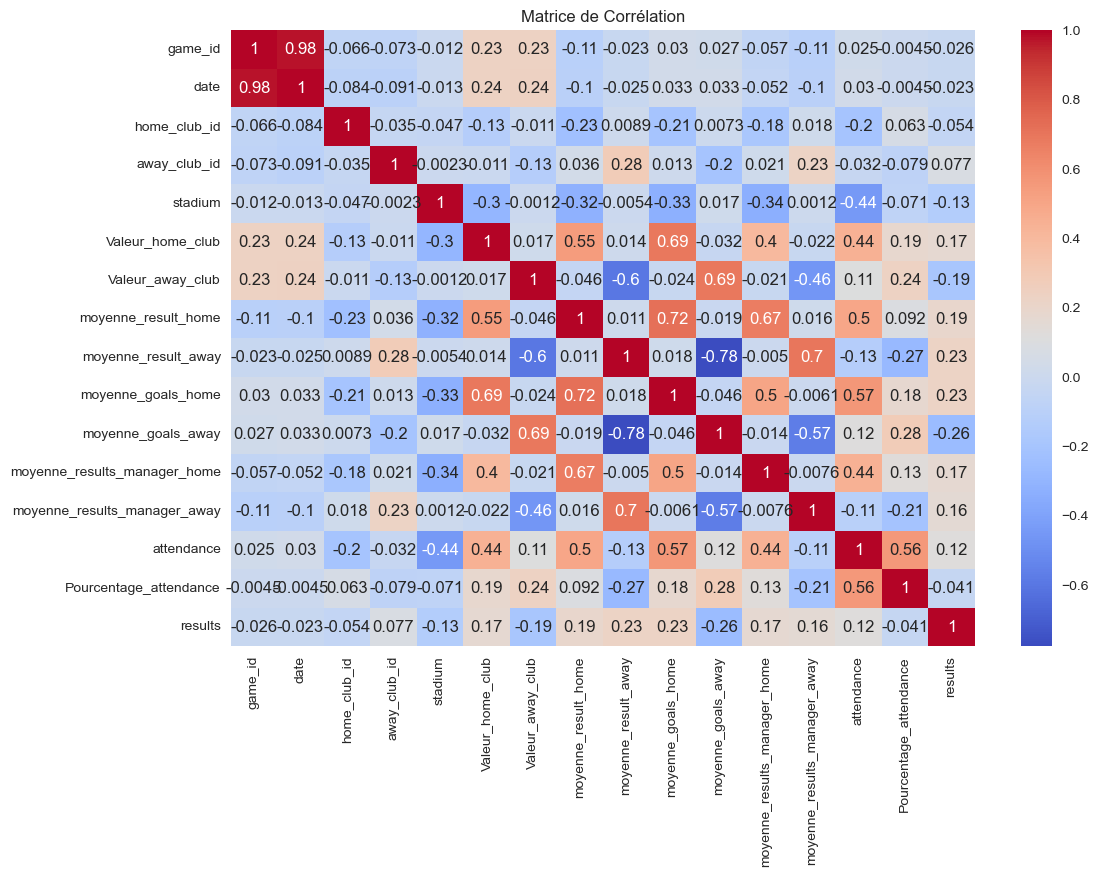

In [7670]:
import matplotlib.pyplot as plt 
import seaborn as sns

corr_matrix = match_2013_2022.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

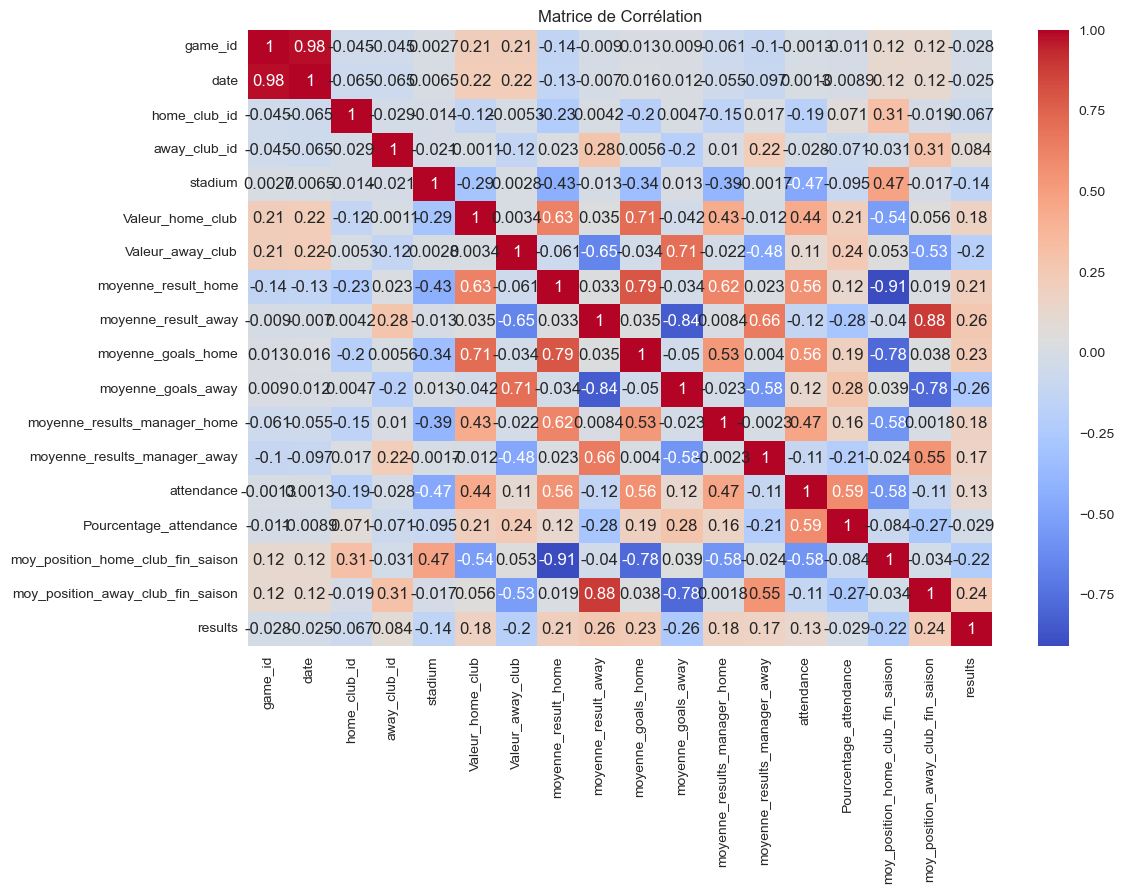

In [7671]:
corr_matrix = match_2013_2022_positions.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()


In [7672]:
!pip install pycaret

In [7673]:
from pycaret.classification import setup, compare_models

In [7674]:
#setup(data=match_2013_2022)

#best_model = compare_models()

In [7675]:
#setup(data=match_2013_2022_positions)

#best_model = compare_models()

In [7676]:
#CREATION DES MODELS (Ridge Classifier & Linear Discriminant Analysis)

In [7677]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, recall_score,f1_score,precision_score, confusion_matrix,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [7678]:
match_2013_2022

game_id  date  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874    94           618           595       20      4.259375e+06   
1     2330880   100         14171           855        7      7.741935e+05   
2     2330916   114          1423          1082       35      1.202273e+06   
3     2331018   132           273         14171        8      1.981034e+06   
4     2331034   142          1147           273       17      8.163043e+05   
...       ...   ...           ...           ...      ...               ...   
3365  2482334   249          1162           618       23      1.030882e+06   
3366  2735509   468           855          1162       38      1.387179e+06   
3367  3199491   779            40           162        4      3.453125e+06   
3368  3047720   678           415           667       39      3.568750e+06   
3369  3199559   795           162           667       21      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
1         6.323529e+05             0.047619             0.750000   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
...                ...                  ...                  ...   
3365      4.324074e+06            -0.400000            -0.152174   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
1               0.063356            0.081161                      0.052632   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
...                  ...                 ...                           ...   
3365            0.065749            0.086698                     -0.333333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      results  
0           0  
1          -1  
2          -1  
3           0  
4           1  
...       ...  
3365        1  
3366       -1  
3367        1  
3368       -1  
3369       -1  

[3370 rows x 16 columns]

In [7679]:
#match_2013_2022_copy = match_2013_2022.copy()
#match_2013_2022_copy.drop("date",axis = 1,inplace = True)
#match_2013_2022_copy

match_2013_2022.drop("date",axis = 1,inplace = True)
match_2013_2022

game_id  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874           618           595       20      4.259375e+06   
1     2330880         14171           855        7      7.741935e+05   
2     2330916          1423          1082       35      1.202273e+06   
3     2331018           273         14171        8      1.981034e+06   
4     2331034          1147           273       17      8.163043e+05   
...       ...           ...           ...      ...               ...   
3365  2482334          1162           618       23      1.030882e+06   
3366  2735509           855          1162       38      1.387179e+06   
3367  3199491            40           162        4      3.453125e+06   
3368  3047720           415           667       39      3.568750e+06   
3369  3199559           162           667       21      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
1         6.323529e+05             0.047619             0.750000   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
...                ...                  ...                  ...   
3365      4.324074e+06            -0.400000            -0.152174   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
1               0.063356            0.081161                      0.052632   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
...                  ...                 ...                           ...   
3365            0.065749            0.086698                     -0.333333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      results  
0           0  
1          -1  
2          -1  
3           0  
4           1  
...       ...  
3365        1  
3366       -1  
3367        1  
3368       -1  
3369       -1  

[3370 rows x 15 columns]

In [7680]:
#match_2013_2022_positions_copy = match_2013_2022_positions.copy()
#match_2013_2022_positions_copy.drop("date",axis = 1,inplace = True)
#match_2013_2022_positions_copy

match_2013_2022_positions.drop("date",axis = 1,inplace = True)
match_2013_2022_positions

game_id  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874           618           595       18      4.259375e+06   
2     2330916          1423          1082       30      1.202273e+06   
3     2331018           273         14171        8      1.981034e+06   
4     2331034          1147           273       15      8.163043e+05   
5     2331094           244           417        5      5.293333e+06   
...       ...           ...           ...      ...               ...   
3364  2331129         14171           595        7      7.964286e+05   
3366  2735509           855          1162       33      1.387179e+06   
3367  3199491            40           162        4      3.453125e+06   
3368  3047720           415           667       34      3.568750e+06   
3369  3199559           162           667       19      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
5         1.897222e+06             0.379310             0.285714   
...                ...                  ...                  ...   
3364      1.039474e+06             0.031250             0.387097   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
5               0.112623            0.088461                      0.600000   
...                  ...                 ...                           ...   
3364            0.067797            0.071111                      0.033333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
5                         0.259259     36083.0                0.535404   
...                            ...         ...                     ...   
3364                      0.392857     11633.0                0.740295   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      moy_position_home_club_fin_saison  moy_position_away_club_fin_saison  \
0                              5.000000                          12.000000   
2                             11.000000                           6.000000   
3                             13.000000                          16.000000   
4                             17.000000                          13.000000   
5                              2.000000                           4.000000   
...                           

In [7681]:
#Declaration du train test pour match_2013_2022


X = match_2013_2022.drop(columns=['results'])  
y = match_2013_2022['results']

# Division des données en ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=32)  # 70% train, 30% test


# Normalisation des fonctionnalités
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [7682]:
#Declaration du train test pour match_2013_2022_positions


X_posi = match_2013_2022_positions.drop(columns=['results'])  
y_posi = match_2013_2022_positions['results']

# Division des données en ensembles de train et de test
X_train_posi, X_test_posi, y_train_posi, y_test_posi = train_test_split(X_posi, y_posi, test_size=0.30, random_state=42)  # 70% train, 30% test


# Normalisation des fonctionnalités
scaler_posi = StandardScaler()
X_train_norm_posi = scaler_posi.fit_transform(X_train_posi)
X_test_norm_posi = scaler_posi.transform(X_test_posi)

In [7683]:
#Les meilleurs parametres ont deja été mis dans le modèle ci dessous

def meilleur_paramettres_ridge_sans_position(X_train, y_train):
    best_score = 0
    best_params = 1
    for i in range(1,3001):
        
        ridgeclassifier = RidgeClassifier(alpha=i)  
        ridgeclassifier.fit(X_train, y_train)
        y_pred = ridgeclassifier.predict(X_test_norm)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy > best_score:
            best_score = accuracy
            best_params = i

    return best_params, best_score



In [7684]:

def meilleur_paramettres_ridge_avec_position(X_train, y_train):
    best_score = 0
    best_params = 1
    for i in range(1,3001):
        
        ridgeclassifier = RidgeClassifier(alpha=i)  
        ridgeclassifier.fit(X_train, y_train)
        y_pred = ridgeclassifier.predict(X_test_norm_posi)
        
        accuracy = accuracy_score(y_test_posi, y_pred)
        
        if accuracy > best_score:
            best_score = accuracy
            best_params = i

    return best_params, best_score



Pour chacuns des modèles suivant nous allons comparer les resultat entre match_2013_2022 comprenant les colonnes relatives au classement et match_2013_2022 sans ces colonnes

In [7685]:
#Ridge Classifier

Accuracy sans position : 0.5222551928783383
Accuracy avec position : 0.5382716049382716
 
Recall sans position : 0.5222551928783383
Recall avec position : 0.5382716049382716
 
F1_score sans position : 0.4325667555400892
F1_score avec position : 0.4531145444463018
 
Precision sans position : 0.5128205509111909
Precision avec position : 0.3959428870600781
 

Matrice de confusion sans position


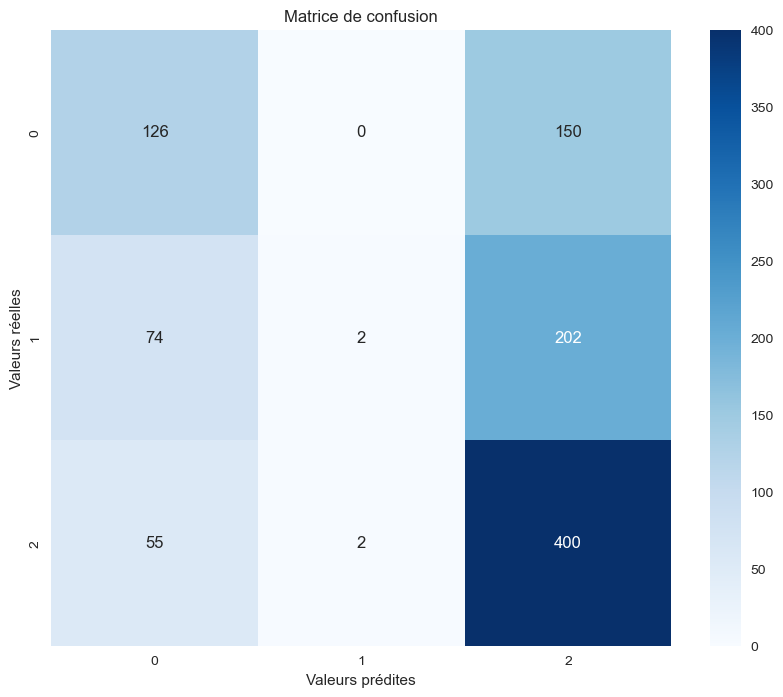


Matrice de confusion avec position


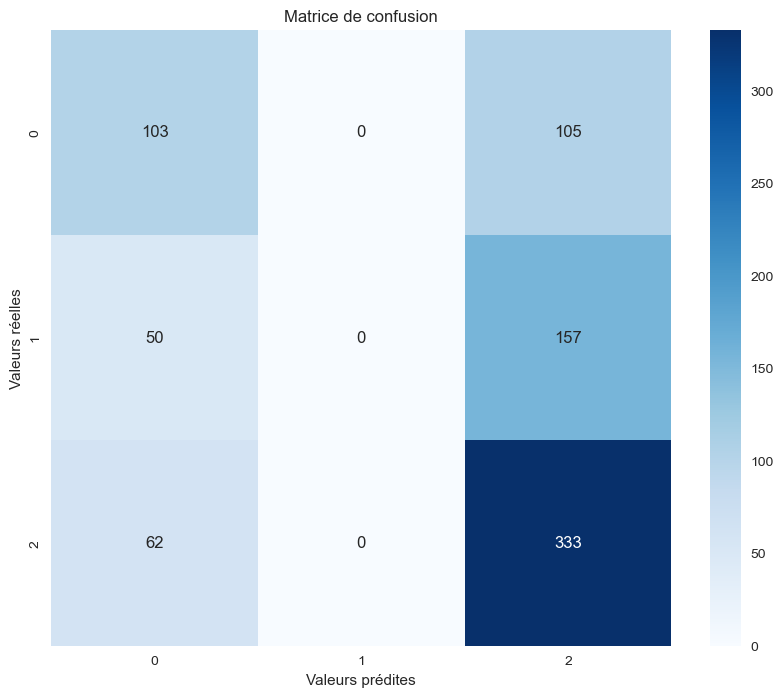

In [7686]:
# Création et entraînement du modèle Ridge Classifier
ridge_classifier = RidgeClassifier(alpha=1) 
ridge_classifier.fit(X_train_norm, y_train)

ridge_classifier_posi = RidgeClassifier(alpha=775) 
ridge_classifier_posi.fit(X_train_norm_posi, y_train_posi)


# Prédiction sur l'ensemble de test
y_pred = ridge_classifier.predict(X_test_norm)
y_pred_posi = ridge_classifier_posi.predict(X_test_norm_posi)


# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sans position :", accuracy)
accuracy = accuracy_score(y_test_posi, y_pred_posi)
print("Accuracy avec position :", accuracy)

print(" ")
# Recall
Recall = recall_score(y_test, y_pred,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall sans position :", Recall)
Recall = recall_score(y_test_posi, y_pred_posi,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall avec position :", Recall)


print(" ")
# F1_score
F1_score = f1_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score sans position :", F1_score)
F1_score = f1_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score avec position :", F1_score)


print(" ")
# Precision
Precision = precision_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision sans position :", Precision)
Precision = precision_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision avec position :", Precision)



print(" ")
# Matrice de confusion


print("\nMatrice de confusion sans position")
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


print("\nMatrice de confusion avec position")
cm = confusion_matrix(y_test_posi, y_pred_posi)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


In [7687]:
# Utilisation de la fonction pour trouver les meilleurs hyperparamètres
best_params, best_score = meilleur_paramettres_ridge_sans_position(X_train_norm, y_train)
print("Meilleurs hyperparamètres:", best_params)
print("Meilleur score d'accuracy:", best_score)


Meilleurs hyperparamètres: 1
Meilleur score d'accuracy: 0.5222551928783383


In [7688]:
# Utilisation de la fonction pour trouver les meilleurs hyperparamètres
best_params, best_score = meilleur_paramettres_ridge_avec_position(X_train_norm_posi, y_train_posi)
print("Meilleurs hyperparamètres:", best_params)
print("Meilleur score d'accuracy:", best_score)


Meilleurs hyperparamètres: 775
Meilleur score d'accuracy: 0.5382716049382716


In [7689]:
#Linear Discriminant Analysis

Accuracy sans position : 0.5192878338278932
Accuracy avec position : 0.5259259259259259
 
Recall sans position : 0.5192878338278932
Recall avec position : 0.5259259259259259
 
F1_score sans position : 0.4330282632146135
F1_score avec position : 0.44889942829780144
 
Precision sans position : 0.46540107015599486
Precision avec position : 0.39342439366080034
 

Matrice de confusion sans position


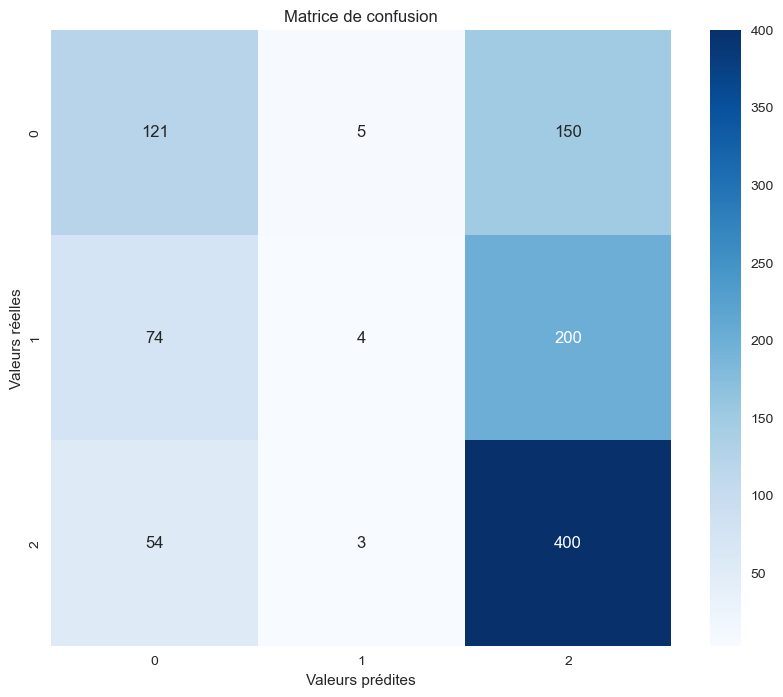


Matrice de confusion avec position


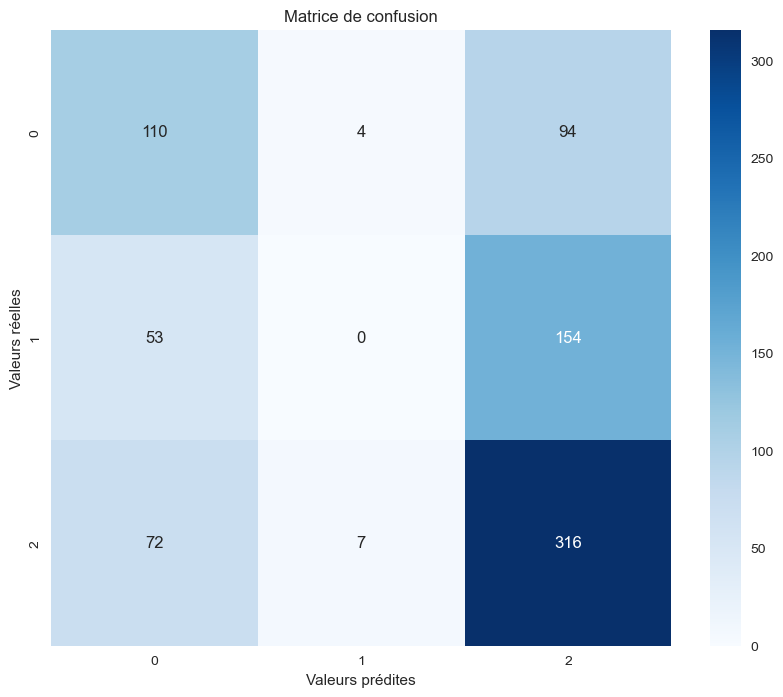

In [7690]:
# Création et entraînement du modèle LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_norm, y_train)

lda_posi = LinearDiscriminantAnalysis()
lda_posi.fit(X_train_norm_posi, y_train_posi)

# Prédiction sur l'ensemble de test
y_pred = lda.predict(X_test_norm)
y_pred_posi = lda_posi.predict(X_test_norm_posi)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sans position :", accuracy)
accuracy = accuracy_score(y_test_posi, y_pred_posi)
print("Accuracy avec position :", accuracy)

print(" ")
# Recall
Recall = recall_score(y_test, y_pred,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall sans position :", Recall)
Recall = recall_score(y_test_posi, y_pred_posi,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall avec position :", Recall)


print(" ")
# F1_score
F1_score = f1_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score sans position :", F1_score)
F1_score = f1_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score avec position :", F1_score)


print(" ")
# Precision
Precision = precision_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision sans position :", Precision)
Precision = precision_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision avec position :", Precision)


print(" ")
# Matrice de confusion


print("\nMatrice de confusion sans position")
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


print("\nMatrice de confusion avec position")
cm = confusion_matrix(y_test_posi, y_pred_posi)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()



In [7691]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier

Accuracy sans position : 0.5113748763600395
Accuracy avec position : 0.5234567901234568
 
Recall sans position : 0.5113748763600395
Recall avec position : 0.5234567901234568
 
F1_score sans position : 0.4598607884799808
F1_score avec position : 0.48320701428273727
 
Precision sans position : 0.46013148910259444
Precision avec position : 0.4742744025219515
 

Matrice de confusion sans position


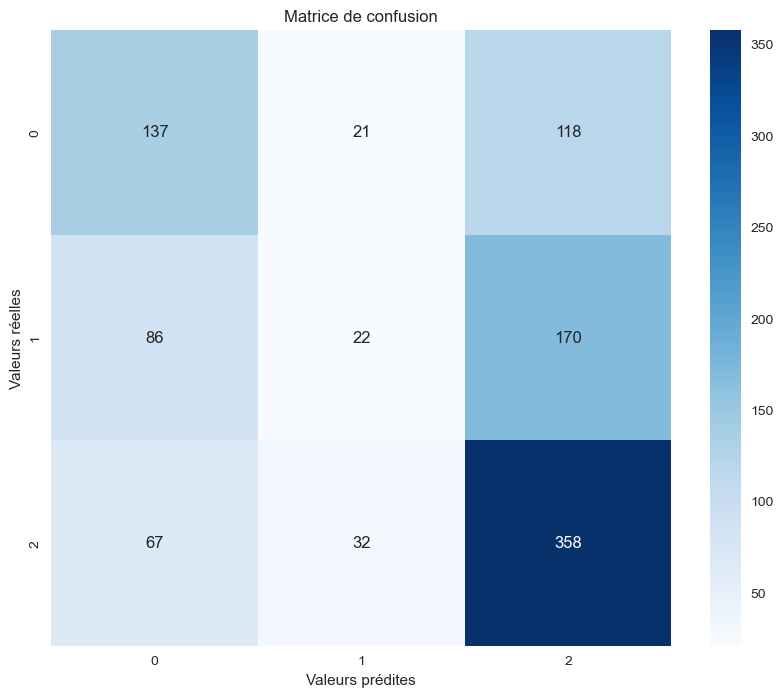


Matrice de confusion avec position


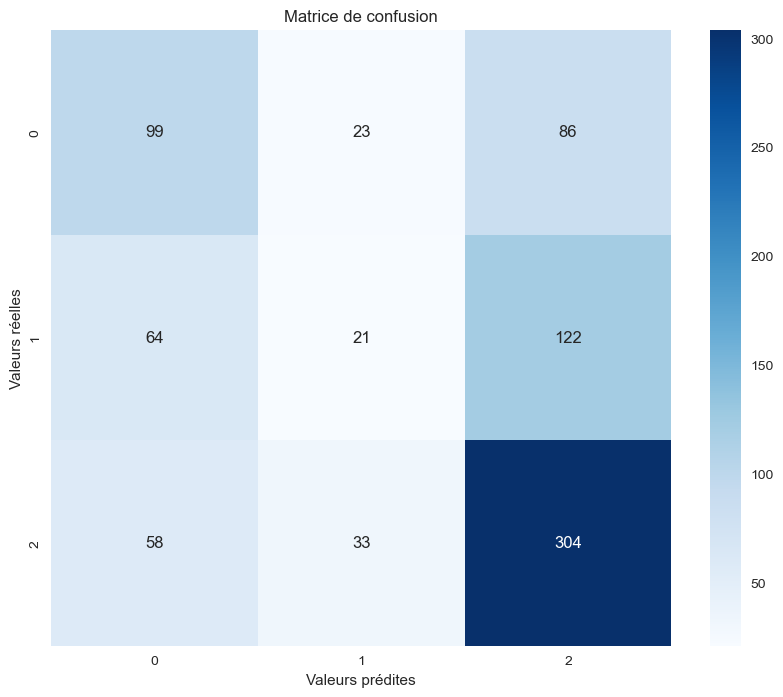

In [7692]:

adaboost = AdaBoostClassifier(n_estimators=55, learning_rate=1.0, random_state=42)
adaboost.fit(X_train_norm, y_train)

adaboost_posi = AdaBoostClassifier(n_estimators=55, learning_rate=1.0, random_state=42)
adaboost_posi.fit(X_train_norm_posi, y_train_posi)

# Prédiction sur l'ensemble de test
y_pred = adaboost.predict(X_test_norm)
y_pred_posi = adaboost_posi.predict(X_test_norm_posi)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sans position :", accuracy)
accuracy = accuracy_score(y_test_posi, y_pred_posi)
print("Accuracy avec position :", accuracy)

print(" ")
# Recall
Recall = recall_score(y_test, y_pred,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall sans position :", Recall)
Recall = recall_score(y_test_posi, y_pred_posi,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall avec position :", Recall)


print(" ")
# F1_score
F1_score = f1_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score sans position :", F1_score)
F1_score = f1_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score avec position :", F1_score)


print(" ")
# Precision
Precision = precision_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision sans position :", Precision)
Precision = precision_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision avec position :", Precision)


print(" ")
# Matrice de confusion


print("\nMatrice de confusion sans position")
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


print("\nMatrice de confusion avec position")
cm = confusion_matrix(y_test_posi, y_pred_posi)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()



Accuracy sans position : 0.49950544015825915
Accuracy avec position : 0.5037037037037037
 
Recall sans position : 0.49950544015825915
Recall avec position : 0.5037037037037037
 
F1_score sans position : 0.46064368531184824
F1_score avec position : 0.4763535896265976
 
Precision sans position : 0.4587579043522267
Precision avec position : 0.47270492256309865
 

Matrice de confusion sans position


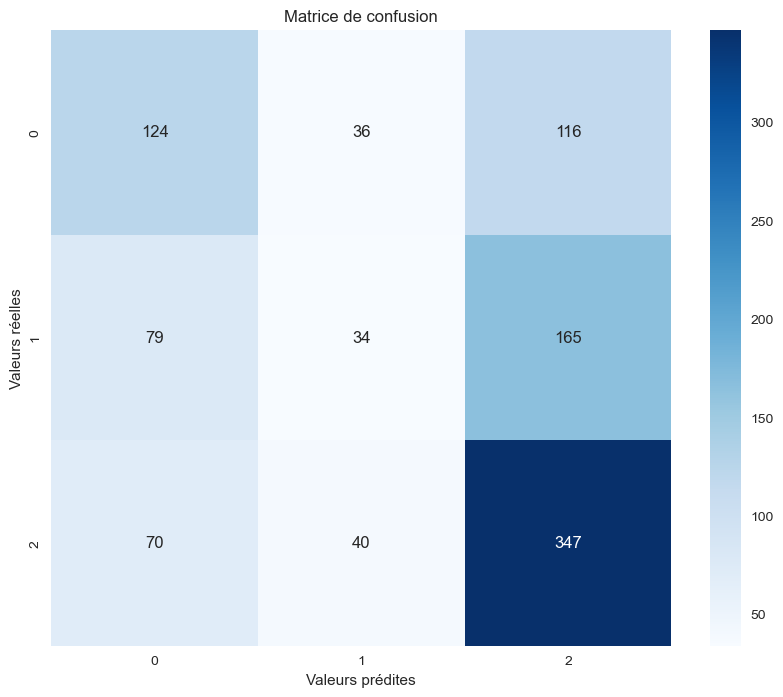


Matrice de confusion avec position


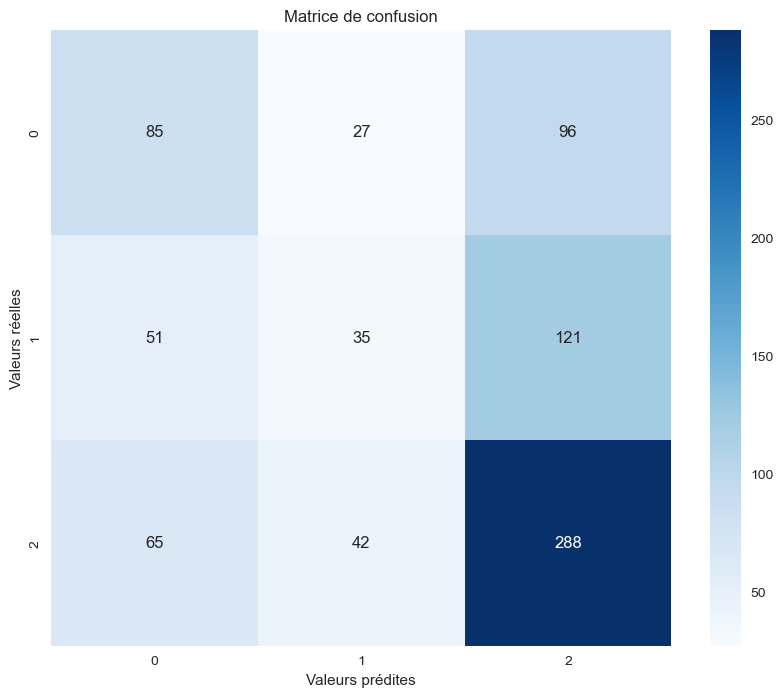

In [7693]:
random_forest = RandomForestClassifier(n_estimators=160, random_state=42)
random_forest.fit(X_train_norm, y_train)

random_forest_posi = RandomForestClassifier(n_estimators=160, random_state=42)
random_forest_posi.fit(X_train_norm_posi, y_train_posi)

# Prédiction sur l'ensemble de test
y_pred = random_forest.predict(X_test_norm)
y_pred_posi = random_forest_posi.predict(X_test_norm_posi)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sans position :", accuracy)
accuracy = accuracy_score(y_test_posi, y_pred_posi)
print("Accuracy avec position :", accuracy)

print(" ")
# Recall
Recall = recall_score(y_test, y_pred,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall sans position :", Recall)
Recall = recall_score(y_test_posi, y_pred_posi,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall avec position :", Recall)


print(" ")
# F1_score
F1_score = f1_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score sans position :", F1_score)
F1_score = f1_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score avec position :", F1_score)


print(" ")
# Precision
Precision = precision_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision sans position :", Precision)
Precision = precision_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision avec position :", Precision)


print(" ")
# Matrice de confusion


print("\nMatrice de confusion sans position")
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


print("\nMatrice de confusion avec position")
cm = confusion_matrix(y_test_posi, y_pred_posi)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()




Accuracy sans position : 0.5182987141444114
Accuracy avec position : 0.5259259259259259
 
Recall sans position : 0.5182987141444114
Recall avec position : 0.5259259259259259
 
F1_score sans position : 0.43018176643232725
F1_score avec position : 0.4480452847082322
 
Precision sans position : 0.5358376226333982
Precision avec position : 0.39160049694809057
 

Matrice de confusion sans position


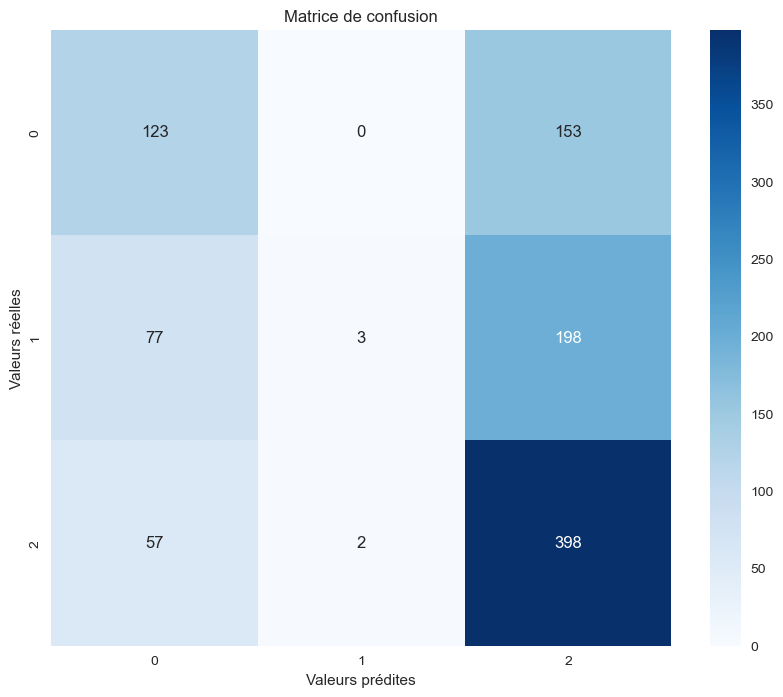


Matrice de confusion avec position


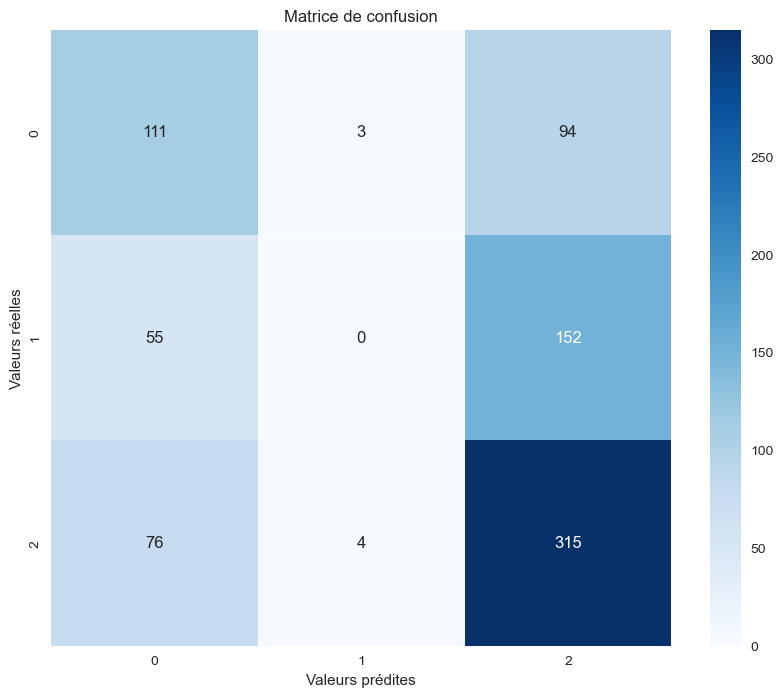

In [7694]:
logistic_regression = LogisticRegression(C=1.0, solver='lbfgs', max_iter=100, random_state=42)
logistic_regression.fit(X_train_norm, y_train)

logistic_regression_posi = LogisticRegression(C=1.0, solver='lbfgs', max_iter=100, random_state=42)
logistic_regression_posi.fit(X_train_norm_posi, y_train_posi)


# Prédiction sur l'ensemble de test
y_pred = logistic_regression.predict(X_test_norm)
y_pred_posi = logistic_regression_posi.predict(X_test_norm_posi)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy sans position :", accuracy)
accuracy = accuracy_score(y_test_posi, y_pred_posi)
print("Accuracy avec position :", accuracy)

print(" ")
# Recall
Recall = recall_score(y_test, y_pred,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall sans position :", Recall)
Recall = recall_score(y_test_posi, y_pred_posi,average='weighted') #average='weighted' car sinon plante parce que pas une classif binaire
print("Recall avec position :", Recall)


print(" ")
# F1_score
F1_score = f1_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score sans position :", F1_score)
F1_score = f1_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("F1_score avec position :", F1_score)


print(" ")
# Precision
Precision = precision_score(y_test, y_pred,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision sans position :", Precision)
Precision = precision_score(y_test_posi, y_pred_posi,average='weighted')#average='weighted' car sinon plante parce que pas une classif binaire
print("Precision avec position :", Precision)


print(" ")
# Matrice de confusion


print("\nMatrice de confusion sans position")
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()


print("\nMatrice de confusion avec position")
cm = confusion_matrix(y_test_posi, y_pred_posi)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()




In [7695]:
#Voting classifier avec :
#Linear Discriminant analysis
#Ada Boost classifier
#Random Forest
#Logistic Regression



voting_clf = VotingClassifier(estimators=[
    ('lda', lda), 
    ("ridge",ridge_classifier),
    ('adaboost', adaboost), 
    ('random_forest', random_forest), 
    ('logistic_regression', logistic_regression)],
    voting='hard')

# Entraîner le Voting Classifier
voting_clf.fit(X_train_norm, y_train)

# Faire des prédictions et évaluer le modèle
y_pred = voting_clf.predict(X_test_norm)
print("Accuracy Voting Classifier: ", accuracy_score(y_test, y_pred) * 100)



voting_clf_posi = VotingClassifier(estimators=[
    ('lda', lda_posi), 
    ("ridge",ridge_classifier_posi),
    ('adaboost', adaboost_posi), 
    ('random_forest', random_forest_posi), 
    ('logistic_regression', logistic_regression_posi)],
    voting='hard')

# Entraîner le Voting Classifier
voting_clf_posi.fit(X_train_norm_posi, y_train_posi)

# Faire des prédictions et évaluer le modèle
y_pred = voting_clf_posi.predict(X_test_norm_posi)
print("Accuracy Voting Classifier avec position : ", accuracy_score(y_test_posi, y_pred) * 100)

Accuracy Voting Classifier:  52.126607319485665
Accuracy Voting Classifier avec position :  52.59259259259259


In [7782]:
#Nous allons donc prendre comme modèle Voting Classifier avec position

# 6) Modification de match_2023 pour faire apparaitre les bonnes features necessaires à la prédiction

In [7700]:
#préparation de match_2023
match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  
0             Franck Haise        Parc des Princes     47000.0  
1            László Bölöni  Stade Bollaert-Delelis     37988.0  
2            Bruno Génésio      Stade de la Mosson     15430.0  
3        Francesco Farioli  Stade Saint-Symphorien     23160.0  
4           Julien Stéphan        Orange Vélodrome     54162.0  
..                     ...                     ...         ...  
265    Michel Der Zakarian            Stade Océane     20556.0  
266      Jean-Louis Gasset       Stadium Municipal     29809.0  
267         Julien Stéphan        Parc des Princes     47874.0  
268      Francesco Farioli       Stadium Municipal     25507.0  
269               Éric Roy      Stade de la Meinau     25140.0  

[270 rows x 8 columns]

In [7701]:
match_2013_2022

game_id  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874           618           595       20      4.259375e+06   
1     2330880         14171           855        7      7.741935e+05   
2     2330916          1423          1082       35      1.202273e+06   
3     2331018           273         14171        8      1.981034e+06   
4     2331034          1147           273       17      8.163043e+05   
...       ...           ...           ...      ...               ...   
3365  2482334          1162           618       23      1.030882e+06   
3366  2735509           855          1162       38      1.387179e+06   
3367  3199491            40           162        4      3.453125e+06   
3368  3047720           415           667       39      3.568750e+06   
3369  3199559           162           667       21      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
1         6.323529e+05             0.047619             0.750000   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
...                ...                  ...                  ...   
3365      4.324074e+06            -0.400000            -0.152174   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
1               0.063356            0.081161                      0.052632   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
...                  ...                 ...                           ...   
3365            0.065749            0.086698                     -0.333333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      results  
0           0  
1          -1  
2          -1  
3           0  
4           1  
...       ...  
3365        1  
3366       -1  
3367        1  
3368       -1  
3369       -1  

[3370 rows x 15 columns]

In [7702]:
#Ajout des valeurs

In [7703]:
player_valuation_before_season_2023 = player_valuation_before_season[
    player_valuation_before_season["id_club"].isin(match_2023["home_club_id"])]
player_valuation_before_season_2023

player_id        date  market_value_in_eur  current_club_id  season  \
6101        5477  2012-08-20              3500000              244    2012   
6102        5645  2012-08-20              5000000              244    2012   
6103       12503  2012-08-20              1750000              417    2012   
6109        3525  2012-08-23              2000000              273    2012   
6112        5348  2012-08-23              3000000             2969    2012   
...          ...         ...                  ...              ...     ...   
30128    1108145  2023-06-27              1000000             3524    2023   
30183     392770  2023-07-12             18000000             1082    2023   
30216      28003  2023-08-22             35000000              583    2023   
30218     111058  2023-08-22              1500000              969    2023   
30220     159098  2023-08-22              1200000              415    2023   

       id_club  
6101     244.0  
6102     244.0  
6103     244.0  
6109     583.0  
6112    1082.0  
...        ...  
30128   3524.0  
30183   1082.0  
30216    583.0  
30218    969.0  
30220    415.0  

[6355 rows x 6 columns]

In [7704]:
match_2023.home_club_id.nunique()

18

In [7705]:
player_valuation_before_season_2023.id_club.nunique()

17

In [7706]:
#on verifie que si on prend seulement les values à partir de 2021 on a bien au moins 1 valeur pour chaques clubs

test = player_valuation_before_season_2023[
    player_valuation_before_season_2023["season"]>=2021]
test.id_club.nunique()

17

In [7707]:
#c'est pas le cas mais ce n'ai pas grave, on fera une moyenne

In [7708]:
player_valuation_before_season_2023 =player_valuation_before_season_2023[
    player_valuation_before_season_2023["season"]>=2021]
player_valuation_before_season_2023

player_id        date  market_value_in_eur  current_club_id  season  \
23123     102558  2021-05-25             55000000              583    2021   
23129     313094  2021-05-25              6000000              417    2021   
23130     315858  2021-05-25             60000000              583    2021   
23132     386726  2021-05-25             20000000             1082    2021   
23134     263918  2021-05-26             28000000              162    2021   
...          ...         ...                  ...              ...     ...   
30128    1108145  2023-06-27              1000000             3524    2023   
30183     392770  2023-07-12             18000000             1082    2023   
30216      28003  2023-08-22             35000000              583    2023   
30218     111058  2023-08-22              1500000              969    2023   
30220     159098  2023-08-22              1200000              415    2023   

       id_club  
23123    583.0  
23129    417.0  
23130    583.0  
23132   1082.0  
23134    162.0  
...        ...  
30128   3524.0  
30183   1082.0  
30216    583.0  
30218    969.0  
30220    415.0  

[2008 rows x 6 columns]

In [7709]:
#renvoie la moyenne de la valeur d'un club à une certaine season
#(moyenne des valeurs des joueurs de ce club à cette season la ou à la season précédente si pas de valeur à la 1ere l'année) 

def recherche_valeur_annee_2023(id_club, date):
    
    season_date = retourn_season_date(date)
    
    ligne = player_valuation_before_season_2023[(player_valuation_before_season_2023['season'] == season_date)
                                           & (player_valuation_before_season_2023['id_club'] == id_club)]
    if not ligne.empty:
        return ligne.market_value_in_eur.mean()
    else:
        ligne = player_valuation_before_season_2023[(player_valuation_before_season_2023['season'] == season_date -1)
                                           & (player_valuation_before_season_2023['id_club'] == id_club)]
        if not ligne.empty:
            return ligne.market_value_in_eur.mean()
        else :
            ligne = player_valuation_before_season_2023[(player_valuation_before_season_2023['season'] == season_date -2)
                                           & (player_valuation_before_season_2023['id_club'] == id_club)]
            if not ligne.empty:
                return ligne.market_value_in_eur.mean()
            else :
                return None


In [7710]:
match_2023['Valeur_home_club'] = match_2023.apply(lambda row: recherche_valeur_annee_2023(row['home_club_id'], row['date']), axis=1)

In [7711]:
match_2023['Valeur_away_club'] = match_2023.apply(lambda row: recherche_valeur_annee_2023(row['away_club_id'], row['date']), axis=1)

In [7712]:
match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  
0        3.894000e+07      8.247619e+06  
1        8.247619e+06      1.740000e+06  
2        4.954348e+06      1.186579e+07  
3        1.740000e+06      1.034444e+07  
4        1.117500e+07      1.186579e+07  
..                ...               ...  
265               NaN      4.954348e+06  
266      2.873810e+06      1.117500e+07  
267      3.894000e+07      1.186579e+07  
268      2.873810e+06      1.034444e+07  
269      3.855556e+06      2.836842e+06  

[270 rows x 10 columns]

In [7713]:
print(nbr_element_null(match_2023))

30


In [7714]:
test = match_2023[match_2023.isna().any(axis=1)]
test

game_id        date  home_club_id  away_club_id home_club_manager_name  \
26   4094585  2023-08-13           969           738    Michel Der Zakarian   
38   4094611  2023-09-03           738          1158            Luka Elsner   
41   4094837  2024-04-14           738           995            Luka Elsner   
48   4094693  2023-11-26           995           738        Pierre Aristouy   
49   4094619  2023-09-17          1041           738  Jean-François Vulliez   
51   4094628  2023-09-24           738          3524            Luka Elsner   
80   4094770  2024-02-17          1082           738          Paulo Fonseca   
82   4094826  2024-04-06           826           738           Franck Haise   
97   4094801  2024-03-10           738           415            Luka Elsner   
98   4094670  2023-11-05           415           738        Carles Martínez   
99   4094594  2023-08-20           738          3911            Luka Elsner   
113  4094640  2023-10-01           738          1082            Luka Elsner   
121  4094737  2024-01-14           738          1041            Luka Elsner   
136  4094682  2023-11-11           738           162            Luka Elsner   
151  4094702  2023-12-03           738           583            Luka Elsner   
170  4094728  2023-12-20          1421           738             Will Still   
172  4094658  2023-10-20           738           826            Luka Elsner   
173  4094720  2023-12-16           738           417            Luka Elsner   
177  4094846  2024-04-21           738           347            Luka Elsner   
191  4094783  2024-02-25           738          1421            Luka Elsner   
206  4094598  2023-08-27           273           738          Bruno Génésio   
210  4094751  2024-02-04           162           738             Adi Hütter   
214  4094793  2024-03-03          3911           738               Éric Roy   
215  4094705  2023-12-10           667           738         Patrick Vieira   
234  4094643  2023-10-08           244           738        Gennaro Gattuso   
236  4094665  2023-10-29           347           738          László Bölöni   
259  4094743  2024-01-28          1158           738          Régis Le Bris   
260  4094806  2024-03-17          3524           738         Pascal Gastien   
262  4094765  2024-02-11           738           273            Luka Elsner   
265  4094819  2024-03-31           738           969            Luka Elsner   

    away_club_manager_name                              stadium  attendance  \
26             Luka Elsner                   Stade de la Mosson     15852.0   
38           Régis Le Bris                         Stade Océane     18707.0   
41       Antoine Kombouaré                         Stade Océane     23021.0   
48             Luka Elsner                Stade de la Beaujoire     29346.0   
49             Luka Elsner                     Groupama Stadium     35507.0   
51          Pascal Gastien                         Stade Océane     18071.0   
80             Luka Elsner  Decathlon Arena-Stade Pierre-Mauroy     40317.0   
82             Luka Elsner               Stade Bollaert-Delelis     38223.0   
97         Carles Martínez                         Stade Océane     21462.0   
98             Luka Elsner                    Stadium Municipal     23060.0   
99                Éric Roy                         Stade Océane     19574.0   
113          Paulo Fonseca                         Stade Océane     21919.0   
121            Pierre Sage                         Stade Océane     23146.0   
136             Adi Hütter                         Stade Océane     23008.0   
151           Luis Enrique                         Stade Océane     24569.0   
170            Luka Elsner                Stade Auguste-Delaune     14835.0   
172           Franck Haise                         Stade Océane     23590.0   
173      Francesco Farioli                         Stade Océane     21971.0   
177          László Bölöni                         Sta

In [7715]:
#On remarque que le club 738 ne semble pas avoir d'information de valeur, nous pouvons
#vérifier si dans la dataframe player_valuation_before_season il y a des infos que le club 738

player_valuation_before_season_2023_V2 = player_valuation_before_season[
    player_valuation_before_season["id_club"].isin(match_2023["home_club_id"])]

player_valuation_before_season_2023_V2 = player_valuation_before_season_2023_V2[player_valuation_before_season_2023_V2["id_club"]==738]
player_valuation_before_season_2023_V2

Empty DataFrame
Columns: [player_id, date, market_value_in_eur, current_club_id, season, id_club]
Index: []

In [7716]:
#Ce n'est pas le cas mais ce n'est pas grave, nous allons remplacer les NAN values par les moyenne des colonnes

In [7717]:
moyenne_valeur_home = match_2023["Valeur_home_club"].mean()
moyenne_valeur_away = match_2023["Valeur_away_club"].mean()

print(moyenne_valeur_home)
print(moyenne_valeur_away)

8619491.410723379
8596614.405375786


In [7718]:
match_2023["Valeur_home_club"] = match_2023["Valeur_home_club"].fillna(moyenne_valeur_home)
match_2023["Valeur_away_club"] = match_2023["Valeur_away_club"].fillna(moyenne_valeur_away)

match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  
0        3.894000e+07      8.247619e+06  
1        8.247619e+06      1.740000e+06  
2        4.954348e+06      1.186579e+07  
3        1.740000e+06      1.034444e+07  
4        1.117500e+07      1.186579e+07  
..                ...               ...  
265      8.619491e+06      4.954348e+06  
266      2.873810e+06      1.117500e+07  
267      3.894000e+07      1.186579e+07  
268      2.873810e+06      1.034444e+07  
269      3.855556e+06      2.836842e+06  

[270 rows x 10 columns]

In [7719]:
print(nbr_element_null(match_2023))

0


In [7720]:
#Ajout des moyenne results

In [7721]:
match_2013_2022

game_id  home_club_id  away_club_id  stadium  Valeur_home_club  \
0     2330874           618           595       20      4.259375e+06   
1     2330880         14171           855        7      7.741935e+05   
2     2330916          1423          1082       35      1.202273e+06   
3     2331018           273         14171        8      1.981034e+06   
4     2331034          1147           273       17      8.163043e+05   
...       ...           ...           ...      ...               ...   
3365  2482334          1162           618       23      1.030882e+06   
3366  2735509           855          1162       38      1.387179e+06   
3367  3199491            40           162        4      3.453125e+06   
3368  3047720           415           667       39      3.568750e+06   
3369  3199559           162           667       21      1.260938e+07   

      Valeur_away_club  moyenne_result_home  moyenne_result_away  \
0         1.034615e+06             0.444444             0.315789   
1         6.323529e+05             0.047619             0.750000   
2         3.790625e+06             0.045455            -0.238095   
3         7.964286e+05            -0.150000             0.520000   
4         2.015000e+06            -0.214286             0.400000   
...                ...                  ...                  ...   
3365      4.324074e+06            -0.400000            -0.152174   
3366      1.334000e+06             0.089552             0.265306   
3367      1.338235e+07             0.230769            -0.216667   
3368      2.725000e+06             0.042017             0.392857   
3369      3.619643e+06             0.419355             0.333333   

      moyenne_goals_home  moyenne_goals_away  moyenne_results_manager_home  \
0               0.087428            0.063053                      0.500000   
1               0.063356            0.081161                      0.052632   
2               0.077039            0.092597                     -0.500000   
3               0.093668            0.056911                      0.100000   
4               0.055468            0.093772                     -0.600000   
...                  ...                 ...                           ...   
3365            0.065749            0.086698                     -0.333333   
3366            0.077898            0.071429                      0.035714   
3367            0.086783            0.119327                     -0.181818   
3368            0.074803            0.091062                      0.000000   
3369            0.118576            0.098830                     -1.000000   

      moyenne_results_manager_away  attendance  Pourcentage_attendance  \
0                         0.312500     31952.0                0.760762   
1                         0.666667      8620.0                0.548555   
2                         0.266667     14874.0                0.590895   
3                         0.478261     13391.0                0.449694   
4                         0.363636      5981.0                0.572564   
...                            ...         ...                     ...   
3365                     -0.113636     19432.0                0.950081   
3366                      0.291667     14428.0                0.758052   
3367                     -0.212766     34554.0                0.820468   
3368                      0.377778     15465.0                0.466516   
3369                      0.338462      4800.0                0.293399   

      results  
0           0  
1          -1  
2          -1  
3           0  
4           1  
...       ...  
3365        1  
3366       -1  
3367        1  
3368       -1  
3369       -1  

[3370 rows x 15 columns]

In [7722]:
#Pour chaque match de 2023, on va prendre on va prendre la dernière valeur de moyenne results de match_2013_2022

L = []

for i in range(0,len(match_2023)):
    
    for j in range(len(match_2013_2022)-1,-1,-1):
        
        if match_2013_2022.loc[j,"home_club_id"] == match_2023.loc[i,"home_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_result_home"])
            break
            
        elif match_2013_2022.loc[j,"away_club_id"] == match_2023.loc[i,"home_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_result_away"])
            break
            
    if j == 0 :
        L.append(None)
            
match_2023["moyenne_result_home"] = L

match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  
0        3.894000e+07      8.247619e+06            -0.484536  
1        8.247619e+06      1.740000e+06             0.129032  
2        4.954348e+06      1.186579e+07             0.106952  
3        1.740000e+06      1.034444e+07             0.520000  
4        1.117500e+07      1.186579e+07             0.351064  
..                ...               ...                  ...  
265      8.619491e+06      4.954348e+06                  NaN  
266      2.873810e+06      1.117500e+07             0.042017  
267      3.894000e+07      1.186579e+07            -0.484536  
268      2.873810e+06      1.034444e+07             0.042017  
269      3.855556e+06      2.836842e+06             0.333333  

[270 rows x 11 columns]

In [7723]:
L = []

for i in range(0,len(match_2023)):
    
    for j in range(len(match_2013_2022)-1,-1,-1):
        
        if match_2013_2022.loc[j,"home_club_id"] == match_2023.loc[i,"away_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_result_home"])
            break
            
        elif match_2013_2022.loc[j,"away_club_id"] == match_2023.loc[i,"away_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_result_away"])
            break
            
    if j == 0 :
        L.append(None)
            
match_2023["moyenne_result_away"] = L

match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06                  NaN   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  
0               0.129032  
1               0.520000  
2               0.091892  
3               0.000000  
4               0.091892  
..                   ...  
265             0.106952  
266             0.351064  
267             0.091892  
268             0.000000  
269            -0.094595  

[270 rows x 12 columns]

In [7724]:
print(nbr_element_null(match_2023))

30


In [7725]:
#Pareil que pour les valeurs, nous allons remplacer les NAN values par la moyenne

In [7726]:
moyenne_results_home = match_2023["moyenne_result_home"].mean()
moyenne_results_away = match_2023["moyenne_result_away"].mean()

print(moyenne_results_home)
print(moyenne_results_away)

match_2023["moyenne_result_home"] = match_2023["moyenne_result_home"].fillna(moyenne_results_home)
match_2023["moyenne_result_away"] = match_2023["moyenne_result_away"].fillna(moyenne_results_away)

match_2023

0.16459503148965177
0.1671651672362581


game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  
0               0.129032  
1               0.520000  
2               0.091892  
3               0.000000  
4               0.091892  
..                   ...  
265             0.106952  
266             0.351064  
267             0.091892  
268             0.000000  
269            -0.094595  

[270 rows x 12 columns]

In [7727]:
print(nbr_element_null(match_2023))

0


In [7728]:
#Moyenne des goals

In [7729]:
#Pour chaque match de 2023, on va prendre on va prendre la dernière valeur de moyenne goals de match_2013_2022

L = []

for i in range(0,len(match_2023)):
    
    for j in range(len(match_2013_2022)-1,-1,-1):
        
        if match_2013_2022.loc[j,"home_club_id"] == match_2023.loc[i,"home_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_goals_home"])
            break
            
        elif match_2013_2022.loc[j,"away_club_id"] == match_2023.loc[i,"home_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_goals_away"])
            break
            
    if j == 0 :
        L.append(None)
            
match_2023["moyenne_goals_home"] = L


In [7730]:
L = []

for i in range(0,len(match_2023)):
    
    for j in range(len(match_2013_2022)-1,-1,-1):
        
        if match_2013_2022.loc[j,"home_club_id"] == match_2023.loc[i,"away_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_goals_home"])
            break
            
        elif match_2013_2022.loc[j,"away_club_id"] == match_2023.loc[i,"away_club_id"] :
            
            L.append(match_2013_2022.loc[j,"moyenne_goals_away"])
            break
            
    if j == 0 :
        L.append(None)
            
match_2023["moyenne_goals_away"] = L

match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  
0               0.129032            0.171429            0.093239  
1               0.520000            0.093239            0.065795  
2               0.091892            0.104418            0.093946  
3               0.000000            0.065795            0.088030  
4               0.091892            0.107710            0.093946  
..                   ...                 ...                 ...  
265             0.106952                 NaN            0.104418  
266             0.351064            0.074803            0.107710  
267             0.091892            0.171429            0.093946  
268             0.000000            0.074803            0.088030  
269            -0.094595            0.098830            0.076271  

[270 rows x 14 columns]

In [7731]:
print(nbr_element_null(match_2023))

30


In [7732]:
moyenne_goals_home = match_2023["moyenne_goals_home"].mean()
moyenne_goals_away = match_2023["moyenne_goals_away"].mean()

print(moyenne_goals_home)
print(moyenne_goals_away)

match_2023["moyenne_goals_home"] = match_2023["moyenne_goals_home"].fillna(moyenne_goals_home)
match_2023["moyenne_goals_away"] = match_2023["moyenne_goals_away"].fillna(moyenne_goals_away)

match_2023

0.0945060284114217
0.09441600338465629


game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  
0               0.129032            0.171429            0.093239  
1               0.520000            0.093239            0.065795  
2               0.091892            0.104418            0.093946  
3               0.000000            0.065795            0.088030  
4               0.091892            0.107710            0.093946  
..                   ...                 ...                 ...  
265             0.106952            0.094506            0.104418  
266             0.351064            0.074803            0.107710  
267             0.091892            0.171429            0.093946  
268             0.000000            0.074803            0.088030  
269            -0.094595            0.098830            0.076271  

[270 rows x 14 columns]

In [7733]:
print(nbr_element_null(match_2023))

0


In [7734]:
#Moyenne des results manager

In [7735]:
#home correspond à la dataframe qu'on avait créé lors de la creation des colonnes moyenne_results_manager dans
#match_2013_2022
#Home comporte donc les moyenne_results_manager_home et les nom des manager (ce qui nous interresse car en ayant
#drop les nom dans match_2013_2022 nous n'avons plus accès à eux)

home

game_id        date home_club_manager_name  results  \
0     2330874  2013-09-28     Christophe Galtier        0   
1     2330880  2013-10-19          Pascal Dupraz       -1   
2     2330916  2013-11-30           Ariel Jacobs       -1   
3     2331018  2014-01-18     Philippe Montanier        0   
4     2331034  2014-02-08     Christian Bracconi        1   
...       ...         ...                    ...      ...   
3972  3199491  2019-11-24            Paulo Sousa        1   
3973  3394982  2021-05-09         Thierry Laurey       -1   
3974  3047720  2019-01-13         Alain Casanova       -1   
3975  3199559  2020-01-25          Robert Moreno       -1   
3976  3394685  2020-12-06      Jean-Louis Gasset        1   

      moyenne_results_manager_home  
0                         0.500000  
1                         0.052632  
2                        -0.500000  
3                         0.100000  
4                        -0.600000  
...                            ...  
3972                     -0.181818  
3973                     -0.011765  
3974                      0.000000  
3975                     -1.000000  
3976                      0.279070  

[3924 rows x 5 columns]

In [7736]:
home = home[home['game_id'].isin(match_2013_2022["game_id"])]
home.reset_index(drop=True,inplace=True)
home

game_id        date home_club_manager_name  results  \
0     2330874  2013-09-28     Christophe Galtier        0   
1     2330880  2013-10-19          Pascal Dupraz       -1   
2     2330916  2013-11-30           Ariel Jacobs       -1   
3     2331018  2014-01-18     Philippe Montanier        0   
4     2331034  2014-02-08     Christian Bracconi        1   
...       ...         ...                    ...      ...   
3365  2482334  2015-02-01        Patrice Garande        1   
3366  2735509  2017-02-04      Antoine Kombouaré       -1   
3367  3199491  2019-11-24            Paulo Sousa        1   
3368  3047720  2019-01-13         Alain Casanova       -1   
3369  3199559  2020-01-25          Robert Moreno       -1   

      moyenne_results_manager_home  
0                         0.500000  
1                         0.052632  
2                        -0.500000  
3                         0.100000  
4                        -0.600000  
...                            ...  
3365                     -0.333333  
3366                      0.035714  
3367                     -0.181818  
3368                      0.000000  
3369                     -1.000000  

[3370 rows x 5 columns]

In [7737]:
#Pareil pour away

away = away[away['game_id'].isin(match_2013_2022["game_id"])]
away.reset_index(drop=True,inplace=True)
away

game_id        date away_club_manager_name  results  \
0     2330874  2013-09-28         Frédéric Hantz        0   
1     2330880  2013-10-19     Jocelyn Gourvennec       -1   
2     2330916  2013-11-30            René Girard       -1   
3     2331018  2014-01-18          Pascal Dupraz        0   
4     2331034  2014-02-08     Philippe Montanier        1   
...       ...         ...                    ...      ...   
3365  2482334  2015-02-01     Christophe Galtier        1   
3366  2735509  2017-02-04        Patrice Garande       -1   
3367  3199491  2019-11-24        Leonardo Jardim        1   
3368  3047720  2019-01-13         Thierry Laurey       -1   
3369  3199559  2020-01-25         Thierry Laurey       -1   

      moyenne_results_manager_away  
0                         0.312500  
1                         0.666667  
2                         0.266667  
3                         0.478261  
4                         0.363636  
...                            ...  
3365                     -0.113636  
3366                      0.291667  
3367                     -0.212766  
3368                      0.377778  
3369                      0.338462  

[3370 rows x 5 columns]

In [7738]:
#Pour chaque match de 2023, on va prendre on va prendre la dernière valeur de moyenne_results_manager de home

L = []

for i in range(0,len(match_2023)):
    
    for j in range(len(home)-1,-1,-1):
        
        if home.loc[j,"home_club_manager_name"] == match_2023.loc[i,"home_club_manager_name"] :
            
            L.append(home.loc[j,"moyenne_results_manager_home"])
            break
            
        elif away.loc[j,"away_club_manager_name"] == match_2023.loc[i,"home_club_manager_name"] :
            
            L.append(away.loc[j,"moyenne_results_manager_away"])
            break
            
    if j == 0 :
        L.append(None)
            
match_2023["moyenne_results_manager_home"] = L

In [7739]:
L = []

for i in range(0,len(match_2023)):
    
    for j in range(len(home)-1,-1,-1):
        
        if home.loc[j,"home_club_manager_name"] == match_2023.loc[i,"away_club_manager_name"] :
            
            L.append(home.loc[j,"moyenne_results_manager_home"])
            break
            
        elif away.loc[j,"away_club_manager_name"] == match_2023.loc[i,"away_club_manager_name"] :
            
            L.append(away.loc[j,"moyenne_results_manager_away"])
            break
            
    if j == 0 :
        L.append(None)
            
match_2023["moyenne_results_manager_away"] = L

match_2023

game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  
0                             NaN                     -0.045455  
1                       -0.045455                           NaN  
2                        0.073333                     -0.060000  
3                             NaN                           NaN  
4                             NaN                      0.293103  
..                            ...                           ...  
265                      0.000000                      0.073333  
266                           NaN                     -0.222222  
267                           NaN                      0.293103  
268              

In [7740]:
#on voit qu'il y a enormement de NAN values pour ces deux colonnes
#Ceci est du au fait que dans data_manager (dataframe ayant donnée lieu à home et away), il n'y a pas des infos
#pour tous les manager de match_2023

#Preuve :

In [7741]:
match_2023.home_club_manager_name.nunique() #nombre de manager differents dans match_2023

26

In [7742]:
data_manager.home_club_manager_name.nunique() #nombre de manager differents dans data_manager

126

In [7743]:
#dataframe prenant toutes les lignes de data_manager ayant des infos sur les managers de match_2023

df = data_manager[data_manager.home_club_manager_name.isin(match_2023.home_club_manager_name)]
df

game_id        date home_club_manager_name away_club_manager_name  \
13    2482243  2014-11-23    Michel Der Zakarian     Christophe Galtier   
15    2482268  2014-12-07      Antoine Kombouaré            René Girard   
18    2482373  2015-02-28      Antoine Kombouaré     Philippe Montanier   
20    2586769  2015-08-08    Michel Der Zakarian     Jocelyn Gourvennec   
21    2586780  2015-08-15     Jocelyn Gourvennec        Hubert Fournier   
...       ...         ...                    ...                    ...   
3955  3840228  2023-03-11               Éric Roy     Christophe Galtier   
3957  3839781  2022-08-14    Michel Der Zakarian             Igor Tudor   
3962  3589589  2022-05-14         Julien Stéphan         Pascal Gastien   
3971  2735509  2017-02-04      Antoine Kombouaré        Patrice Garande   
3976  3394685  2020-12-06      Jean-Louis Gasset     Olivier Dall'Oglio   

      results  
13          0  
15          0  
18         -1  
20          1  
21         -1  
...       ...  
3955       -1  
3957        0  
3962        1  
3971       -1  
3976        1  

[911 rows x 5 columns]

In [7744]:
df.home_club_manager_name.nunique() #Nous n'avons que des infos sur 16 managers sur 26 au total (c'est très peu)

16

In [7745]:
#Pour l'instant nous combler ces Nan values avec les moyennes des colonnes, cependant si au final on estime que 
#ces NAN values était trop importante, nous deciderons de drop les colonnes moyenne_results_manager de match_2013_2022
#et match_2023

In [7746]:
moyenne_results_manager_home = match_2023["moyenne_results_manager_home"].mean()
moyenne_results_manager_away = match_2023["moyenne_results_manager_away"].mean()

print(moyenne_results_manager_home)
print(moyenne_results_manager_away)

match_2023["moyenne_results_manager_home"] = match_2023["moyenne_results_manager_home"].fillna(moyenne_results_manager_home)
match_2023["moyenne_results_manager_away"] = match_2023["moyenne_results_manager_away"].fillna(moyenne_results_manager_away)

match_2023

0.04407187163461045
0.05266609108453757


game_id        date  home_club_id  away_club_id home_club_manager_name  \
0    4094596  2023-08-26           583           826           Luis Enrique   
1    4094622  2023-09-16           826           347           Franck Haise   
2    4094630  2023-09-24           969           273    Michel Der Zakarian   
3    4094647  2023-10-07           347           417          László Bölöni   
4    4094696  2023-12-03           244           273        Gennaro Gattuso   
..       ...         ...           ...           ...                    ...   
265  4094819  2024-03-31           738           969            Luka Elsner   
266  4094840  2024-04-21           415           244        Carles Martínez   
267  4094776  2024-02-25           583           273           Luis Enrique   
268  4094786  2024-03-03           415           417        Carles Martínez   
269  4094777  2024-02-24           667          3911         Patrick Vieira   

    away_club_manager_name                 stadium  attendance  \
0             Franck Haise        Parc des Princes     47000.0   
1            László Bölöni  Stade Bollaert-Delelis     37988.0   
2            Bruno Génésio      Stade de la Mosson     15430.0   
3        Francesco Farioli  Stade Saint-Symphorien     23160.0   
4           Julien Stéphan        Orange Vélodrome     54162.0   
..                     ...                     ...         ...   
265    Michel Der Zakarian            Stade Océane     20556.0   
266      Jean-Louis Gasset       Stadium Municipal     29809.0   
267         Julien Stéphan        Parc des Princes     47874.0   
268      Francesco Farioli       Stadium Municipal     25507.0   
269               Éric Roy      Stade de la Meinau     25140.0   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  
0                        0.044072                     -0.045455  
1                       -0.045455                      0.052666  
2                        0.073333                     -0.060000  
3                        0.044072                      0.052666  
4                        0.044072                      0.293103  
..                            ...                           ...  
265                      0.000000                      0.073333  
266                      0.044072                     -0.222222  
267                      0.044072                      0.293103  
268              

In [7747]:
match_2023.drop("home_club_manager_name",axis = 1,inplace = True)
match_2023.drop("away_club_manager_name",axis = 1,inplace = True)
match_2023

game_id        date  home_club_id  away_club_id                 stadium  \
0    4094596  2023-08-26           583           826        Parc des Princes   
1    4094622  2023-09-16           826           347  Stade Bollaert-Delelis   
2    4094630  2023-09-24           969           273      Stade de la Mosson   
3    4094647  2023-10-07           347           417  Stade Saint-Symphorien   
4    4094696  2023-12-03           244           273        Orange Vélodrome   
..       ...         ...           ...           ...                     ...   
265  4094819  2024-03-31           738           969            Stade Océane   
266  4094840  2024-04-21           415           244       Stadium Municipal   
267  4094776  2024-02-25           583           273        Parc des Princes   
268  4094786  2024-03-03           415           417       Stadium Municipal   
269  4094777  2024-02-24           667          3911      Stade de la Meinau   

     attendance  Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0       47000.0      3.894000e+07      8.247619e+06            -0.484536   
1       37988.0      8.247619e+06      1.740000e+06             0.129032   
2       15430.0      4.954348e+06      1.186579e+07             0.106952   
3       23160.0      1.740000e+06      1.034444e+07             0.520000   
4       54162.0      1.117500e+07      1.186579e+07             0.351064   
..          ...               ...               ...                  ...   
265     20556.0      8.619491e+06      4.954348e+06             0.164595   
266     29809.0      2.873810e+06      1.117500e+07             0.042017   
267     47874.0      3.894000e+07      1.186579e+07            -0.484536   
268     25507.0      2.873810e+06      1.034444e+07             0.042017   
269     25140.0      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  
0                        0.044072                     -0.045455  
1                       -0.045455                      0.052666  
2                        0.073333                     -0.060000  
3                        0.044072                      0.052666  
4                        0.044072                      0.293103  
..                            ...                           ...  
265                      0.000000                      0.073333  
266                      0.044072                     -0.222222  
267                      0.044072                      0.293103  
268                      0.044072                      0.052666  
269                      0.090909                      0.000000  

[270 rows x 14 columns]

In [7748]:
print(nbr_element_null(match_2023))

0


In [7749]:
#Placement de attendance à la fin et faire Pourcentage attendance

In [7750]:
attendance = match_2023.pop("attendance")

match_2023.insert(len(match_2023.columns),attendance.name,attendance)

match_2023

game_id        date  home_club_id  away_club_id                 stadium  \
0    4094596  2023-08-26           583           826        Parc des Princes   
1    4094622  2023-09-16           826           347  Stade Bollaert-Delelis   
2    4094630  2023-09-24           969           273      Stade de la Mosson   
3    4094647  2023-10-07           347           417  Stade Saint-Symphorien   
4    4094696  2023-12-03           244           273        Orange Vélodrome   
..       ...         ...           ...           ...                     ...   
265  4094819  2024-03-31           738           969            Stade Océane   
266  4094840  2024-04-21           415           244       Stadium Municipal   
267  4094776  2024-02-25           583           273        Parc des Princes   
268  4094786  2024-03-03           415           417       Stadium Municipal   
269  4094777  2024-02-24           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  
0                        0.044072                     -0.045455     47000.0  
1                       -0.045455                      0.052666     37988.0  
2                        0.073333                     -0.060000     15430.0  
3                        0.044072                      0.052666     23160.0  
4                        0.044072                      0.293103     54162.0  
..                            ...                           ...         ...  
265                      0.000000                      0.073333     20556.0  
266                      0.044072                     -0.222222     29809.0  
267                      0.044072                      0.293103     47874.0  
268                      0.044072                      0.052666     25507.0  
269                      0.090909                      0.000000     25140.0  

[270 rows x 14 columns]

In [7751]:
match_2023.stadium.unique()

array(['Parc des Princes', 'Stade Bollaert-Delelis', 'Stade de la Mosson',
       'Stade Saint-Symphorien', 'Orange Vélodrome', 'Roazhon Park',
       'Stade Louis-II', 'Stade de la Meinau', 'Allianz Riviera',
       'Stade Francis-Le Blé', 'Stade Gabriel-Montpied',
       'Decathlon Arena-Stade Pierre-Mauroy', 'Groupama Stadium',
       'Stade Auguste-Delaune', 'Stadium Municipal', 'Stade Océane',
       'Stade du Moustoir', 'Stade de la Beaujoire'], dtype=object)

In [7752]:
stadiums = {
    'Parc des Princes': 47929,
    'Stade Bollaert-Delelis': 38058,
    'Stade de la Mosson': 22000,
    'Stade Saint-Symphorien': 25636,
    'Orange Vélodrome': 67394,
    'Roazhon Park': 29778,
    'Stade Louis-II': 16360,
    'Stade de la Meinau': 29320,
    'Allianz Riviera': 36178,
    'Stade Francis-Le Blé': 15097,
    'Stade Gabriel-Montpied': 11980,
    'Decathlon Arena-Stade Pierre-Mauroy': 50186,
    'Groupama Stadium': 59186,
    'Stade Auguste-Delaune': 21684,
    'Stadium Municipal': 33150,
    'Stade Océane': 25181,
    'Stade du Moustoir': 18110,
    'Stade de la Beaujoire': 35322
}


In [7753]:
#Nous allons créer la colonne représentant le pourcentage de remplissage d'un stade en fonction
#de sa capacité et de l'attendance

L = []

for i in range(len(match_2023)):
    pourcentage = ( (match_2023.loc[i,"attendance"]) / (stadiums[match_2023.loc[i,"stadium"]]) )
    L.append(pourcentage)
    
match_2023["Pourcentage_attendance"] = L

match_2023

game_id        date  home_club_id  away_club_id                 stadium  \
0    4094596  2023-08-26           583           826        Parc des Princes   
1    4094622  2023-09-16           826           347  Stade Bollaert-Delelis   
2    4094630  2023-09-24           969           273      Stade de la Mosson   
3    4094647  2023-10-07           347           417  Stade Saint-Symphorien   
4    4094696  2023-12-03           244           273        Orange Vélodrome   
..       ...         ...           ...           ...                     ...   
265  4094819  2024-03-31           738           969            Stade Océane   
266  4094840  2024-04-21           415           244       Stadium Municipal   
267  4094776  2024-02-25           583           273        Parc des Princes   
268  4094786  2024-03-03           415           417       Stadium Municipal   
269  4094777  2024-02-24           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  \
0                        0.044072                     -0.045455     47000.0   
1                       -0.045455                      0.052666     37988.0   
2                        0.073333                     -0.060000     15430.0   
3                        0.044072                      0.052666     23160.0   
4                        0.044072                      0.293103     54162.0   
..                            ...                           ...         ...   
265                      0.000000                      0.073333     20556.0   
266                      0.044072                     -0.222222     29809.0   
267                      0.044072                      0.293103     47874.0   
268                      0.044072                      0.052666     25507.0   
269                      0.090909                      0.000000     25140.0   

     Pourcentage_attendance  
0                  0.980617  
1                  0.998161  
2                  0.701364  
3                  0.903417  
4                  0.803662  
..                      ...  
265                0.816330  
266                0.899216  
267                0.998852  
268                0.769442  
269                0.857435  

[270 rows x 15 columns]

In [7754]:
print(nbr_element_null(match_2023))

0


In [7755]:
#Ajout des colonnes positions

In [7756]:
#Nous allons ajouter les colonnes positions à une copie de match_2023 pour effectuer les prediction avec
#les deux votting classifier qu'on a

match_2023_positions = match_2023.copy()
match_2023_positions

game_id        date  home_club_id  away_club_id                 stadium  \
0    4094596  2023-08-26           583           826        Parc des Princes   
1    4094622  2023-09-16           826           347  Stade Bollaert-Delelis   
2    4094630  2023-09-24           969           273      Stade de la Mosson   
3    4094647  2023-10-07           347           417  Stade Saint-Symphorien   
4    4094696  2023-12-03           244           273        Orange Vélodrome   
..       ...         ...           ...           ...                     ...   
265  4094819  2024-03-31           738           969            Stade Océane   
266  4094840  2024-04-21           415           244       Stadium Municipal   
267  4094776  2024-02-25           583           273        Parc des Princes   
268  4094786  2024-03-03           415           417       Stadium Municipal   
269  4094777  2024-02-24           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  \
0                        0.044072                     -0.045455     47000.0   
1                       -0.045455                      0.052666     37988.0   
2                        0.073333                     -0.060000     15430.0   
3                        0.044072                      0.052666     23160.0   
4                        0.044072                      0.293103     54162.0   
..                            ...                           ...         ...   
265                      0.000000                      0.073333     20556.0   
266                      0.044072                     -0.222222     29809.0   
267                      0.044072                      0.293103     47874.0   
268                      0.044072                      0.052666     25507.0   
269                      0.090909                      0.000000     25140.0   

     Pourcentage_attendance  
0                  0.980617  
1                  0.998161  
2                  0.701364  
3                  0.903417  
4                  0.803662  
..                      ...  
265                0.816330  
266                0.899216  
267                0.998852  
268                0.769442  
269                0.857435  

[270 rows x 15 columns]

In [7757]:
#on reprend position_club_fin_saison

position_club_fin_saison

game_id  season        date  club_id  position_final_season
2800  2482481    2014  2015-05-23       40                    6.0
1313  2609812    2015  2016-05-11       40                   11.0
735   3589581    2021  2022-05-14       40                   20.0
2320  2735642    2016  2017-05-14       40                    6.0
2997  2331159    2013  2014-05-10       40                    7.0
...       ...     ...         ...      ...                    ...
896   2224183    2012  2013-05-26     3911                   20.0
1711  3840452    2022  2023-06-03     3911                   14.0
1138  2224116    2012  2013-05-18    14171                   16.0
3027  2482473    2014  2015-05-16    14171                   18.0
2994  2331145    2013  2014-05-10    14171                   14.0

[220 rows x 5 columns]

In [7758]:
#on ajoute les colonnes moy_position_home_club_fin_saison & moy_position_away_club_fin_saison à match_2023_positions

moy_position_home_club_fin_saison = []
moy_position_away_club_fin_saison = []

for i in range(len(match_2023_positions)):
    
    home_club_id = match_2023_positions.iloc[i,2]
    away_club_id = match_2023_positions.iloc[i,3]
    
    d1 = position_club_fin_saison[position_club_fin_saison["club_id"]==home_club_id]

    
    if not d1.empty:
        moy_position_home_club_fin_saison.append(d1["position_final_season"].mean())
    else:
        moy_position_home_club_fin_saison.append(None)
    
    
    d2 = position_club_fin_saison[position_club_fin_saison["club_id"]==away_club_id]
                                 
    if not d2.empty:
        moy_position_away_club_fin_saison.append(d2["position_final_season"].mean())
    else:
        moy_position_away_club_fin_saison.append(None)
        
match_2023_positions["moy_position_home_club_fin_saison"] = moy_position_home_club_fin_saison
match_2023_positions["moy_position_away_club_fin_saison"] = moy_position_away_club_fin_saison

match_2023_positions

game_id        date  home_club_id  away_club_id                 stadium  \
0    4094596  2023-08-26           583           826        Parc des Princes   
1    4094622  2023-09-16           826           347  Stade Bollaert-Delelis   
2    4094630  2023-09-24           969           273      Stade de la Mosson   
3    4094647  2023-10-07           347           417  Stade Saint-Symphorien   
4    4094696  2023-12-03           244           273        Orange Vélodrome   
..       ...         ...           ...           ...                     ...   
265  4094819  2024-03-31           738           969            Stade Océane   
266  4094840  2024-04-21           415           244       Stadium Municipal   
267  4094776  2024-02-25           583           273        Parc des Princes   
268  4094786  2024-03-03           415           417       Stadium Municipal   
269  4094777  2024-02-24           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  \
0                        0.044072                     -0.045455     47000.0   
1                       -0.045455                      0.052666     37988.0   
2                        0.073333                     -0.060000     15430.0   
3                        0.044072                      0.052666     23160.0   
4                        0.044072                      0.293103     54162.0   
..                            ...                           ...         ...   
265                      0.000000                      0.073333     20556.0   
266                      0.044072                     -0.222222     29809.0   
267                      0.044072                      0.293103     47874.0   
268                      0.044072                      0.052666     25507.0   
269                      0.090909                      0.000000     25140.0   

     Pourcentage_attendance  moy_position_home_club_fin_saison  \
0                  0.980617                           1.181818   
1                  0.998161                           8.000000   
2                  0.701364                          10.363636   
3                  0.903417                          16.166667   
4                  0.803662                           4.545455   
..                      ...                                ...   
265                0.816330                    

In [7759]:
print(nbr_element_null(match_2023_positions))

30


In [7760]:
moy_position_home_club_fin_saison = match_2023_positions["moy_position_home_club_fin_saison"].mean()
moy_position_away_club_fin_saison = match_2023_positions["moy_position_away_club_fin_saison"].mean()

print(moy_position_home_club_fin_saison)
print(moy_position_away_club_fin_saison)

match_2023_positions["moy_position_home_club_fin_saison"] = match_2023_positions["moy_position_home_club_fin_saison"].fillna(moy_position_home_club_fin_saison)
match_2023_positions["moy_position_away_club_fin_saison"] = match_2023_positions["moy_position_away_club_fin_saison"].fillna(moy_position_away_club_fin_saison)

match_2023_positions

9.655032679738564
9.686143790849671


game_id        date  home_club_id  away_club_id                 stadium  \
0    4094596  2023-08-26           583           826        Parc des Princes   
1    4094622  2023-09-16           826           347  Stade Bollaert-Delelis   
2    4094630  2023-09-24           969           273      Stade de la Mosson   
3    4094647  2023-10-07           347           417  Stade Saint-Symphorien   
4    4094696  2023-12-03           244           273        Orange Vélodrome   
..       ...         ...           ...           ...                     ...   
265  4094819  2024-03-31           738           969            Stade Océane   
266  4094840  2024-04-21           415           244       Stadium Municipal   
267  4094776  2024-02-25           583           273        Parc des Princes   
268  4094786  2024-03-03           415           417       Stadium Municipal   
269  4094777  2024-02-24           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  \
0                        0.044072                     -0.045455     47000.0   
1                       -0.045455                      0.052666     37988.0   
2                        0.073333                     -0.060000     15430.0   
3                        0.044072                      0.052666     23160.0   
4                        0.044072                      0.293103     54162.0   
..                            ...                           ...         ...   
265                      0.000000                      0.073333     20556.0   
266                      0.044072                     -0.222222     29809.0   
267                      0.044072                      0.293103     47874.0   
268                      0.044072                      0.052666     25507.0   
269                      0.090909                      0.000000     25140.0   

     Pourcentage_attendance  moy_position_home_club_fin_saison  \
0                  0.980617                           1.181818   
1                  0.998161                           8.000000   
2                  0.701364                          10.363636   
3                  0.903417                          16.166667   
4                  0.803662                           4.545455   
..                      ...                                ...   
265                0.816330                    

## 7) Prédiction des resulats de match_2023

Maintenant noud avons deux dataframe : match_2023 et match_2023_positions.

Après avoir encodé ces deux dataframe nous allons, à l'aide de nos 2 voting classifier, predire le resultat des 270 match 


In [7761]:
match_2023.columns

Index(['game_id', 'date', 'home_club_id', 'away_club_id', 'stadium',
       'Valeur_home_club', 'Valeur_away_club', 'moyenne_result_home',
       'moyenne_result_away', 'moyenne_goals_home', 'moyenne_goals_away',
       'moyenne_results_manager_home', 'moyenne_results_manager_away',
       'attendance', 'Pourcentage_attendance'],
      dtype='object')

In [7762]:
match_2013_2022.columns

Index(['game_id', 'home_club_id', 'away_club_id', 'stadium',
       'Valeur_home_club', 'Valeur_away_club', 'moyenne_result_home',
       'moyenne_result_away', 'moyenne_goals_home', 'moyenne_goals_away',
       'moyenne_results_manager_home', 'moyenne_results_manager_away',
       'attendance', 'Pourcentage_attendance', 'results'],
      dtype='object')

In [7763]:
match_2023_positions.columns

Index(['game_id', 'date', 'home_club_id', 'away_club_id', 'stadium',
       'Valeur_home_club', 'Valeur_away_club', 'moyenne_result_home',
       'moyenne_result_away', 'moyenne_goals_home', 'moyenne_goals_away',
       'moyenne_results_manager_home', 'moyenne_results_manager_away',
       'attendance', 'Pourcentage_attendance',
       'moy_position_home_club_fin_saison',
       'moy_position_away_club_fin_saison'],
      dtype='object')

In [7764]:
match_2013_2022_positions.columns

Index(['game_id', 'home_club_id', 'away_club_id', 'stadium',
       'Valeur_home_club', 'Valeur_away_club', 'moyenne_result_home',
       'moyenne_result_away', 'moyenne_goals_home', 'moyenne_goals_away',
       'moyenne_results_manager_home', 'moyenne_results_manager_away',
       'attendance', 'Pourcentage_attendance',
       'moy_position_home_club_fin_saison',
       'moy_position_away_club_fin_saison', 'results'],
      dtype='object')

In [7765]:
# Encoder le tout

In [7766]:
match_2023_positions.drop("date",axis = 1,inplace = True)
match_2023_positions

game_id  home_club_id  away_club_id                 stadium  \
0    4094596           583           826        Parc des Princes   
1    4094622           826           347  Stade Bollaert-Delelis   
2    4094630           969           273      Stade de la Mosson   
3    4094647           347           417  Stade Saint-Symphorien   
4    4094696           244           273        Orange Vélodrome   
..       ...           ...           ...                     ...   
265  4094819           738           969            Stade Océane   
266  4094840           415           244       Stadium Municipal   
267  4094776           583           273        Parc des Princes   
268  4094786           415           417       Stadium Municipal   
269  4094777           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  \
0                        0.044072                     -0.045455     47000.0   
1                       -0.045455                      0.052666     37988.0   
2                        0.073333                     -0.060000     15430.0   
3                        0.044072                      0.052666     23160.0   
4                        0.044072                      0.293103     54162.0   
..                            ...                           ...         ...   
265                      0.000000                      0.073333     20556.0   
266                      0.044072                     -0.222222     29809.0   
267                      0.044072                      0.293103     47874.0   
268                      0.044072                      0.052666     25507.0   
269                      0.090909                      0.000000     25140.0   

     Pourcentage_attendance  moy_position_home_club_fin_saison  \
0                  0.980617                           1.181818   
1                  0.998161                           8.000000   
2                  0.701364                          10.363636   
3                  0.903417                          16.166667   
4                  0.803662                           4.545455   
..                      ...                                ...   
265                0.816330                           9.655033   
266                0.899216                          14.777778   
267                0.998852                           1.181

In [7767]:
match_2023.drop("date",axis = 1,inplace = True)
match_2023

game_id  home_club_id  away_club_id                 stadium  \
0    4094596           583           826        Parc des Princes   
1    4094622           826           347  Stade Bollaert-Delelis   
2    4094630           969           273      Stade de la Mosson   
3    4094647           347           417  Stade Saint-Symphorien   
4    4094696           244           273        Orange Vélodrome   
..       ...           ...           ...                     ...   
265  4094819           738           969            Stade Océane   
266  4094840           415           244       Stadium Municipal   
267  4094776           583           273        Parc des Princes   
268  4094786           415           417       Stadium Municipal   
269  4094777           667          3911      Stade de la Meinau   

     Valeur_home_club  Valeur_away_club  moyenne_result_home  \
0        3.894000e+07      8.247619e+06            -0.484536   
1        8.247619e+06      1.740000e+06             0.129032   
2        4.954348e+06      1.186579e+07             0.106952   
3        1.740000e+06      1.034444e+07             0.520000   
4        1.117500e+07      1.186579e+07             0.351064   
..                ...               ...                  ...   
265      8.619491e+06      4.954348e+06             0.164595   
266      2.873810e+06      1.117500e+07             0.042017   
267      3.894000e+07      1.186579e+07            -0.484536   
268      2.873810e+06      1.034444e+07             0.042017   
269      3.855556e+06      2.836842e+06             0.333333   

     moyenne_result_away  moyenne_goals_home  moyenne_goals_away  \
0               0.129032            0.171429            0.093239   
1               0.520000            0.093239            0.065795   
2               0.091892            0.104418            0.093946   
3               0.000000            0.065795            0.088030   
4               0.091892            0.107710            0.093946   
..                   ...                 ...                 ...   
265             0.106952            0.094506            0.104418   
266             0.351064            0.074803            0.107710   
267             0.091892            0.171429            0.093946   
268             0.000000            0.074803            0.088030   
269            -0.094595            0.098830            0.076271   

     moyenne_results_manager_home  moyenne_results_manager_away  attendance  \
0                        0.044072                     -0.045455     47000.0   
1                       -0.045455                      0.052666     37988.0   
2                        0.073333                     -0.060000     15430.0   
3                        0.044072                      0.052666     23160.0   
4                        0.044072                      0.293103     54162.0   
..                            ...                           ...         ...   
265                      0.000000                      0.073333     20556.0   
266                      0.044072                     -0.222222     29809.0   
267                      0.044072                      0.293103     47874.0   
268                      0.044072                      0.052666     25507.0   
269                      0.090909                      0.000000     25140.0   

     Pourcentage_attendance  
0                  0.980617  
1                  0.998161  
2                  0.701364  
3                  0.903417  
4                  0.803662  
..                      ...  
265                0.816330  
266                0.899216  
267                0.998852  
268                0.769442  
269                0.857435  

[270 rows x 14 columns]

In [7768]:
for column in match_2023.select_dtypes(include=['object']).columns:
    match_2023[column] = label_encoder.fit_transform(match_2023[column])

for column in match_2023_positions.select_dtypes(include=['object']).columns:
    match_2023_positions[column] = label_encoder.fit_transform(match_2023_positions[column])

In [7789]:
X_2023_norm_posi = scaler_posi.transform(match_2023_positions)

# Prédiction en utilisant le modèle entraîné
y_2023_pred_vc_posi = voting_clf_posi.predict(X_2023_norm_posi)

# Les prédictions
print(y_2023_pred_vc_posi)

[ 1  1  1 -1  1  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1
 -1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1  1 -1
 -1  1 -1  1  1 -1  1 -1 -1  1  1  1 -1  1  1 -1  1 -1 -1 -1  1 -1  1  1
 -1 -1 -1  1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1  1 -1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1  1  1  1 -1
  1 -1 -1 -1 -1  1  0 -1  1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1  1  1 -1
  1 -1  1  1  1  1 -1 -1 -1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1  1 -1 -1
  1 -1 -1  1  1 -1  1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1
  1  1 -1 -1  1  1  1  1  1 -1  1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1
  1  1  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1 -1  1  1  1 -1  1  1 -1
  1  1 -1  1 -1  1  1  1  1 -1  1 -1  1  1 -1 -1 -1  1  1 -1 -1  1 -1 -1
 -1  1 -1  1 -1  1]


In [7790]:
resultats = pd.DataFrame({
    "game_id": match_2023["game_id"],
    "results": y_2023_pred_vc_posi})
resultats

game_id  results
0    4094596        1
1    4094622        1
2    4094630        1
3    4094647       -1
4    4094696        1
..       ...      ...
265  4094819        1
266  4094840       -1
267  4094776        1
268  4094786       -1
269  4094777        1

[270 rows x 2 columns]

In [7791]:
resultats.to_csv('resultats.csv', index=False)

print("CSV file 'resultats.csv' created successfully.")

CSV file 'resultats.csv' created successfully.
